# Memanggil Pustaka Program

In [1]:
!pip install scikit-optimize
!pip install imbalanced-learn
!pip install pingouin
!pip install torchviz

In [2]:
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import skew, norm
from scipy.stats import loguniform, randint
import statsmodels.api as sm

import sklearn
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

from skopt import gp_minimize
from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from skopt.plots import plot_gaussian_process
from skopt.plots import plot_convergence

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTENC

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torchsummary import summary

from torchviz import make_dot, make_dot_from_trace
from collections import Counter, defaultdict
import itertools
from functools import partial
import warnings
warnings.filterwarnings("ignore")

from mpl_toolkits.mplot3d import Axes3D

# Memanggil Dataset, Pratinjau Data, dan Preproses Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_observation = pd.read_csv('/content/Telco-customer-churn.csv')
#df_observation = pd.read_csv('/content/drive/MyDrive/Churn /dataset/Telco_customer_churn.csv')


In [23]:
df_observation.head()

Gender SeniorCitizen Partner Dependents  TenureMonths Phone Service  \
0    Male            No      No         No             2           Yes   
1  Female            No      No        Yes             2           Yes   
2  Female            No      No        Yes             8           Yes   
3  Female            No     Yes        Yes            28           Yes   
4    Male            No      No        Yes            49           Yes   

  MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0            No             DSL            Yes          Yes               No   
1            No     Fiber optic             No           No               No   
2           Yes     Fiber optic             No           No              Yes   
3           Yes     Fiber optic             No           No              Yes   
4           Yes     Fiber optic             No          Yes              Yes   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No  Month-to-month              Yes   
2          No         Yes             Yes  Month-to-month              Yes   
3         Yes         Yes             Yes  Month-to-month              Yes   
4          No         Yes             Yes  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  ChurnValue  
0               Mailed check           53.85        108.15           1  
1           Electronic check           70.70        151.65           1  
2           Electronic check           99.65        820.50           1  
3           Electronic check          104.80       3046.05           1  
4  Bank transfer (automatic)          103.70       5036.30           1

In [22]:
df_observation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   TenureMonths      7043 non-null   int64  
 5   Phone Service     7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [ ]:
df_observation.describe()

Count      Zip Code     Latitude    Longitude  TenureMonths  \
count  7043.0   7043.000000  7043.000000  7043.000000   7043.000000   
mean      1.0  93521.964646    36.282441  -119.798880     32.371149   
std       0.0   1865.794555     2.455723     2.157889     24.559481   
min       1.0  90001.000000    32.555828  -124.301372      0.000000   
25%       1.0  92102.000000    34.030915  -121.815412      9.000000   
50%       1.0  93552.000000    36.391777  -119.730885     29.000000   
75%       1.0  95351.000000    38.224869  -118.043237     55.000000   
max       1.0  96161.000000    41.962127  -114.192901     72.000000   

       MonthlyCharges   ChurnValue   ChurnScore         CLTV  
count     7043.000000  7043.000000  7043.000000  7043.000000  
mean        64.761692     0.265370    58.699418  4400.295755  
std         30.090047     0.441561    21.525131  1183.057152  
min         18.250000     0.000000     5.000000  2003.000000  
25%         35.500000     0.000000    40.000000  3469.000000  
50%         70.350000     0.000000    61.000000  4527.000000  
75%         89.850000     1.000000    75.000000  5380.500000  
max        118.750000     1.000000   100.000000  6500.000000


1. CustomerID: A unique ID that identifies each customer.
2. Count: A value used in reporting/dashboarding to sum up the number of customers in a filtered set.
3. Gender: The customer’s gender: Male, Female
4. CLTV: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.
5. Senior Citizen: Indicates if the customer is 65 or older: Yes, No
6. Married: Indicates if the customer is married: Yes, No
7. Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.
8. Number of Dependents: Indicates the number of dependents that live with the customer.
9. Country: The country of the customer’s primary residence.
10. State: The state of the customer’s primary residence.
11. City: The city of the customer’s primary residence.
12. Zip Code: The zip code of the customer’s primary residence.
13. Lat Long: The combined latitude and longitude of the customer’s primary residence.
14. Latitude: The latitude of the customer’s primary residence.
15. Longitude: The longitude of the customer’s primary residence.
16. Tenure in Months: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.
17. Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No
18. Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No
19. Internet Service: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.
20. Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No
21. Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No
22. Device Protection Plan: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No
23. Premium Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No
24. Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.
25. Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.
26. Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.
27. Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No
28. Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check
29. Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company.
30. Total Charges: Indicates the customer’s total charges, calculated to the end of the quarter specified above.
31. Churn Label: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.
32. Churn Value: 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.
33. Churn Score: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.
34. Churn Reason: A customer’s specific reason for leaving the company. Directly related to Churn Category.


Gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
TenureMonths        0.0
Phone Service       0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
ChurnValue          0.0
dtype: float64

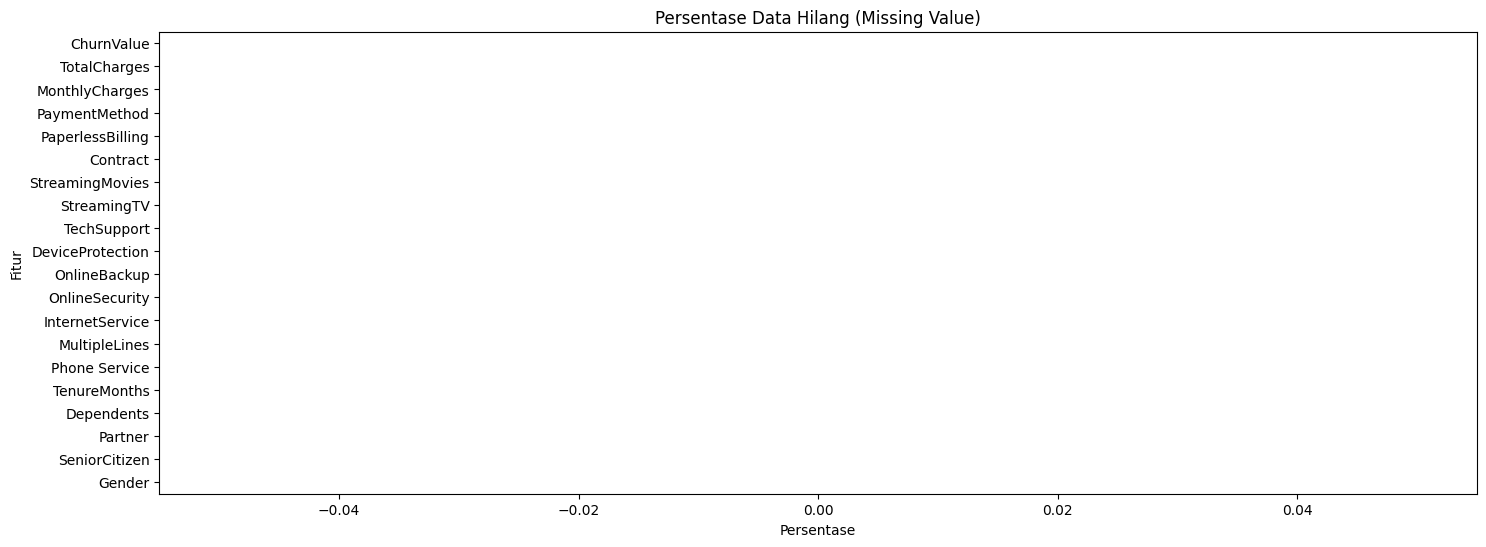

In [21]:
#plt.style.use('fivethirtyeight')
display(df_observation.isna().sum()/len(df_observation)*100)
(df_observation.isna().sum()/len(df_observation)*100).plot(kind = 'barh', figsize = (17,6));
plt.title('Persentase Data Hilang (Missing Value)')
plt.xlabel('Persentase')
plt.ylabel('Fitur')
plt.show()

In [4]:
'''
Menghilangkan fitur yang tidak digunakan pada dataset, fitur tersebut merupakan fitur
yang hanya diproses oleh pihak sumber dataset yaitu IBM dan tidak terdapat secara
umum pada pelanggan jika menggunakan provider yang berbeda. Seperti CLTV dan Churn score
yang hanya menggunakan perhitungan dengan pemodelan yang dibuat oleh pihak IBM.

'''
df_observation.drop(columns=['CustomerID','Count','Country','State','City','Zip Code','Lat Long','Latitude','Longitude','ChurnLabel','ChurnReason','CLTV','ChurnScore'], inplace=True, axis=1)

Dataframe Observation digunakan sebagai acuan dalam melakukan analisis terhadap dataset, tidak digunakan sebagai pengolahan untuk melakukan proses pembelajaran mesin.

## Imputasi Data

In [13]:
# Mengubah jenis data pada fitur TotalCharges dari object ke numerik
df_observation['TotalCharges'] = pd.to_numeric(df_observation['TotalCharges'], errors='coerce')

In [14]:
#indeks data dengan data yang kosong
null = df_observation[df_observation['TotalCharges'].isna()].index.tolist()
null

[2234, 2438, 2568, 2667, 2856, 4331, 4687, 5104, 5719, 6772, 6840]

In [22]:
#for i in null:
#  df_observation['TotalCharges'].iloc[i] = df_observation['MonthlyCharges'].iloc[i] * df_observation['TenureMonths'].iloc[i]
#  print(df_observation['TotalCharges'].iloc[i])

In [23]:
#terdapat 11 data kosong pada maka dari itu diisi dengan rata-rata (Data Imputation)
df_observation['TotalCharges'].fillna(df_observation['TotalCharges'].mean(), inplace=True)

Proses data *imputation* atau memberikan suatu nilai angka untuk mengisi baris data yang kosong. Pada prakteknya, terdapat pilihan untuk menghilangkan baris data yang tidak terdapat data, tetapi pada percobaan ini baris yang kosong tersebut diberikan nilai rata-rata dari fitur.

In [24]:
# Jumlah data untuk dilakukan percobaan
print('Shape of Dataframe : ', df_observation.shape)

Shape of Dataframe :  (7043, 20)


## Pratinjau Data

In [5]:
def summarize_categoricals(df, show_levels=False):
    """
        Display uniqueness in each column
    """
    data = [[df[c].unique(), len(df[c].unique()), df[c].isnull().sum()] for c in df.columns]
    df_temp = pd.DataFrame(data, index=df.columns,
                           columns=['Nominal', 'Jumlah Katogorikal', 'Jumlah data hilang'])
    df_temp.index.name = 'Fitur'
    return df_temp.iloc[:, 0 if show_levels else 1:]


def find_categorical(df, cutoff=10):
    """
        Function to find categorical columns in the dataframe.
    """
    cat_cols = []
    for col in df.columns:
        if len(df[col].unique()) <= cutoff:
            cat_cols.append(col)
    return cat_cols


def to_categorical(columns, df):
    """
        Converts the columns passed in `columns` to categorical datatype
    """
    for col in columns:
        df[col] = df[col].astype('category')
    return df

In [6]:
categoricals_pratinjau = find_categorical(df_observation, cutoff=5)
res = summarize_categoricals(df_observation[categoricals_pratinjau], show_levels=True)
res.to_excel('fitur_kategorikal.xlsx')

In [7]:
df_observation['ChurnValue'].value_counts()

0    5174
1    1869
Name: ChurnValue, dtype: int64

In [8]:
df_observation['PaymentMethod'].unique()

array(['Mailed check', 'Electronic check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [9]:
numericals_pratinjau = list(set(df_observation.columns.tolist()) - set(categoricals_pratinjau)) + list(set(categoricals_pratinjau) - set(df_observation.columns.tolist()))
numericals_pratinjau

['TenureMonths', 'TotalCharges', 'MonthlyCharges']

In [12]:
(df_observation[numericals_pratinjau].isna().sum()/len(df_observation[numericals_pratinjau])*100)#.plot(kind = 'bar', figsize = (10,8));

TenureMonths      0.0
TotalCharges      0.0
MonthlyCharges    0.0
dtype: float64

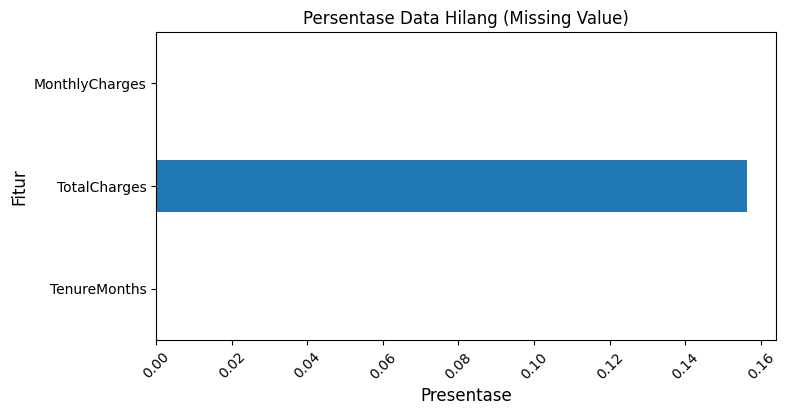

<Figure size 640x480 with 0 Axes>

In [21]:
(df_observation[numericals_pratinjau].isna().sum()/len(df_observation[numericals_pratinjau])*100).plot(kind = 'barh', figsize = (8,4));
plt.title('Persentase Data Hilang (Missing Value)')
plt.xlabel('Presentase',fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Fitur',fontsize=12)
plt.show()
plt.savefig('Presentase data hilang.jpg',dpi=300)

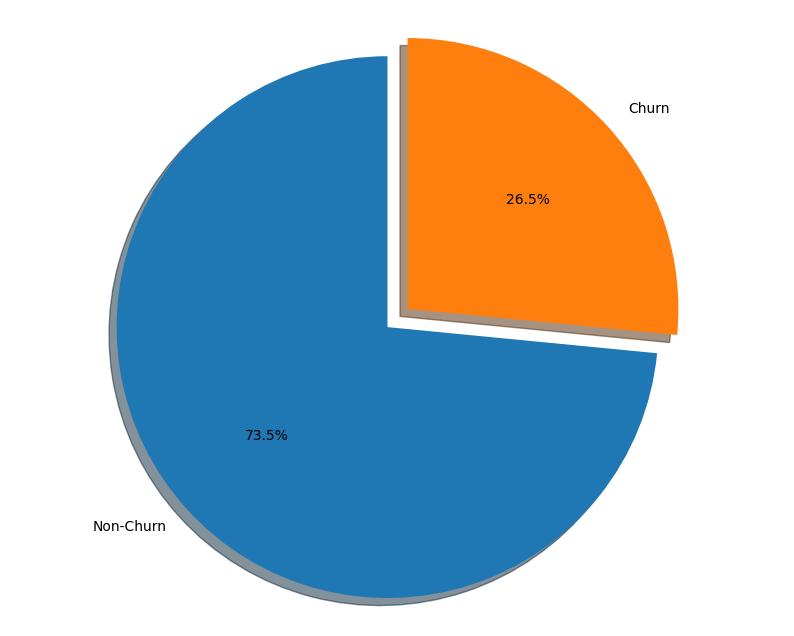

In [15]:
labels = 'Non-Churn', 'Churn'
sizes = [df_observation['ChurnValue'][df_observation['ChurnValue']==0].count(), df_observation['ChurnValue'][df_observation['ChurnValue']==1].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
#plt.title("Proporsi Antara Pelanggan 'Churn' dan Tidak pada Dataset", size = 20)
plt.savefig("Proportion of customer churned and retained original.png")
plt.show();

Dari visualisasi *pie chart* diperoleh informasi bahwa kelas data atau target mengalami ketidakseimbangan.

In [16]:
df_observation[df_observation['ChurnValue']==1]['PaperlessBilling'].value_counts()

Yes    1400
No      469
Name: PaperlessBilling, dtype: int64

In [17]:
df_observation[df_observation['ChurnValue']==1]['PaymentMethod'].value_counts()

Electronic check             1071
Mailed check                  308
Bank transfer (automatic)     258
Credit card (automatic)       232
Name: PaymentMethod, dtype: int64

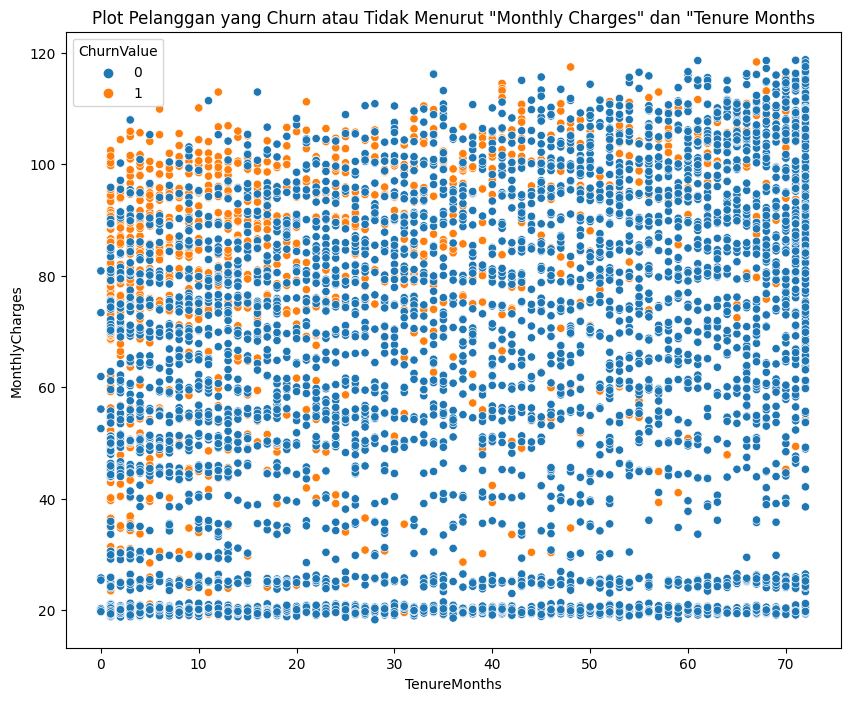

In [18]:
plt.figure(figsize=(10,8))
plt.title('Plot Pelanggan yang Churn atau Tidak Menurut "Monthly Charges" dan "Tenure Months')
sns.scatterplot(x='TenureMonths',y='MonthlyCharges',data=df_observation,hue='ChurnValue')
plt.show()

Dari *scatter plot* antara fitur "Tenure Months" dan "Monthly Charges" didapatkan informasi bahwa pelanggan yang meninggalkan layanan provider merupakan pelanggan yang membayar tagihan bulanannya lebih dari atau sama dengan $80, terlihat pada pola persebaran lingkaran biru yang terkumpul lebih banyak di area lebih dari 80.

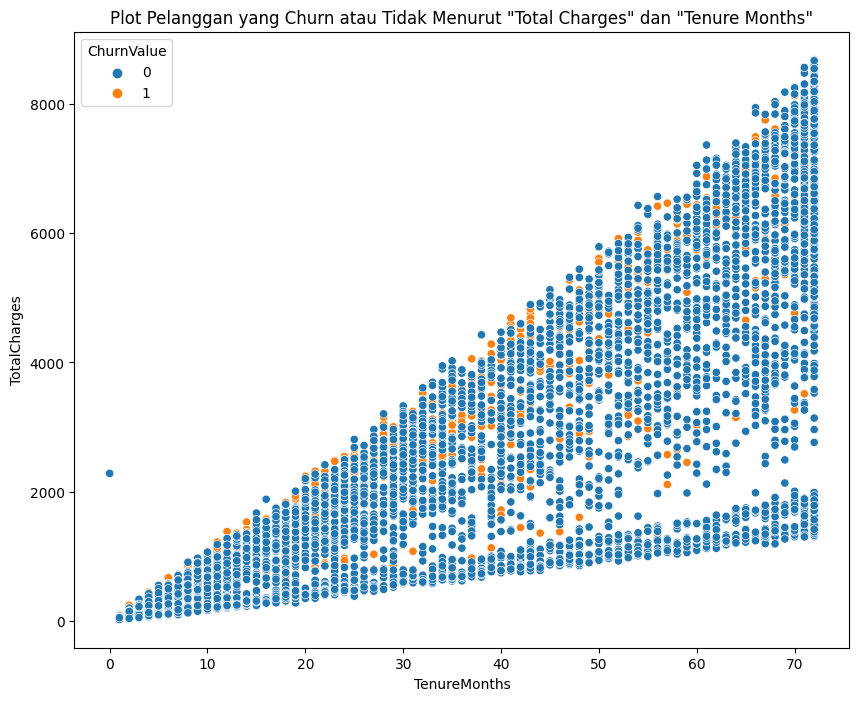

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Plot Pelanggan yang Churn atau Tidak Menurut "Total Charges" dan "Tenure Months"')
sns.scatterplot(x='TenureMonths',y='TotalCharges',data=df_observation,hue='ChurnValue')
plt.show()

Dari informasi yang diperoleh pada *scatter plot* di atas mengatakan bahwa fitur "Tenure Months" dengan "Total Charges" bersifat linier positif atau jika seseorang berlangganan sudah lama maka secara jumlah biaya yang sudah dikeluarkan akan semakin besar.

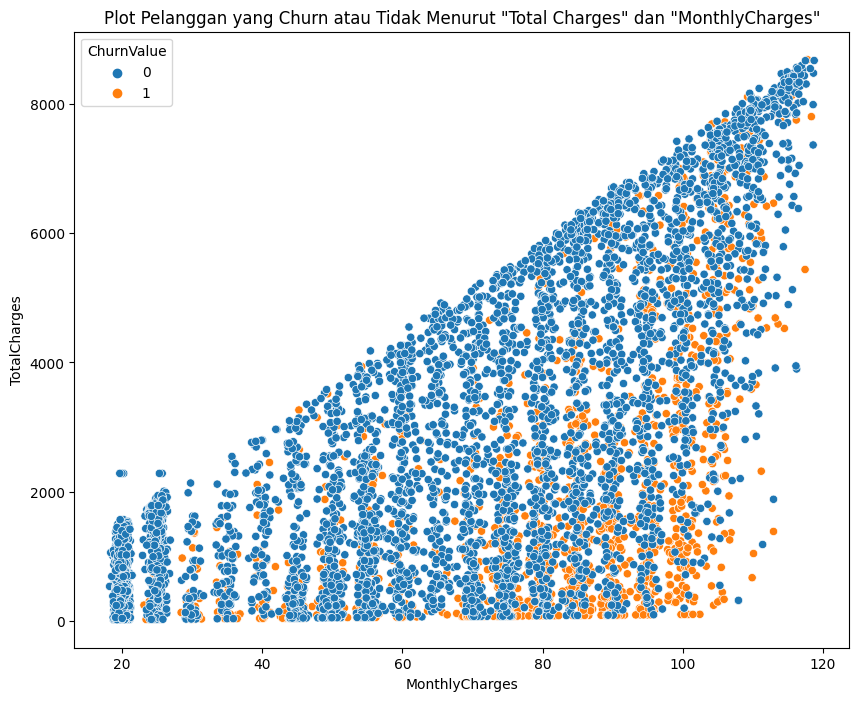

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Plot Pelanggan yang Churn atau Tidak Menurut "Total Charges" dan "MonthlyCharges"')
sns.scatterplot(x='MonthlyCharges',y='TotalCharges',data=df_observation,hue='ChurnValue')
plt.show()

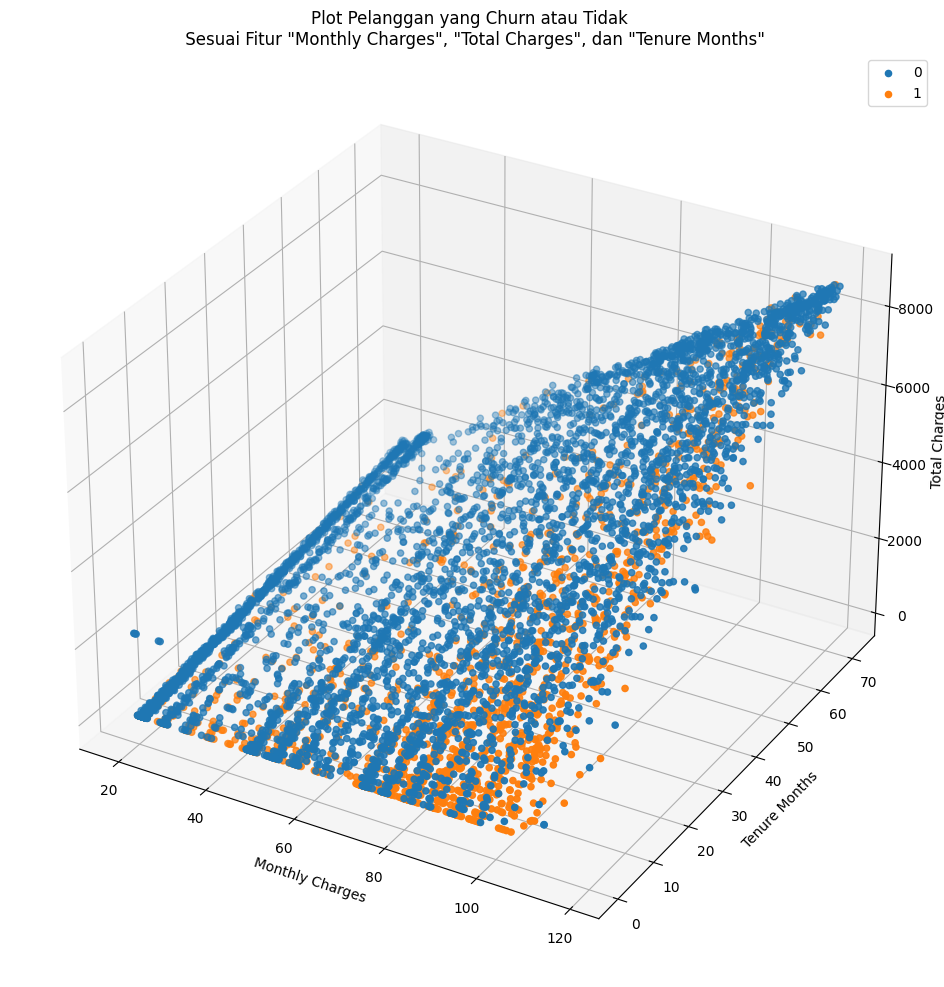

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
plt.title('Plot Pelanggan yang Churn atau Tidak \n Sesuai Fitur "Monthly Charges", "Total Charges", dan "Tenure Months"')
for c in [0,1]: #df_observation.ChurnValue.unique():
  ax.scatter(df_observation.MonthlyCharges[df_observation.ChurnValue==c],df_observation.TenureMonths[df_observation.ChurnValue==c],df_observation.TotalCharges[df_observation.ChurnValue==c], label=c)
ax.set_xlabel('Monthly Charges')
ax.set_ylabel('Tenure Months')
ax.set_zlabel('Total Charges')
ax.legend()

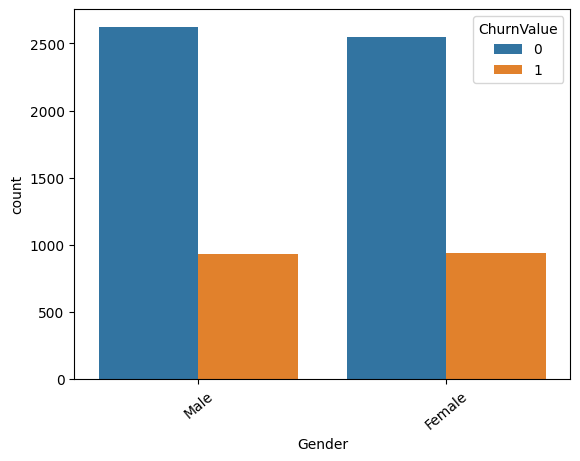

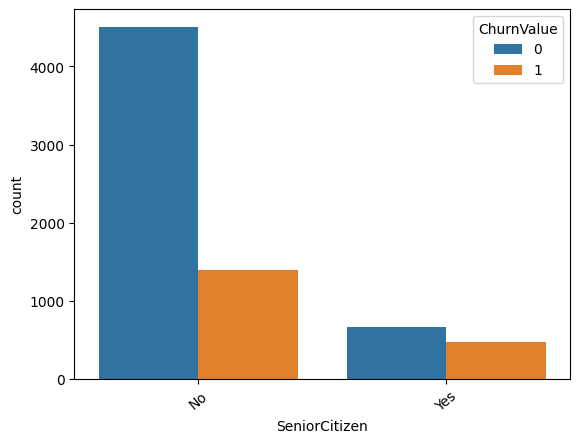

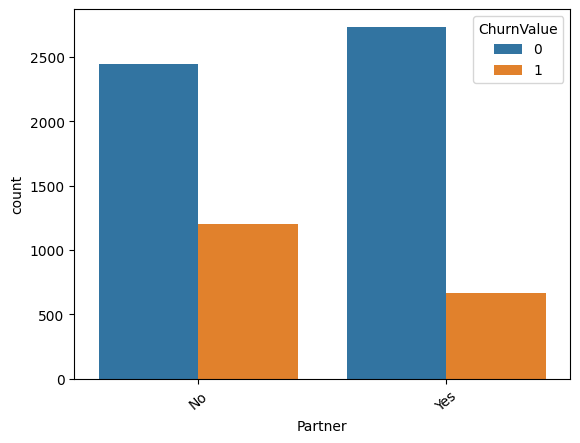

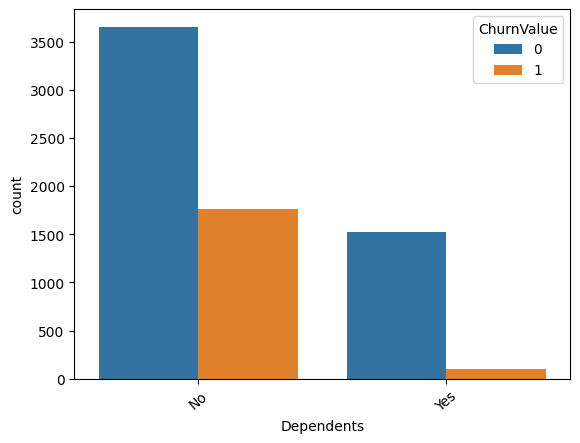

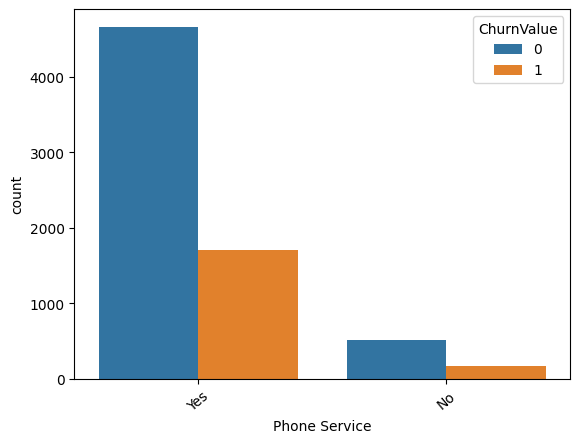

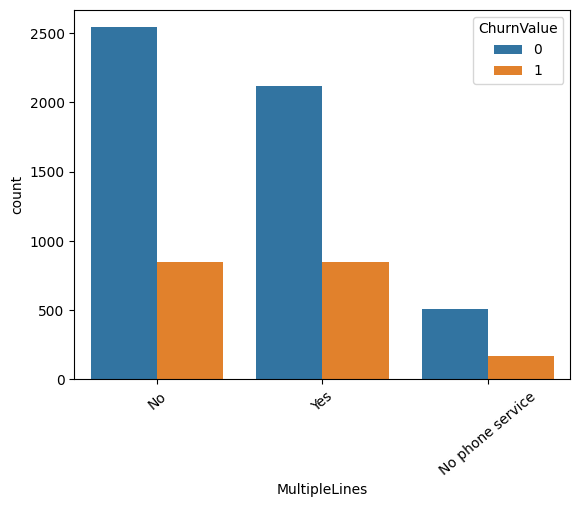

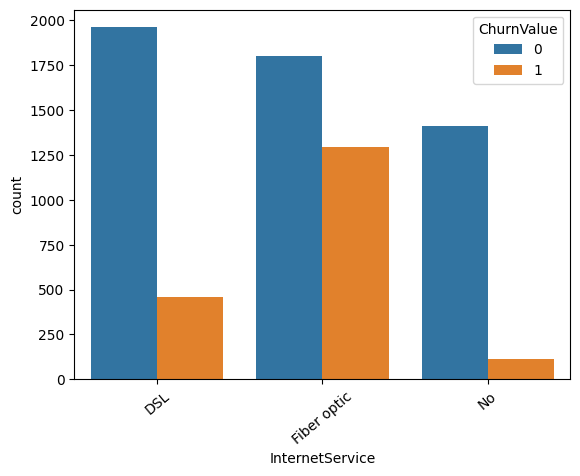

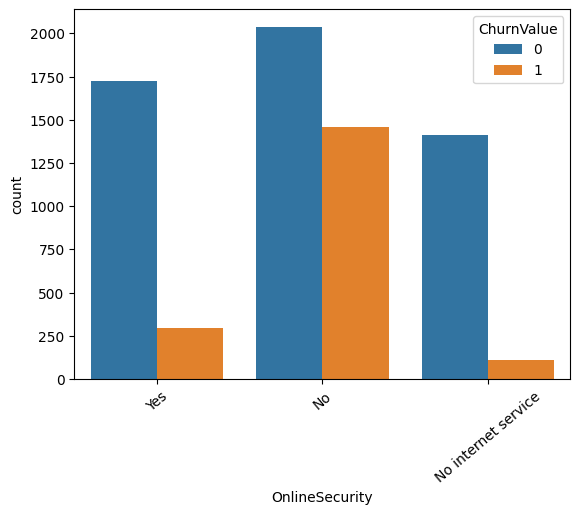

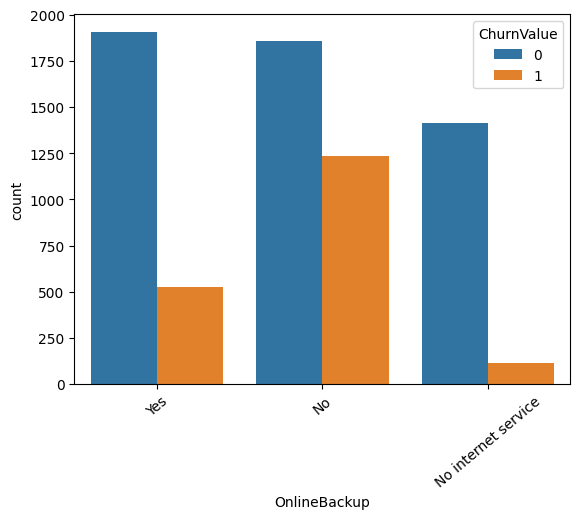

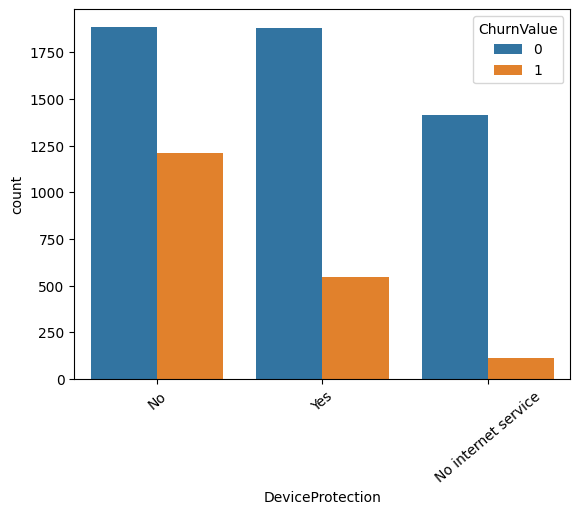

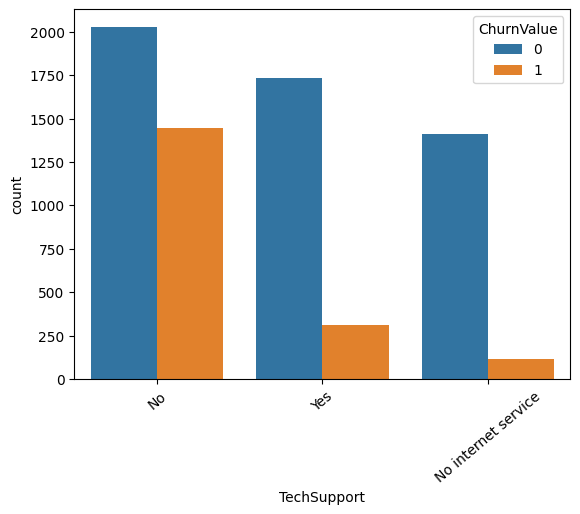

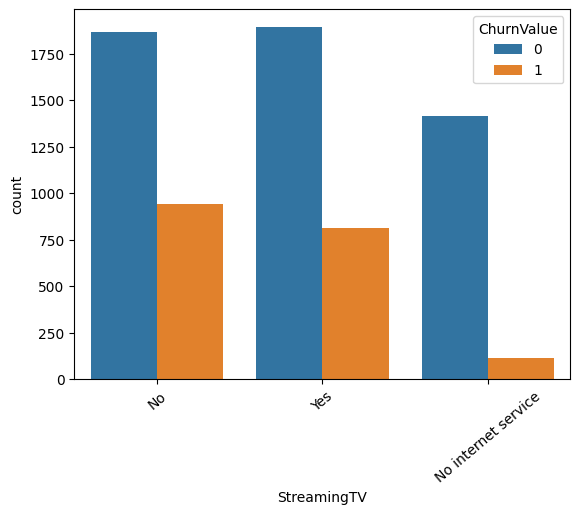

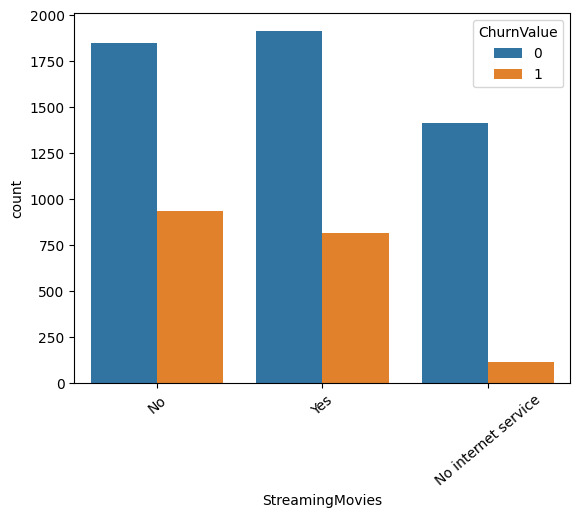

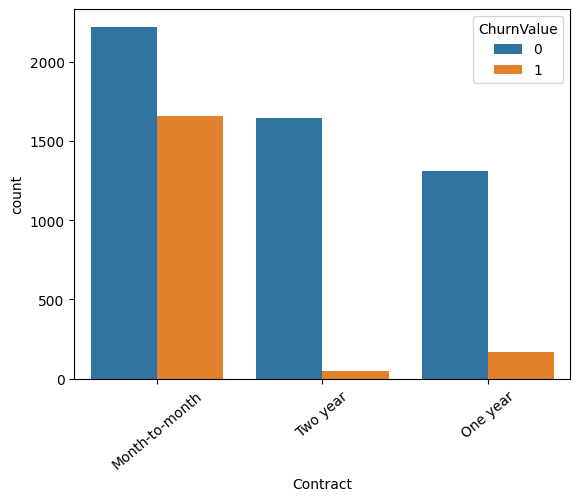

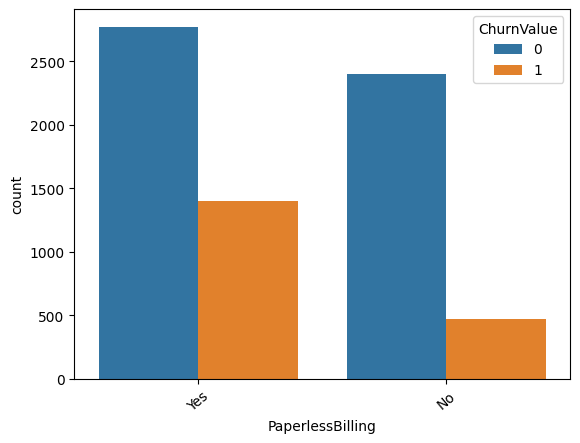

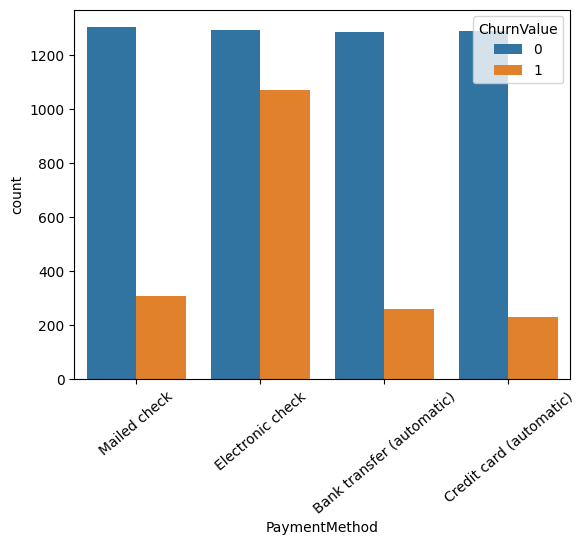

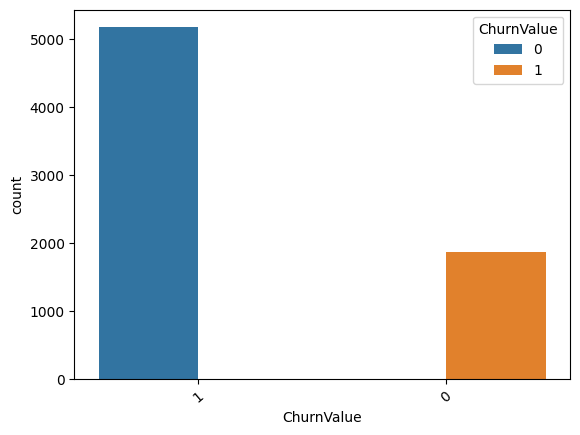

In [ ]:
for col in categoricals_pratinjau:
  plt.figure()
  sns.countplot(x=col,hue='ChurnValue',data=df_observation)\
  .set_xticklabels(df_observation[col].unique().tolist(), rotation=40)
  plt.show

In [ ]:
'''
fig, axarr = plt.subplots(3, 4, figsize=(30, 50))
sns.countplot(x='Gender', hue = 'ChurnValue',data = df_observation, ax=axarr[0][0])
sns.countplot(x='InternetService', hue = 'ChurnValue',data = df_observation, ax=axarr[0][1])
axarr[0][1].set_xticklabels(df_observation['InternetService'].unique().tolist(), rotation=40)
sns.countplot(x='Contract', hue = 'ChurnValue',data = df_observation, ax=axarr[0][2])
sns.countplot(x='PaymentMethod', hue = 'ChurnValue',data = df_observation, ax=axarr[1][0])
axarr[1][1].set_xticklabels(df_observation['PaymentMethod'].unique().tolist(), rotation=40)
sns.countplot(x='SeniorCitizen', hue = 'ChurnValue',data = df_observation, ax=axarr[1][1])
sns.countplot(x='MultipleLines', hue = 'ChurnValue',data = df_observation, ax=axarr[1][2])
sns.countplot(x='OnlineSecurity',hue = 'ChurnValue',data = df_observation, ax=axarr[2][0])
sns.countplot(x='OnlineBackup', hue = 'ChurnValue', data = df_observation, ax=axarr[2][1])
sns.countplot(x='DeviceProtection', hue = 'ChurnValue', data = df_observation, ax=axarr[2][2])
sns.countplot(x='TechSupport', hue = 'ChurnValue',data=df_observation, ax=axarr[3][0])
sns.countplot(x='StreamingTV', hue = 'ChurnValue', data = df_observation, ax=axarr[3][1])
sns.countplot(x='StreamingMovies', hue = 'ChurnValue', data= df_observation, ax=axarr[3][2])
sns.countplot(x='Phone Service', hue = 'ChurnValue', data= df_observation, ax=axarr[4][0])
sns.countplot(x='Partner', hue = 'ChurnValue', data= df_observation, ax=axarr[4][1])
sns.countplot(x='Dependents', hue = 'ChurnValue', data= df_observation, ax=axarr[4][2])
sns.countplot(x='PaperlessBilling', hue = 'ChurnValue', data= df_observation, ax=axarr[4][1])
plt.tight_layout()
plt.show();
'''

"\nfig, axarr = plt.subplots(3, 4, figsize=(30, 50))\nsns.countplot(x='Gender', hue = 'ChurnValue',data = df_observation, ax=axarr[0][0])\nsns.countplot(x='InternetService', hue = 'ChurnValue',data = df_observation, ax=axarr[0][1])\naxarr[0][1].set_xticklabels(df_observation['InternetService'].unique().tolist(), rotation=40)\nsns.countplot(x='Contract', hue = 'ChurnValue',data = df_observation, ax=axarr[0][2])\nsns.countplot(x='PaymentMethod', hue = 'ChurnValue',data = df_observation, ax=axarr[1][0])\naxarr[1][1].set_xticklabels(df_observation['PaymentMethod'].unique().tolist(), rotation=40)\nsns.countplot(x='SeniorCitizen', hue = 'ChurnValue',data = df_observation, ax=axarr[1][1])\nsns.countplot(x='MultipleLines', hue = 'ChurnValue',data = df_observation, ax=axarr[1][2])\nsns.countplot(x='OnlineSecurity',hue = 'ChurnValue',data = df_observation, ax=axarr[2][0])\nsns.countplot(x='OnlineBackup', hue = 'ChurnValue', data = df_observation, ax=axarr[2][1])\nsns.countplot(x='DeviceProtectio

Kumpulan grafik hitung di atas merupakan grafik hitung dari semua fitur yang bersifat kategorikal pada dataset, akan terlihat jumlah proporsi pelanggan yang meninggalkan layanan (churn) atau tidak pada setiap fitur kategorik.

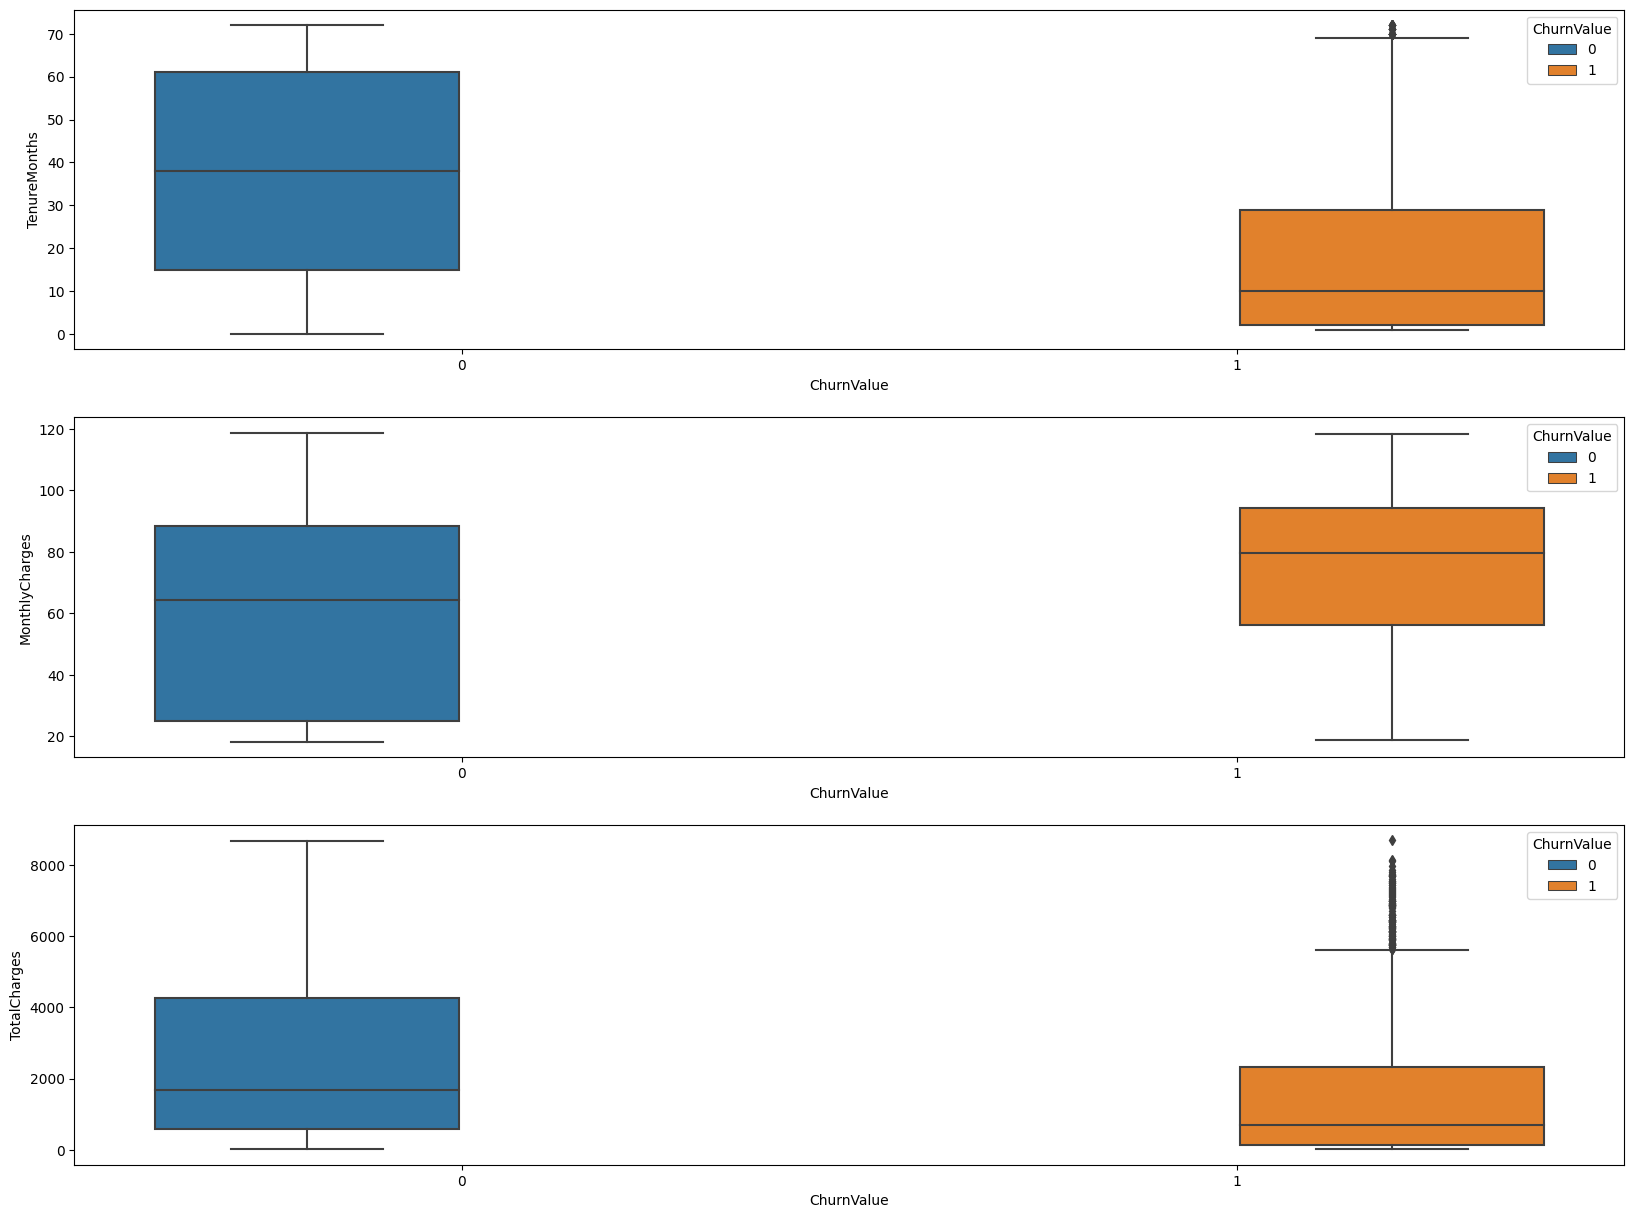

In [ ]:
fig, axarr = plt.subplots(3, 1, figsize=(20, 15))
sns.boxplot(y='TenureMonths',x = 'ChurnValue', hue = 'ChurnValue', data = df_observation, ax=axarr[0])
sns.boxplot(y='MonthlyCharges',x = 'ChurnValue', hue = 'ChurnValue', data = df_observation , ax=axarr[1])
sns.boxplot(y='TotalCharges',x = 'ChurnValue', hue = 'ChurnValue', data = df_observation , ax=axarr[2])
plt.savefig('Boxplot numeric feature churn label.png')
plt.show();

## Menghilangkan Data Outlier

Kumpulan grafik *boxplot* dengan fitur yang bersifat numerik pada dataset. Ini akan memudahkan mengetahui persebaran data dari setiap fitur numerik secara visual. Informasi lainnya adalah terdapat data *outlier* atau yang berada pada rentang diatas batas atas (Q3 + 1.5 x IQR) dan di bawah batas bawah (Q1 - 1.5 x IQR)  khususnya pada kelas 'Yes' pada fitur "Churn Label".

In [25]:
df_observation.describe().T

count         mean          std    min      25%      50%  \
TenureMonths    7043.0    32.371149    24.559481   0.00    9.000    29.00   
MonthlyCharges  7043.0    64.761692    30.090047  18.25   35.500    70.35   
TotalCharges    7043.0  2283.300441  2265.000258  18.80  402.225  1400.55   
ChurnValue      7043.0     0.265370     0.441561   0.00    0.000     0.00   

                    75%      max  
TenureMonths      55.00    72.00  
MonthlyCharges    89.85   118.75  
TotalCharges    3786.60  8684.80  
ChurnValue         1.00     1.00

In [26]:
#Dataframe dengan kelas "yes" pada fitur "churn label"
label_yes = df_observation[df_observation['ChurnValue']==1]
label_yes

Gender SeniorCitizen Partner Dependents  TenureMonths Phone Service  \
0       Male            No      No         No             2           Yes   
1     Female            No      No        Yes             2           Yes   
2     Female            No      No        Yes             8           Yes   
3     Female            No     Yes        Yes            28           Yes   
4       Male            No      No        Yes            49           Yes   
...      ...           ...     ...        ...           ...           ...   
1864    Male            No      No         No            12           Yes   
1865  Female            No      No         No             9           Yes   
1866    Male           Yes      No         No             1           Yes   
1867  Female            No      No         No            67           Yes   
1868    Male           Yes     Yes         No             4           Yes   

     MultipleLines InternetService OnlineSecurity OnlineBackup  \
0               No             DSL            Yes          Yes   
1               No     Fiber optic             No           No   
2              Yes     Fiber optic             No           No   
3              Yes     Fiber optic             No           No   
4              Yes     Fiber optic             No          Yes   
...            ...             ...            ...          ...   
1864            No             DSL             No           No   
1865            No             DSL             No           No   
1866           Yes     Fiber optic             No           No   
1867           Yes     Fiber optic            Yes          Yes   
1868           Yes     Fiber optic             No           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                  No          No          No              No  Month-to-month   
2                 Yes          No         Yes             Yes  Month-to-month   
3                 Yes         Yes         Yes             Yes  Month-to-month   
4                 Yes          No         Yes             Yes  Month-to-month   
...               ...         ...         ...             ...             ...   
1864               No         Yes         Yes              No        One year   
1865               No          No          No              No  Month-to-month   
1866               No          No          No              No  Month-to-month   
1867              Yes          No         Yes              No  Month-to-month   
1868               No          No          No              No  Month-to-month   

     PaperlessBilling              PaymentMethod  MonthlyCharges  \
0                 Yes               Mailed check           53.85   
1                 Yes           Electronic check           70.70   
2                 Yes           Electronic check           99.65   
3                 Yes           Electronic check          104.80   
4                 Yes  Bank transfer (automatic)          103.70   
...               ...                        ...             ...   
1864              Yes           Electronic check           59.80   
1865              Yes  Bank transfer (automatic)           44.20   
1866              Yes           Electronic check           75.75   
1867              Yes    Credit card (automatic)          102.95   
1868              Yes               Mailed check           74.40   

      TotalCharges  ChurnValue  
0           108.15           1  
1           151.65           1  
2           820.50           1  
3          3046.05           1  
4          5036.30           1  
...            ...         ...  
1864        727.80           1  
1865        403.35           1  
1866         75.75           1  
1867       6886.25           1  
1868        306.60           1  

[1869 rows x 20 columns]

In [27]:
label_yes.describe().T

count         mean          std    min     25%     50%  \
TenureMonths    1869.0    17.979133    19.531123   1.00    2.00   10.00   
MonthlyCharges  1869.0    74.441332    24.666053  18.85   56.15   79.65   
TotalCharges    1869.0  1531.796094  1890.822994  18.85  134.50  703.55   
ChurnValue      1869.0     1.000000     0.000000   1.00    1.00    1.00   

                   75%      max  
TenureMonths      29.0    72.00  
MonthlyCharges    94.2   118.35  
TotalCharges    2331.3  8684.80  
ChurnValue         1.0     1.00

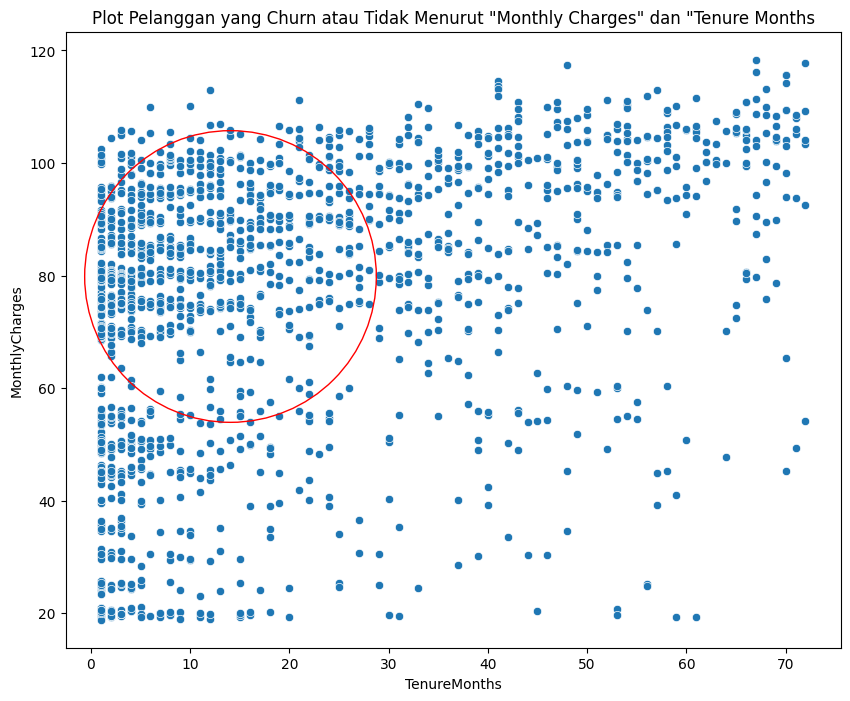

In [67]:
circle1 = plt.Circle(xy=(0, 0), radius=2, color='red', fill=False)
plt.figure(figsize=(10,8))
plt.title('Plot Pelanggan yang Churn atau Tidak Menurut "Monthly Charges" dan "Tenure Months')
a = sns.scatterplot(x='TenureMonths',y='MonthlyCharges',data=label_yes)
a.plot([14],[80],'o',ms=210,mec='r',mfc='none')

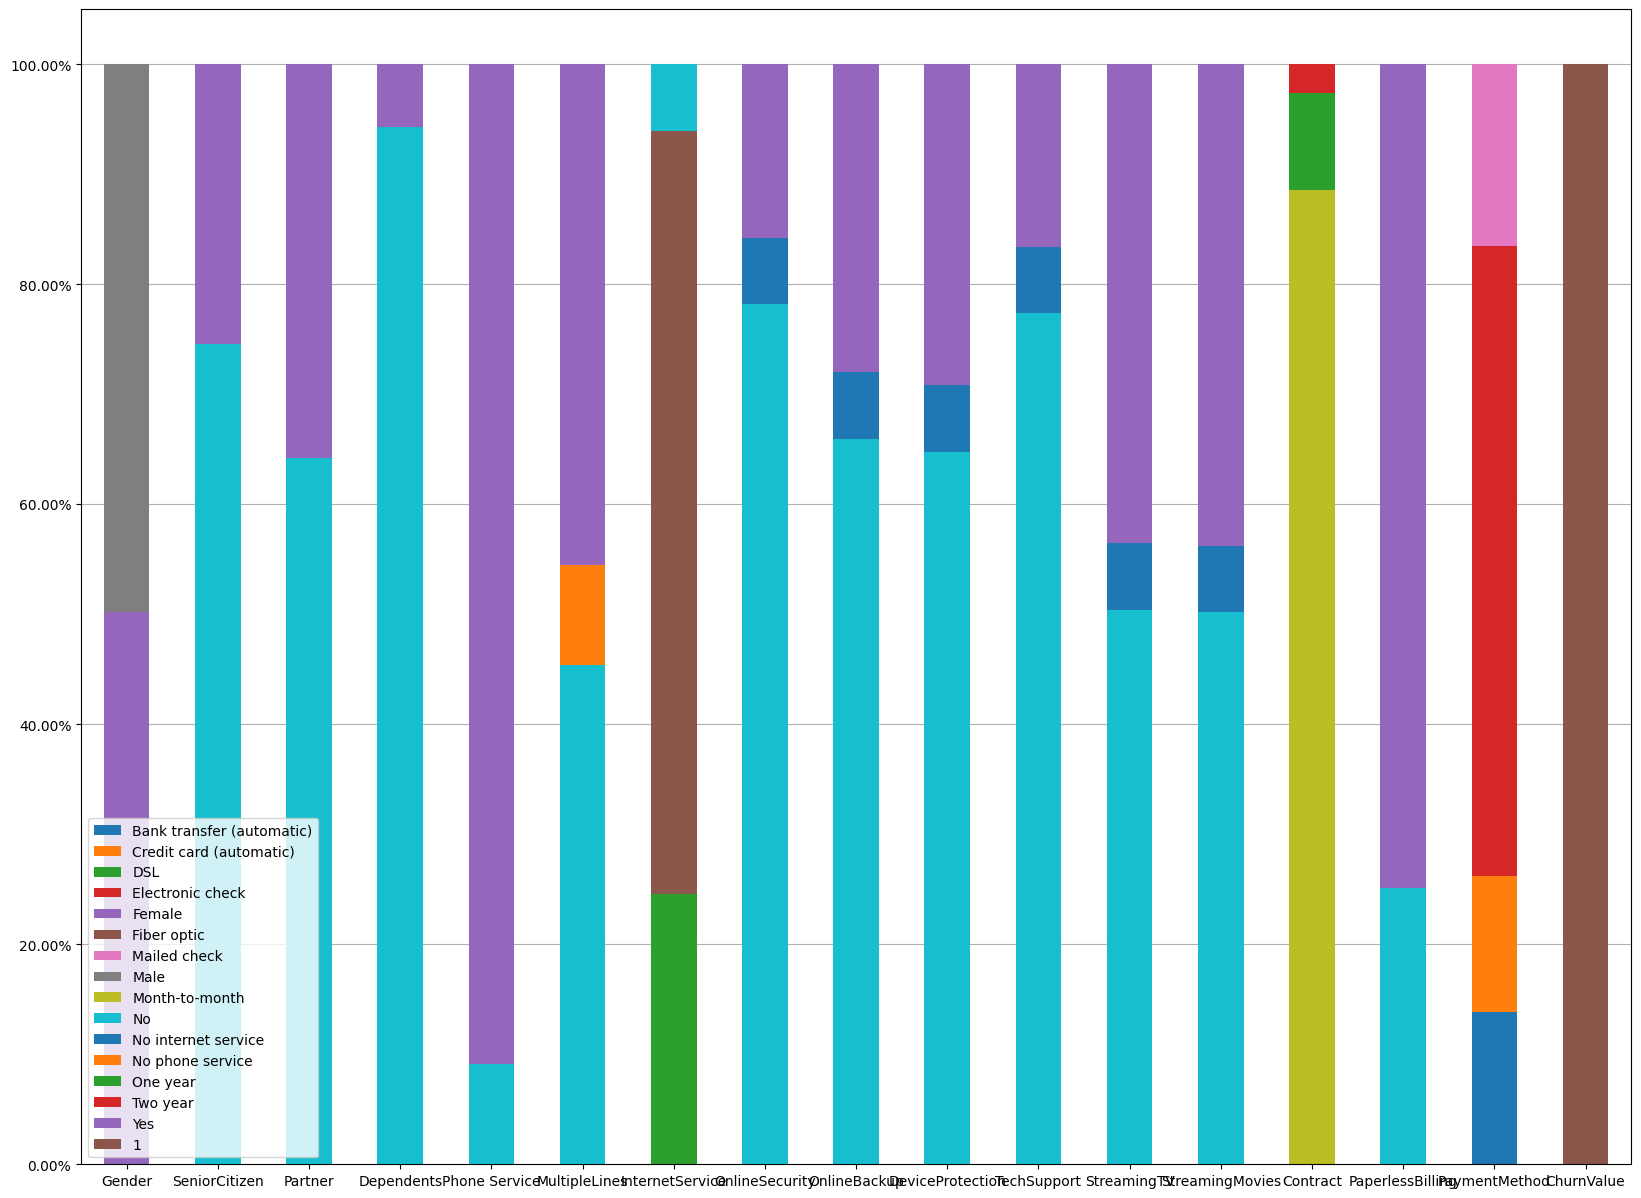

In [69]:
counts = label_yes[categoricals_pratinjau].apply(lambda x: x.value_counts() / len(x)).transpose()
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
counts.plot(ax=ax,kind='bar', stacked=True, rot=0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
ax.yaxis.grid(True)
ax.set_axisbelow(True)
plt.show()

In [70]:
# Melihat data outlier
def outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit

In [71]:
numericals_ = ['TotalCharges','MonthlyCharges','TenureMonths']

In [72]:
upper_ = []
lower_ = []
for col in numericals_:
  upper, lower = outliers(label_yes, col)
  upper_.append(upper)
  lower_.append(lower)
  print('============================')
  print(col)
  print("Upper: ", upper)
  print("Lower: ", lower)
  print('============================')

TotalCharges
Upper:  5626.5
Lower:  -3160.7000000000003
MonthlyCharges
Upper:  151.275
Lower:  -0.9250000000000043
TenureMonths
Upper:  69.5
Lower:  -38.5


In [73]:
upper_

[5626.5, 151.275, 69.5]

In [74]:
label_yes = label_yes[(label_yes['TotalCharges'] > lower_[0]) & (label_yes['TotalCharges'] < upper_[0])]
label_yes = label_yes[(label_yes['MonthlyCharges'] > lower_[1]) & (label_yes['MonthlyCharges'] < upper_[1])]
label_yes = label_yes[(label_yes['TenureMonths'] > lower_[2]) & (label_yes['TenureMonths'] < upper_[2])]

label_yes

Gender SeniorCitizen Partner Dependents  TenureMonths Phone Service  \
0       Male            No      No         No             2           Yes   
1     Female            No      No        Yes             2           Yes   
2     Female            No      No        Yes             8           Yes   
3     Female            No     Yes        Yes            28           Yes   
4       Male            No      No        Yes            49           Yes   
...      ...           ...     ...        ...           ...           ...   
1863    Male            No     Yes        Yes             1           Yes   
1864    Male            No      No         No            12           Yes   
1865  Female            No      No         No             9           Yes   
1866    Male           Yes      No         No             1           Yes   
1868    Male           Yes     Yes         No             4           Yes   

     MultipleLines InternetService OnlineSecurity OnlineBackup  \
0               No             DSL            Yes          Yes   
1               No     Fiber optic             No           No   
2              Yes     Fiber optic             No           No   
3              Yes     Fiber optic             No           No   
4              Yes     Fiber optic             No          Yes   
...            ...             ...            ...          ...   
1863            No     Fiber optic             No           No   
1864            No             DSL             No           No   
1865            No             DSL             No           No   
1866           Yes     Fiber optic             No           No   
1868           Yes     Fiber optic             No           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                  No          No          No              No  Month-to-month   
2                 Yes          No         Yes             Yes  Month-to-month   
3                 Yes         Yes         Yes             Yes  Month-to-month   
4                 Yes          No         Yes             Yes  Month-to-month   
...               ...         ...         ...             ...             ...   
1863               No          No          No              No  Month-to-month   
1864               No         Yes         Yes              No        One year   
1865               No          No          No              No  Month-to-month   
1866               No          No          No              No  Month-to-month   
1868               No          No          No              No  Month-to-month   

     PaperlessBilling              PaymentMethod  MonthlyCharges  \
0                 Yes               Mailed check           53.85   
1                 Yes           Electronic check           70.70   
2                 Yes           Electronic check           99.65   
3                 Yes           Electronic check          104.80   
4                 Yes  Bank transfer (automatic)          103.70   
...               ...                        ...             ...   
1863              Yes               Mailed check           70.65   
1864              Yes           Electronic check           59.80   
1865              Yes  Bank transfer (automatic)           44.20   
1866              Yes           Electronic check           75.75   
1868              Yes               Mailed check           74.40   

      TotalCharges  ChurnValue  
0           108.15           1  
1           151.65           1  
2           820.50           1  
3          3046.05           1  
4          5036.30           1  
...            ...         ...  
1863         70.65           1  
1864        727.80           1  
1865        403.35           1  
1866         75.75           1  
1868        306.60           1  

[1756 rows x 20 columns]

In [75]:
label_no = df_observation[df_observation['ChurnValue']==0]
label_no

Gender SeniorCitizen Partner Dependents  TenureMonths Phone Service  \
1869  Female            No     Yes         No             1            No   
1870    Male            No      No         No            34           Yes   
1871    Male            No      No         No            45            No   
1872    Male            No      No        Yes            22           Yes   
1873  Female            No      No         No            10            No   
...      ...           ...     ...        ...           ...           ...   
7038  Female            No      No         No            72           Yes   
7039    Male            No     Yes        Yes            24           Yes   
7040  Female            No     Yes        Yes            72           Yes   
7041  Female            No     Yes        Yes            11            No   
7042    Male            No      No         No            66           Yes   

         MultipleLines InternetService       OnlineSecurity  \
1869  No phone service             DSL                   No   
1870                No             DSL                  Yes   
1871  No phone service             DSL                  Yes   
1872               Yes     Fiber optic                   No   
1873  No phone service             DSL                  Yes   
...                ...             ...                  ...   
7038                No              No  No internet service   
7039               Yes             DSL                  Yes   
7040               Yes     Fiber optic                   No   
7041  No phone service             DSL                  Yes   
7042                No     Fiber optic                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
1869                  Yes                   No                   No   
1870                   No                  Yes                   No   
1871                   No                  Yes                  Yes   
1872                  Yes                   No                   No   
1873                   No                   No                   No   
...                   ...                  ...                  ...   
7038  No internet service  No internet service  No internet service   
7039                   No                  Yes                  Yes   
7040                  Yes                  Yes                   No   
7041                   No                   No                   No   
7042                   No                  Yes                  Yes   

              StreamingTV      StreamingMovies        Contract  \
1869                   No                   No  Month-to-month   
1870                   No                   No        One year   
1871                   No                   No        One year   
1872                  Yes                   No  Month-to-month   
1873                   No                   No  Month-to-month   
...                   ...                  ...             ...   
7038  No internet service  No internet service        Two year   
7039                  Yes                  Yes        One year   
7040                  Yes                  Yes        One year   
7041                   No                   No  Month-to-month   
7042                  Yes                  Yes        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges  \
1869              Yes           Electronic check           29.85   
1870               No               Mailed check           56.95   
1871               No  Bank transfer (automatic)           42.30   
1872              Yes    Credit card (automatic)           89.10   
1873               No               Mailed check           29.75   
...               ...                        ...             ...   
7038              Yes  Bank transfer (automatic)           21.15   
7039              Yes               Mailed check           84.80   
7040              Yes    Credit card (automatic)          103.20  

In [76]:
df_observation = pd.concat([label_yes,label_no])
df_observation.reset_index(drop=True)

Gender SeniorCitizen Partner Dependents  TenureMonths Phone Service  \
0       Male            No      No         No             2           Yes   
1     Female            No      No        Yes             2           Yes   
2     Female            No      No        Yes             8           Yes   
3     Female            No     Yes        Yes            28           Yes   
4       Male            No      No        Yes            49           Yes   
...      ...           ...     ...        ...           ...           ...   
6925  Female            No      No         No            72           Yes   
6926    Male            No     Yes        Yes            24           Yes   
6927  Female            No     Yes        Yes            72           Yes   
6928  Female            No     Yes        Yes            11            No   
6929    Male            No      No         No            66           Yes   

         MultipleLines InternetService       OnlineSecurity  \
0                   No             DSL                  Yes   
1                   No     Fiber optic                   No   
2                  Yes     Fiber optic                   No   
3                  Yes     Fiber optic                   No   
4                  Yes     Fiber optic                   No   
...                ...             ...                  ...   
6925                No              No  No internet service   
6926               Yes             DSL                  Yes   
6927               Yes     Fiber optic                   No   
6928  No phone service             DSL                  Yes   
6929                No     Fiber optic                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
0                     Yes                   No                   No   
1                      No                   No                   No   
2                      No                  Yes                   No   
3                      No                  Yes                  Yes   
4                     Yes                  Yes                   No   
...                   ...                  ...                  ...   
6925  No internet service  No internet service  No internet service   
6926                   No                  Yes                  Yes   
6927                  Yes                  Yes                   No   
6928                   No                   No                   No   
6929                   No                  Yes                  Yes   

              StreamingTV      StreamingMovies        Contract  \
0                      No                   No  Month-to-month   
1                      No                   No  Month-to-month   
2                     Yes                  Yes  Month-to-month   
3                     Yes                  Yes  Month-to-month   
4                     Yes                  Yes  Month-to-month   
...                   ...                  ...             ...   
6925  No internet service  No internet service        Two year   
6926                  Yes                  Yes        One year   
6927                  Yes                  Yes        One year   
6928                   No                   No  Month-to-month   
6929                  Yes                  Yes        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges  \
0                 Yes               Mailed check           53.85   
1                 Yes           Electronic check           70.70   
2                 Yes           Electronic check           99.65   
3                 Yes           Electronic check          104.80   
4                 Yes  Bank transfer (automatic)          103.70   
...               ...                        ...             ...   
6925              Yes  Bank transfer (automatic)           21.15   
6926              Yes               Mailed check           84.80   
6927              Yes    Credit card (automatic)          103.20  

Penghapusan data outlier diperoleh jumlah data sekitar 6930 baris data

In [77]:
print('Jumlah Data Pada Setiap Kelas')
print(df_observation['ChurnValue'].value_counts())

Jumlah Data Pada Setiap Kelas
0    5174
1    1756
Name: ChurnValue, dtype: int64


Setelah mengetahui persentase dari jumlah kelas, ternyata jumlah data dari setiap kelas pada target adalah sebesar 4166 (kelas 0/ non-churn) dan 1756 (kelas 1/ churn). Diperlukan teknik augmentasi untuk membuat kelas yang seimbang pada dataset.  

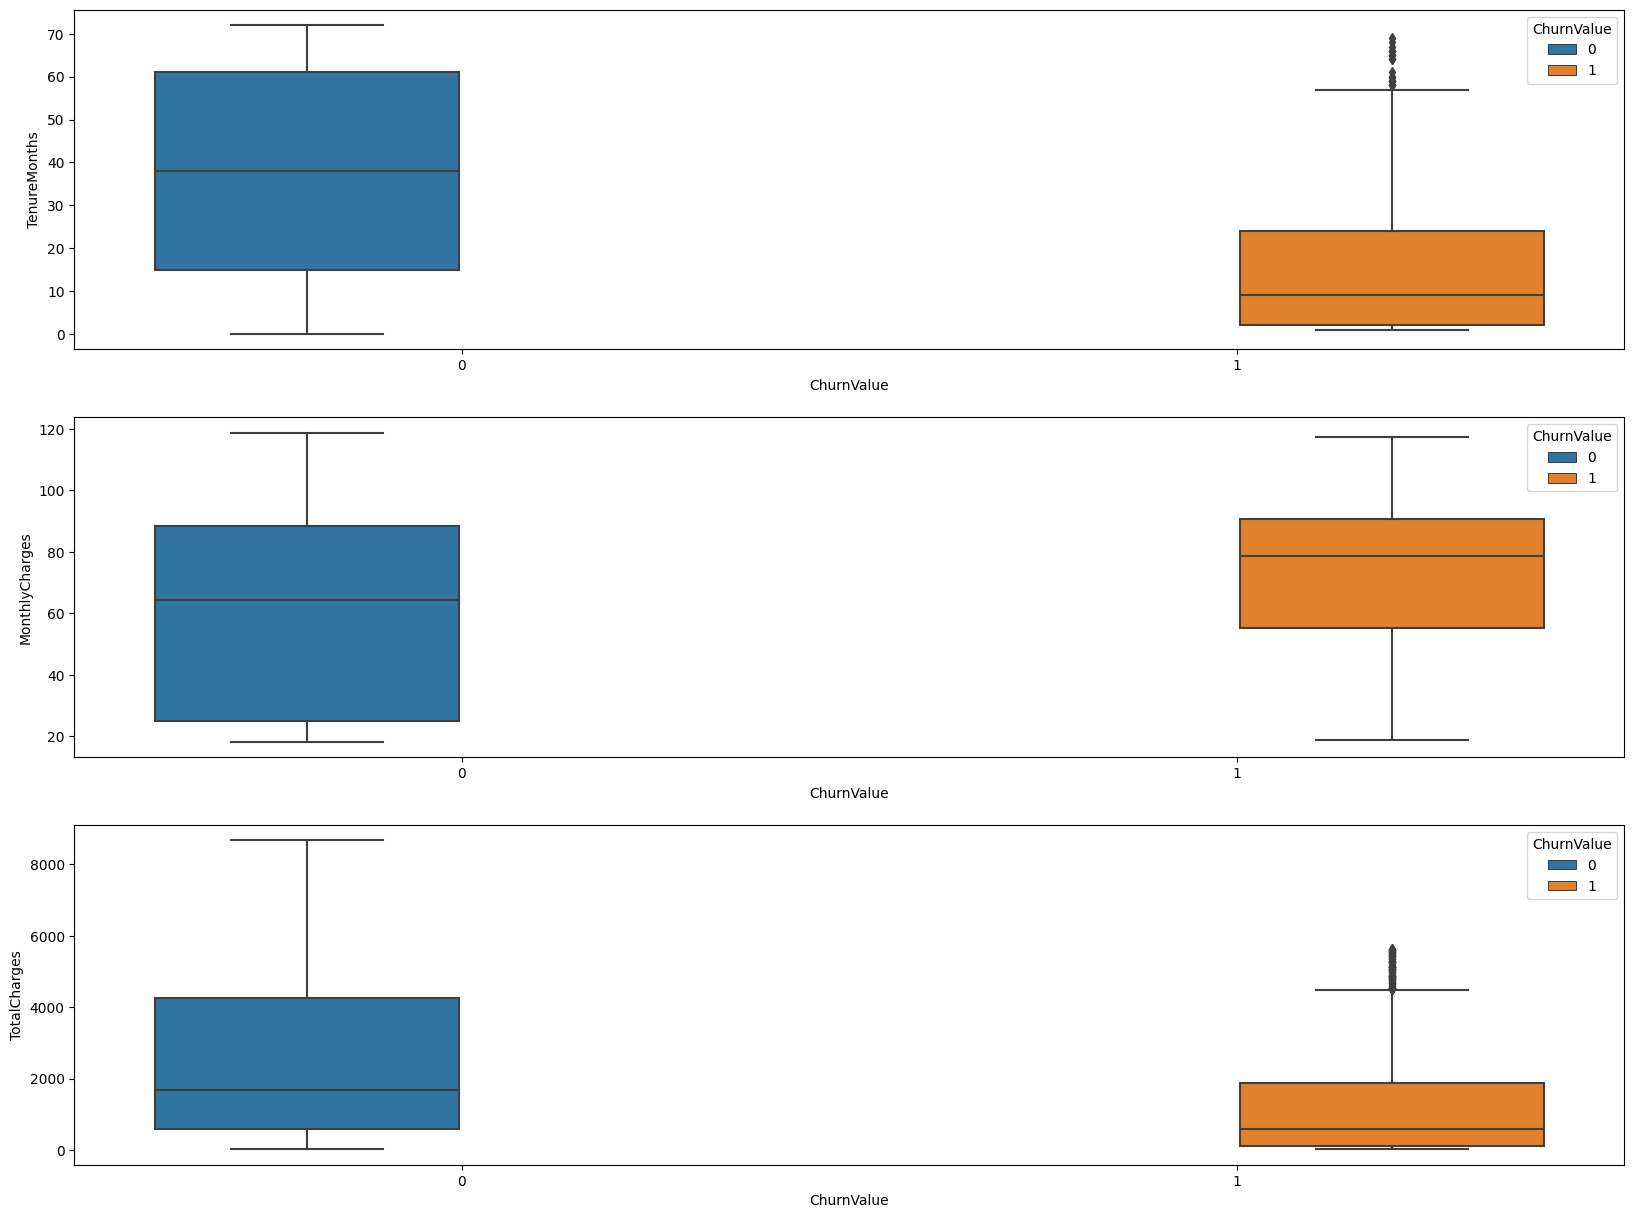

In [78]:
fig, axarr = plt.subplots(3, 1, figsize=(20, 15))
sns.boxplot(y='TenureMonths',x = 'ChurnValue', hue = 'ChurnValue', data = df_observation, ax=axarr[0])
sns.boxplot(y='MonthlyCharges',x = 'ChurnValue', hue = 'ChurnValue', data = df_observation , ax=axarr[1])
sns.boxplot(y='TotalCharges',x = 'ChurnValue', hue = 'ChurnValue', data = df_observation , ax=axarr[2])
plt.savefig('Boxplot numeric feature churn label.png')
plt.show();

## Seleksi Fitur

In [79]:
categoricals_uji = find_categorical(df_observation, cutoff=5)
summarize_categoricals(df_observation[categoricals_uji], show_levels=True)

Nominal  \
Fitur                                                                 
Gender                                               [Male, Female]   
SeniorCitizen                                             [No, Yes]   
Partner                                                   [No, Yes]   
Dependents                                                [No, Yes]   
Phone Service                                             [Yes, No]   
MultipleLines                           [No, Yes, No phone service]   
InternetService                              [DSL, Fiber optic, No]   
OnlineSecurity                       [Yes, No, No internet service]   
OnlineBackup                         [Yes, No, No internet service]   
DeviceProtection                     [No, Yes, No internet service]   
TechSupport                          [No, Yes, No internet service]   
StreamingTV                          [No, Yes, No internet service]   
StreamingMovies                      [No, Yes, No internet service]   
Contract                       [Month-to-month, One year, Two year]   
PaperlessBilling                                          [Yes, No]   
PaymentMethod     [Mailed check, Electronic check, Bank transfer...   
ChurnValue                                                   [1, 0]   

                  Jumlah Katogorikal  Jumlah data hilang  
Fitur                                                     
Gender                             2                   0  
SeniorCitizen                      2                   0  
Partner                            2                   0  
Dependents                         2                   0  
Phone Service                      2                   0  
MultipleLines                      3                   0  
InternetService                    3                   0  
OnlineSecurity                     3                   0  
OnlineBackup                       3                   0  
DeviceProtection                   3                   0  
TechSupport                        3                   0  
StreamingTV                        3                   0  
StreamingMovies                    3                   0  
Contract                           3                   0  
PaperlessBilling                   2                   0  
PaymentMethod                      4                   0  
ChurnValue                         2                   0

Seleksi fitur yang dilakukan menggunakan metode Chi2, *pearson correlation*, dan GLM (General Linear Model). Pada fitur dan target yang berjenis sama kategori dilakukan dengan Chi2. Sedangkan pada fitur yang berjenis numerik dan target berjenis kategorik dilakukan seleksi fitur dengan metode GLM.

Dari fungsi yang dibuat untuk dapat mengetahui fitur mana saja yang bersifat kategorikal, serta juga menampilkan ringkasan nominal beserta jumlah nominalnya.

Chi2 untuk seleksi fitur yang bersifat katorikal, dilihat dari *p-value* terhadap target.

In [80]:
le = LabelEncoder()

col_uji = [uji for uji in categoricals_uji if uji not in ['ChurnValue']]
x_uji_chi2 = df_observation[col_uji]
y_uji_chi2 = df_observation['ChurnValue']


for test in col_uji:
  x_uji_chi2[test] = le.fit_transform(x_uji_chi2[test])

y_uji_chi2 = le.fit_transform(y_uji_chi2)
# diperlukan pengubahan nominal data setiap fitur menjadi angka untuk memudahkan perhitungan

In [81]:
chi_scores = chi2(x_uji_chi2,y_uji_chi2)

In [82]:
p_values = pd.Series(chi_scores[1],index = x_uji_chi2.columns)
p_values.sort_values(ascending = False , inplace = True)

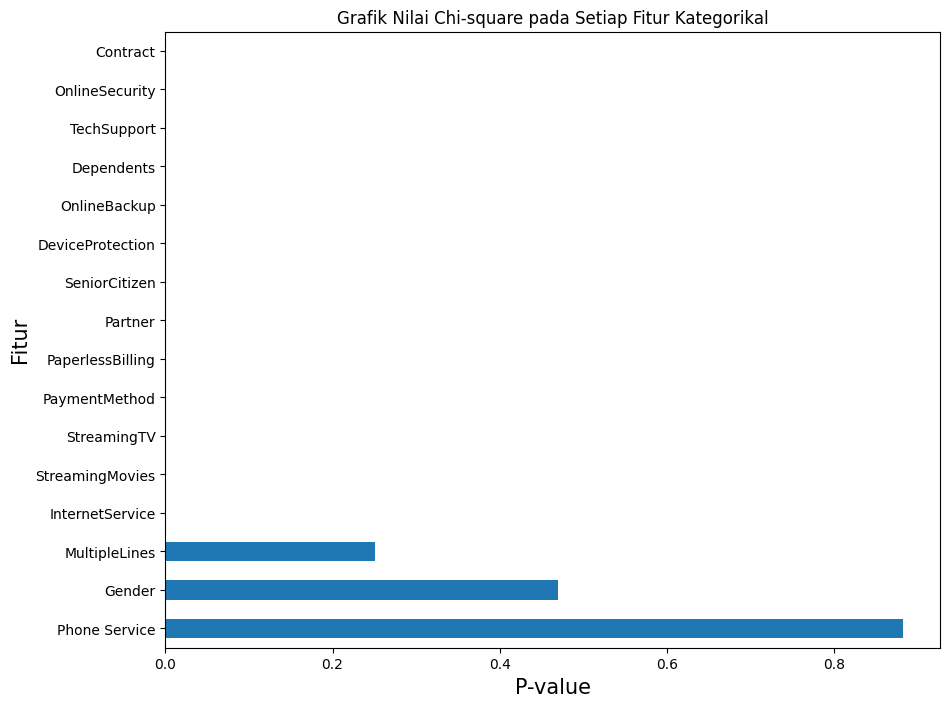

In [87]:
plt.figure(figsize=(10,8))
plt.title('Grafik Nilai Chi-square pada Setiap Fitur Kategorikal')
p_values.plot.barh()
plt.xlabel('P-value',size=15)
plt.ylabel('Fitur',size=15)
plt.savefig('Grafik Nilai Chi-square pada Setiap Fitur Kategorikal.jpg',dpi=300)
plt.show()

In [ ]:
numericals_uji = list(set(df_observation.columns.tolist()) - set(categoricals_uji)) + list(set(categoricals_uji) - set(df_observation.columns.tolist()))
numericals_uji

['TotalCharges', 'TenureMonths', 'MonthlyCharges']

Fitur yang bersifat numerik juga dilakukan seleksi fitur dengan metode analisa hasil perhitungan General Linear Model.

In [ ]:
df_observation

Gender SeniorCitizen Partner Dependents  TenureMonths Phone Service  \
0       Male            No      No         No             2           Yes   
1     Female            No      No        Yes             2           Yes   
2     Female            No      No        Yes             8           Yes   
3     Female            No     Yes        Yes            28           Yes   
4       Male            No      No        Yes            49           Yes   
...      ...           ...     ...        ...           ...           ...   
7038  Female            No      No         No            72           Yes   
7039    Male            No     Yes        Yes            24           Yes   
7040  Female            No     Yes        Yes            72           Yes   
7041  Female            No     Yes        Yes            11            No   
7042    Male            No      No         No            66           Yes   

         MultipleLines InternetService       OnlineSecurity  \
0                   No             DSL                  Yes   
1                   No     Fiber optic                   No   
2                  Yes     Fiber optic                   No   
3                  Yes     Fiber optic                   No   
4                  Yes     Fiber optic                   No   
...                ...             ...                  ...   
7038                No              No  No internet service   
7039               Yes             DSL                  Yes   
7040               Yes     Fiber optic                   No   
7041  No phone service             DSL                  Yes   
7042                No     Fiber optic                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
0                     Yes                   No                   No   
1                      No                   No                   No   
2                      No                  Yes                   No   
3                      No                  Yes                  Yes   
4                     Yes                  Yes                   No   
...                   ...                  ...                  ...   
7038  No internet service  No internet service  No internet service   
7039                   No                  Yes                  Yes   
7040                  Yes                  Yes                   No   
7041                   No                   No                   No   
7042                   No                  Yes                  Yes   

              StreamingTV      StreamingMovies        Contract  \
0                      No                   No  Month-to-month   
1                      No                   No  Month-to-month   
2                     Yes                  Yes  Month-to-month   
3                     Yes                  Yes  Month-to-month   
4                     Yes                  Yes  Month-to-month   
...                   ...                  ...             ...   
7038  No internet service  No internet service        Two year   
7039                  Yes                  Yes        One year   
7040                  Yes                  Yes        One year   
7041                   No                   No  Month-to-month   
7042                  Yes                  Yes        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges  \
0                 Yes               Mailed check           53.85   
1                 Yes           Electronic check           70.70   
2                 Yes           Electronic check           99.65   
3                 Yes           Electronic check          104.80   
4                 Yes  Bank transfer (automatic)          103.70   
...               ...                        ...             ...   
7038              Yes  Bank transfer (automatic)           21.15   
7039              Yes               Mailed check           84.80   
7040              Yes    Credit card (automatic)          103.20  

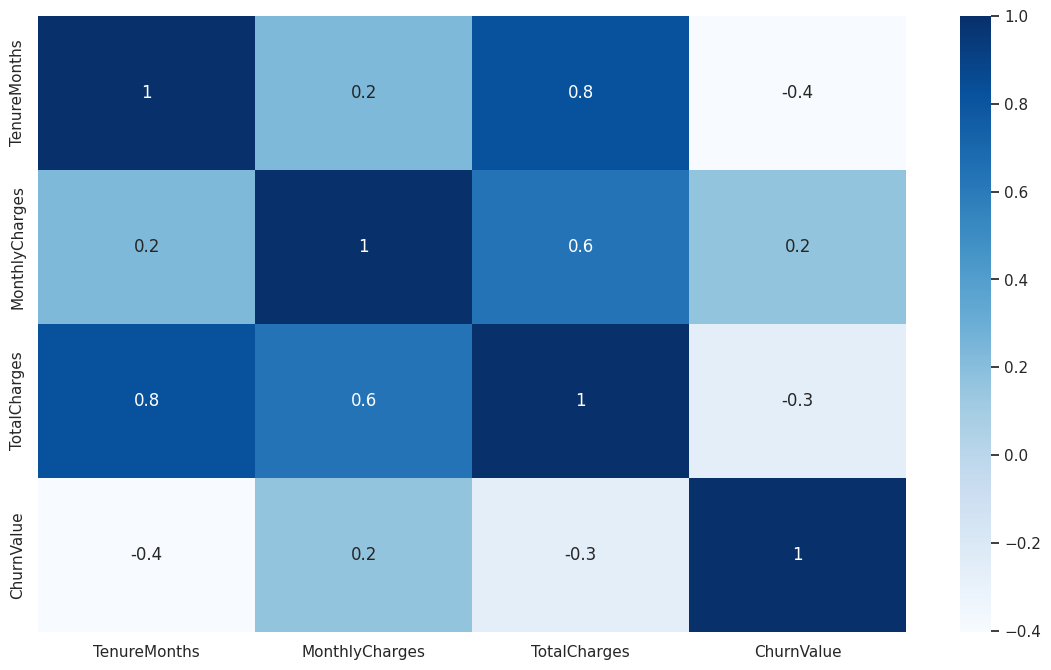

In [ ]:
#Person Correlation
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df_observation.corr() #drop(columns='ChurnValue').corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

In [ ]:
# Uji korelasi dengan General Linear Model
model_uji = sm.GLM.from_formula("ChurnValue ~ TotalCharges + MonthlyCharges + TenureMonths", family=sm.families.Binomial(), data=df_observation)
result_uji = model_uji.fit()
print(result_uji.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             ChurnValue   No. Observations:                 6930
Model:                            GLM   Df Residuals:                     6926
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2928.1
Date:                Thu, 22 Jun 2023   Deviance:                       5856.3
Time:                        05:07:47   Pearson chi2:                 6.63e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2495
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.8662      0.119    -15.

In [ ]:
result_uji.pvalues

Intercept         1.206641e-55
TotalCharges      1.439678e-03
MonthlyCharges    1.183014e-89
TenureMonths      1.012170e-19
dtype: float64

In [ ]:
glm_result = pd.DataFrame({'p-value':abs(result_uji.pvalues.values)},index=result_uji.pvalues.index)
glm_result

p-value
Intercept       1.206641e-55
TotalCharges    1.439678e-03
MonthlyCharges  1.183014e-89
TenureMonths    1.012170e-19

H(0) = tidak terdapat hubungan antara fitur dengan target

H(a) = terdapat hubungan antara fitur dengan target

*p-value* > 0.05 maka H(0) diterima

Dari grafik di atas didapatkan kesimpulan bahwa pada fitur "Phone Service", "Multiplelines", dan "Gender" tidak terdapat hubungan terhadap target, dikarenakan nilai *p-value* > 0.05 sehingga, memiliki alasan untuk menerima H(0). Maka dari itu, fitur tersebut tidak dimasukan ke dalam proses *machine learning*.

Pada hasil pengujian korelasi dengan menggunakan GLM didapatkan kesimpulan bahwa pada fitur "Total Charge", "Tenure Months", dan "Monthly Charges" memiliki *p-vaalue* < 0.05 sehingga, memiliki alasan untuk menerima H(a). Maka dari itu, fitur ini dimasukan kedalam proses *machine learning*  


## Data Original (X_train)

In [ ]:
# Label encoder dan scaler
d_le = defaultdict(LabelEncoder)
mms = MinMaxScaler()

df_data = df_observation.copy()
# Seleksi Fitur
df_data = df_data.drop(columns=['Gender','Phone Service','MultipleLines'])


'''
Menghilangkan fitur yang kurang relevansinya dengan target,
untuk fitur numerik 'Monthly Charges' akan dihilangkan
sedangkan pada fitur kategorikal fitur 'Gender' dan 'Phone Service'
akan dihilangkan.
'''
x_data = df_data.drop('ChurnValue',axis=1)
y_data = df_data['ChurnValue']

# X_train digunakan untuk data pelatihan pada proses augmentasi
# data dan proses pelatihan dengan data yang tidak seimbang
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

#
categoricals_data =  find_categorical(X_train, cutoff=5)
numericals_data = list(set(X_train.columns.tolist()) - set(categoricals_data))+\
                  list(set(categoricals_data) - set(X_train.columns.tolist()))

X_train[categoricals_data] = X_train[categoricals_data].apply(lambda x: d_le[x.name].fit_transform(x))
X_test[categoricals_data] = X_test[categoricals_data].apply(lambda x: d_le[x.name].transform(x))

X_train[numericals_data] = X_train[numericals_data].values.reshape(-1,X_train[numericals_data].shape[1]).astype('float32')

X_train[numericals_data] = mms.fit_transform(X_train[numericals_data].values.reshape(-1,X_train[numericals_data].shape[1]))
X_test[numericals_data] = mms.transform(X_test[numericals_data].values.reshape(-1,X_test[numericals_data].shape[1]))

X_train = pd.concat([X_train[categoricals_data],X_train[numericals_data]], join = 'outer', axis = 1)
X_test = pd.concat([X_test[categoricals_data],X_test[numericals_data]], join = 'outer', axis = 1)


In [ ]:
d_le

defaultdict(sklearn.preprocessing._label.LabelEncoder,
            {'SeniorCitizen': LabelEncoder(),
             'Partner': LabelEncoder(),
             'Dependents': LabelEncoder(),
             'InternetService': LabelEncoder(),
             'OnlineSecurity': LabelEncoder(),
             'OnlineBackup': LabelEncoder(),
             'DeviceProtection': LabelEncoder(),
             'TechSupport': LabelEncoder(),
             'StreamingTV': LabelEncoder(),
             'StreamingMovies': LabelEncoder(),
             'Contract': LabelEncoder(),
             'PaperlessBilling': LabelEncoder(),
             'PaymentMethod': LabelEncoder()})

In [ ]:
# Distribusi kelas pada kolom "Churn Label"
y_train.value_counts()

0    4139
1    1405
Name: ChurnValue, dtype: int64

In [ ]:
X_train

SeniorCitizen  Partner  Dependents  InternetService  OnlineSecurity  \
6905              0        1           0                0               0   
4619              0        0           0                2               1   
364               0        0           0                0               0   
6117              0        1           1                0               0   
132               0        0           0                1               0   
...             ...      ...         ...              ...             ...   
5628              0        1           1                0               2   
4812              1        0           0                1               0   
1689              0        0           0                2               1   
6189              0        0           0                0               0   
5713              0        0           0                0               2   

      OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
6905             0                 2            0            2   
4619             1                 1            1            1   
364              0                 2            0            2   
6117             2                 2            2            2   
132              0                 2            2            2   
...            ...               ...          ...          ...   
5628             2                 2            2            2   
4812             0                 2            0            2   
1689             1                 1            1            1   
6189             0                 0            0            0   
5713             2                 2            2            0   

      StreamingMovies  Contract  PaperlessBilling  PaymentMethod  \
6905                2         0                 0              1   
4619                1         2                 1              1   
364                 2         1                 1              3   
6117                2         2                 1              0   
132                 2         0                 0              0   
...               ...       ...               ...            ...   
5628                2         2                 0              0   
4812                2         0                 1              2   
1689                1         0                 0              3   
6189                0         0                 1              3   
5713                0         2                 0              0   

      TotalCharges  TenureMonths  MonthlyCharges  
6905      0.014901      0.027778        0.504235  
4619      0.136683      0.861111        0.016442  
364       0.037967      0.069444        0.514200  
6117      0.645113      0.958333        0.633283  
132       0.475305      0.555556        0.860987  
...            ...           ...             ...  
5628      0.721659      0.986111        0.682113  
4812      0.464217      0.541667        0.810663  
1689      0.000179      0.013889        0.019930  
6189      0.002906      0.013889        0.255107  
5713      0.265202      0.513889        0.470354  

[5544 rows x 16 columns]

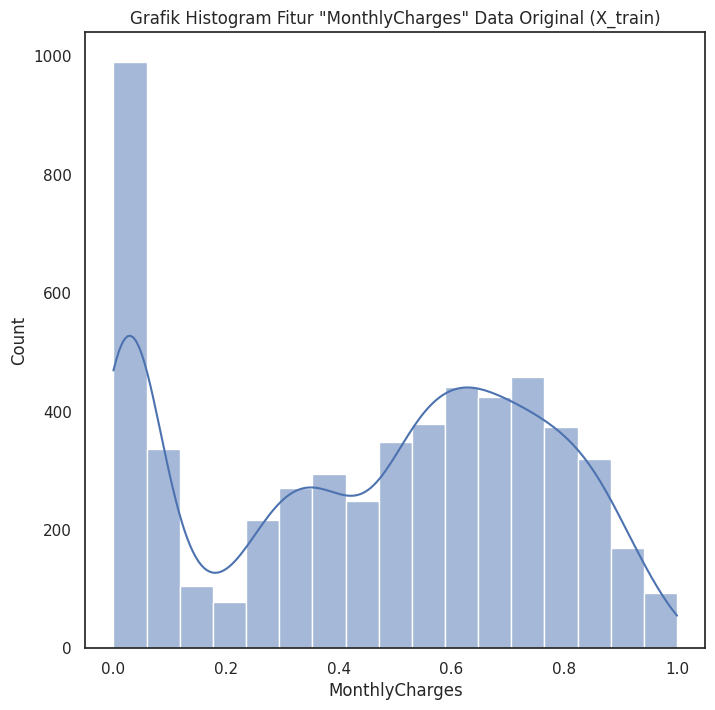

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Grafik Histogram Fitur "MonthlyCharges" Data Original (X_train)')
sns.histplot(X_train['MonthlyCharges'],kde=True, bins='doane')
plt.show()

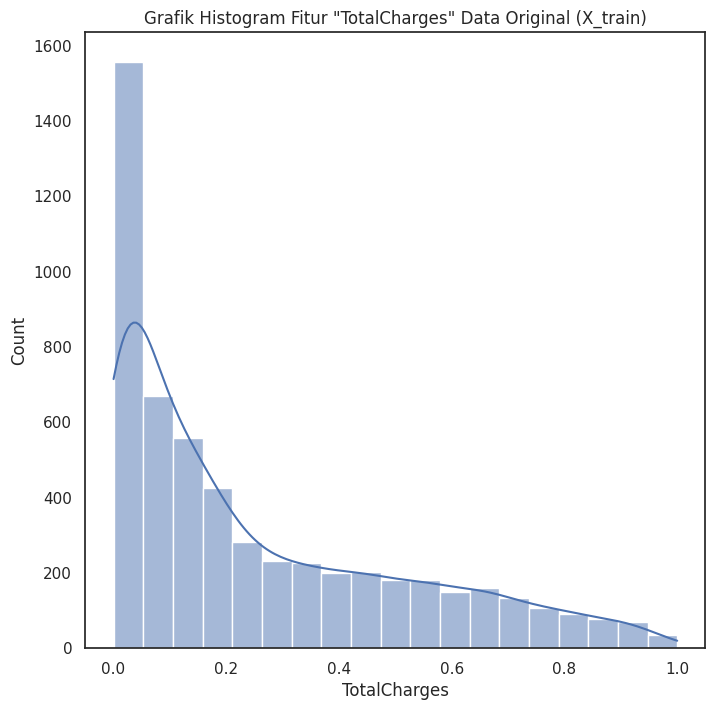

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Grafik Histogram Fitur "TotalCharges" Data Original (X_train)')
sns.histplot(X_train['TotalCharges'],kde=True, bins='doane')
plt.show()

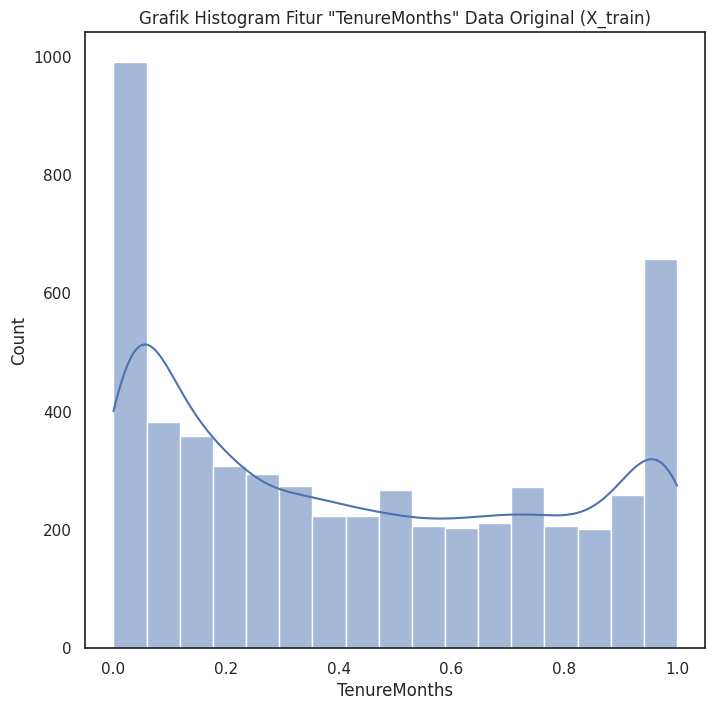

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Grafik Histogram Fitur "TenureMonths" Data Original (X_train)')
sns.histplot(X_train['TenureMonths'],kde=True, bins='doane')
plt.show()

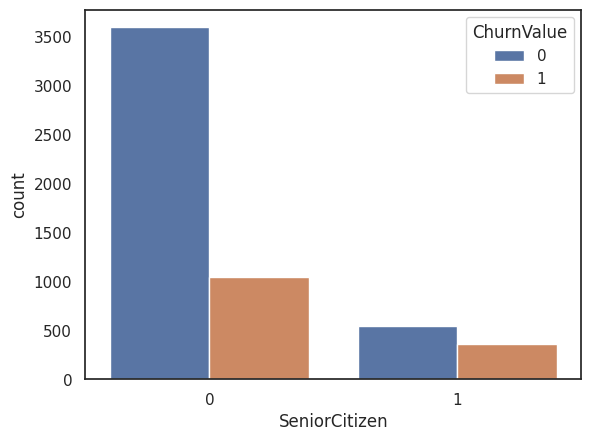

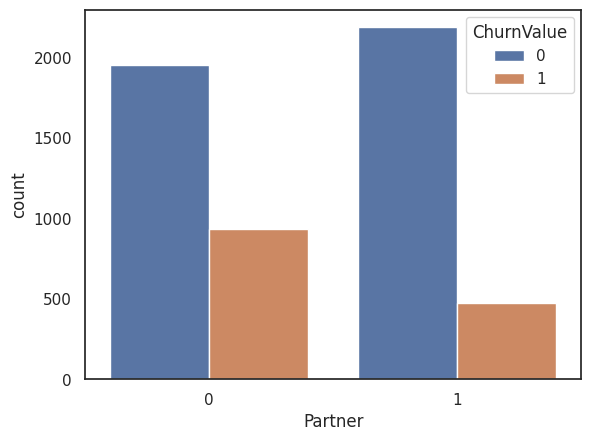

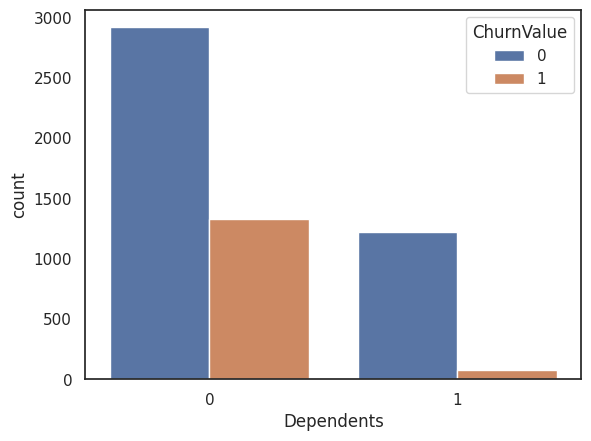

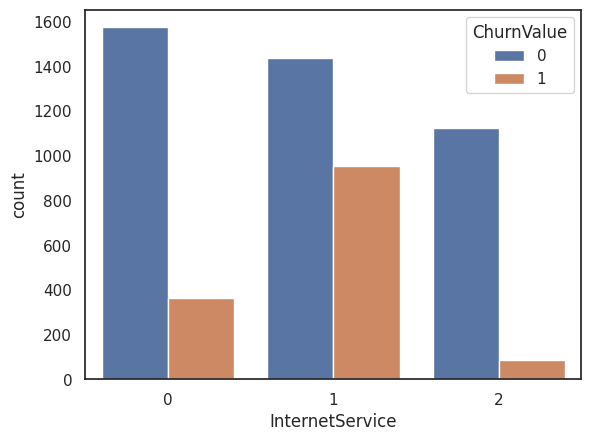

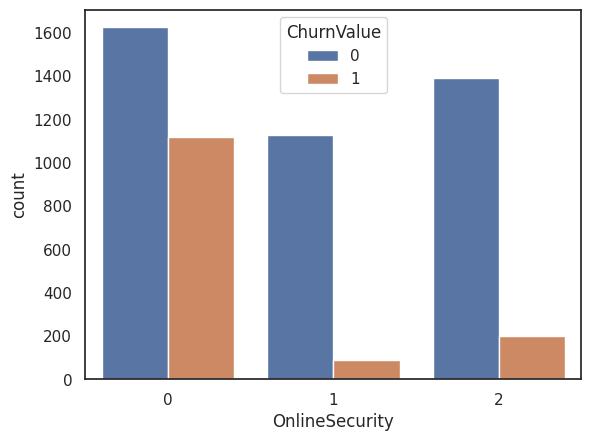

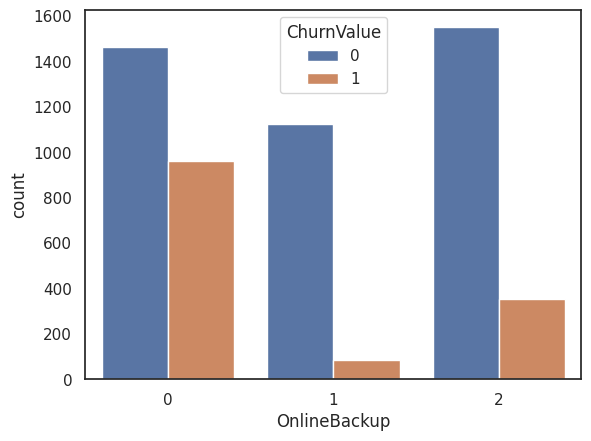

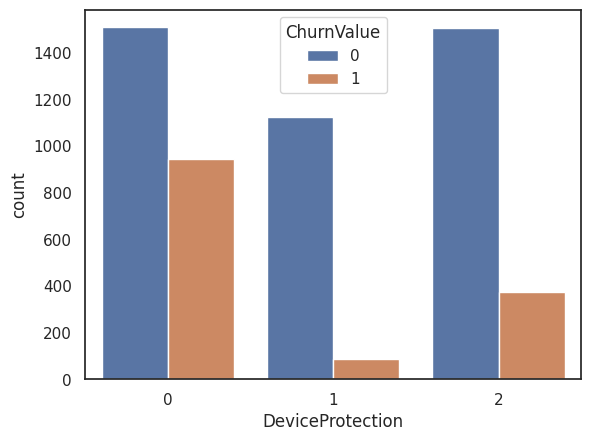

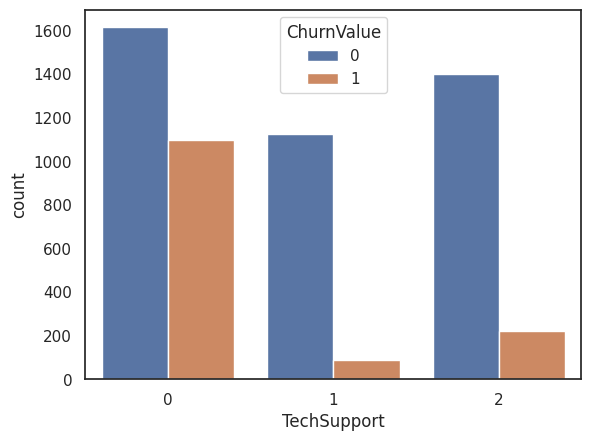

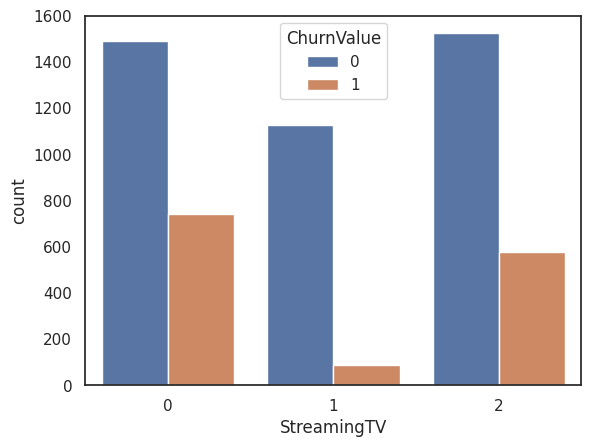

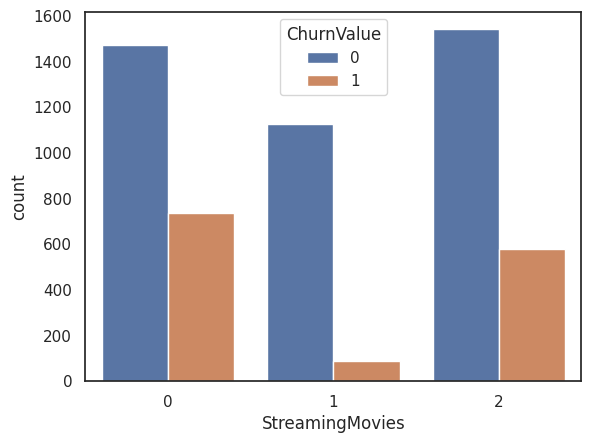

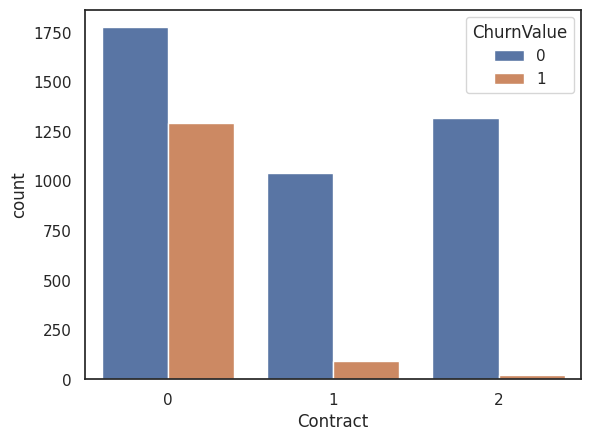

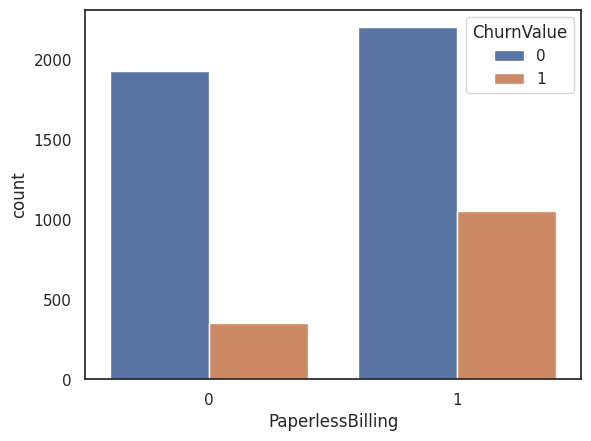

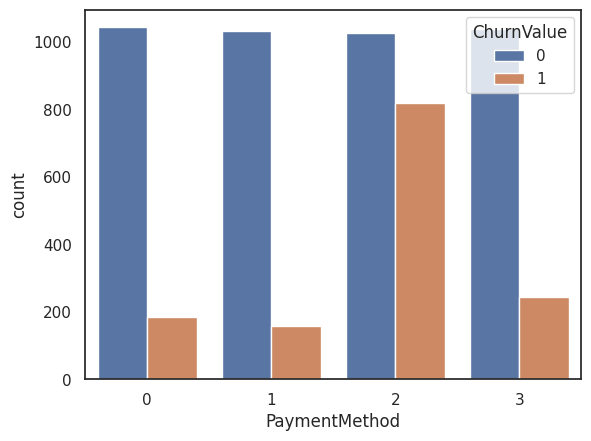

In [ ]:
for col in [uji for uji in categoricals_uji if uji not in ['ChurnValue','Gender', 'Phone Service', 'MultipleLines']]:
  plt.figure()
  sns.countplot(x=X_train[col],hue=y_train)
  plt.show()

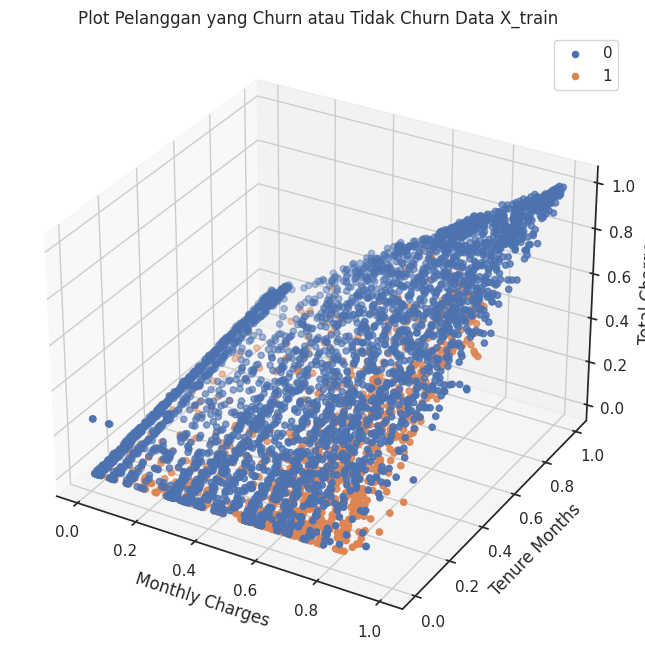

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
plt.title('Plot Pelanggan yang Churn atau Tidak Churn Data X_train')
for c in [0,1]: #df_over.ChurnValue.unique():
  ax.scatter(X_train.MonthlyCharges[y_train==c],X_train.TenureMonths[y_train==c], X_train.TotalCharges[y_train==c], label=c)
ax.set_xlabel('Monthly Charges')
ax.set_ylabel('Tenure Months')
ax.set_zlabel('Total Charges')
ax.legend()
plt.savefig('Plot Pelanggan yang Churn atau Tidak Churn Data X_train.jpg',dpi=300)

# Data Augmentation

## SMOTE

In [ ]:
start_time = time.time()
smote = SMOTENC(categorical_features=[0,1,2,4,5,6,7,8,9,10,11,12,13],sampling_strategy ='minority',random_state=42)
x_over, y_over = smote.fit_resample(X_train,y_train)
s_smote = (time.time() - start_time)
print("\n\n\n>>>>>>>>> %s seconds " % s_smote)




>>>>>>>>> 2.558056354522705 seconds 


In [ ]:
counter = Counter(y_over)
print(counter)

Counter({0: 4139, 1: 4139})


In [ ]:
df_over = pd.concat([x_over, y_over], join = 'outer', axis = 1)
df_over.to_csv('df_over.csv',index_label=False)
df_over

SeniorCitizen  Partner  Dependents  InternetService  OnlineSecurity  \
0                 0        0           0                0               0   
1                 0        1           1                1               2   
2                 0        1           1                0               2   
3                 0        1           0                0               0   
4                 0        1           1                0               0   
...             ...      ...         ...              ...             ...   
8273              0        1           0                1               0   
8274              0        0           0                1               0   
8275              0        1           0                1               0   
8276              0        0           0                1               0   
8277              0        0           0                0               0   

      OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
0                0                 2            0            2   
1                0                 0            0            0   
2                2                 0            2            0   
3                2                 2            0            2   
4                0                 0            0            0   
...            ...               ...          ...          ...   
8273             0                 2            0            0   
8274             0                 2            0            2   
8275             0                 0            0            2   
8276             0                 0            0            0   
8277             0                 0            0            0   

      StreamingMovies  Contract  PaperlessBilling  PaymentMethod  \
0                   2         0                 0              2   
1                   0         0                 0              3   
2                   0         2                 0              3   
3                   2         2                 1              1   
4                   0         0                 0              2   
...               ...       ...               ...            ...   
8273                0         0                 1              0   
8274                2         0                 1              2   
8275                2         0                 1              2   
8276                0         0                 1              2   
8277                0         0                 1              0   

      MonthlyCharges  TenureMonths  TotalCharges  ChurnValue  
0           0.306926      0.486111      0.195934           0  
1           0.565022      0.208333      0.132594           0  
2           0.220727      0.180556      0.067975           0  
3           0.549078      0.361111      0.219429           0  
4           0.260588      0.013889      0.005130           0  
...              ...           ...           ...         ...  
8273        0.513702      0.117724      0.070818           1  
8274        0.828600      0.166667      0.126931           1  
8275        0.803687      0.699969      0.553055           1  
8276        0.568510      0.027153      0.016154           1  
8277        0.268062      0.013889      0.005176           1  

[8278 rows x 17 columns]

In [ ]:
df_over.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TenureMonths', 'TotalCharges',
       'ChurnValue'],
      dtype='object')

In [ ]:
for col in [uji for uji in categoricals_uji if uji not in ['ChurnValue','Gender', 'Phone Service', 'MultipleLines']]:
  plt.figure()
  sns.countplot(x=df_over[col],hue=df_over['ChurnValue'])
  plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Grafik Histogram Fitur "Monthly Charges" Data SMOTE')
sns.histplot(df_over['MonthlyCharges'],kde=True, bins='doane')
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Grafik Histogram Fitur "Total Charges" Data SMOTE')
sns.histplot(df_over['TotalCharges'],kde=True, bins='doane')
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Grafik Histogram Fitur "Tenure Months" Data SMOTE')
sns.histplot(df_over['TenureMonths'],kde=True, bins='doane')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
plt.title('Plot Pelanggan yang Churn atau Tidak Churn \n Setelah Augmentasi dengan SMOTE')
for c in [0,1]: #df_over.ChurnValue.unique():
  ax.scatter(df_over.MonthlyCharges[df_over.ChurnValue==c],df_over.TenureMonths[df_over.ChurnValue==c],df_over.TotalCharges[df_over.ChurnValue==c], label=c)
ax.set_xlabel('Monthly Charges')
ax.set_ylabel('Tenure Months')
ax.set_zlabel('Total Charges')
ax.legend()
plt.savefig('Plot Pelanggan yang Churn atau Tidak Churn Setelah Augmentasi dengan SMOTE.jpg',dpi=300)

In [ ]:
df_over = pd.read_csv('/content/df_over.csv')

In [ ]:
x_over = df_over.drop(columns='ChurnValue')
y_over = df_over['ChurnValue']

## Data Augmentasi (HAT)

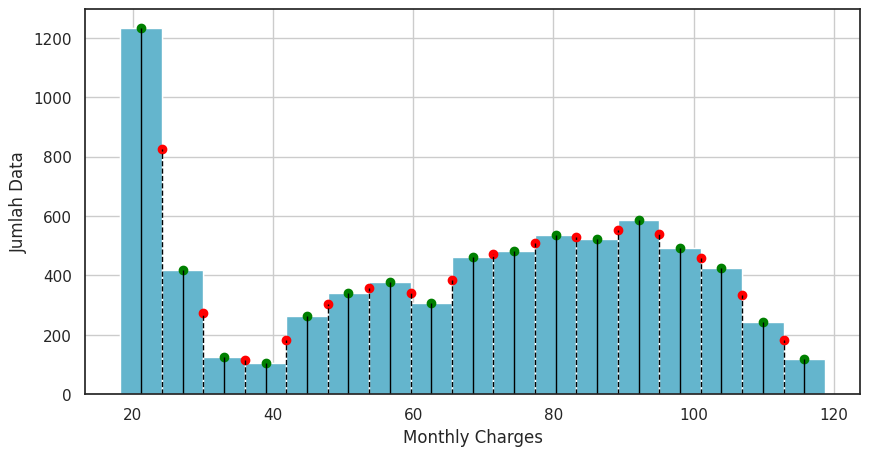

In [ ]:
tmp = []
tmp_average = []
bin_n = np.array([ 24.16176471,  30.07352941,  35.98529412,  41.89705882,
        47.80882353,  53.72058824,  59.63235294,  65.54411765,
        71.45588235,  77.36764706,  83.27941176,  89.19117647,
        95.10294118, 101.01470588, 106.92647059, 112.83823529])

#

n_ = np.array([(1235.+419.)/2, (419.+127.)/2, (127.+104.)/2, (104.+264.)/2, (264.+341.)/2, (341.+378.)/2, (378.+307.)/2, (307.+463.)/2, (463.+482)/2,
        (482.+535.)/2, (535.+522.)/2, (522.+587.)/2, (587.+491.)/2, (491.+425.)/2, (425.+243.)/2, (243.+120.)/2])

bin_range = np.histogram_bin_edges(df_observation['MonthlyCharges'], bins='doane')

for i, value in enumerate(bin_range):
  tmp.append(np.array(bin_range[i:i+2]))

tmp = np.delete(tmp,17)

for i, val in enumerate(tmp):
  tmp_average.append(np.average(tmp[i]))

plt.figure(figsize=(10,5))
plt.xlabel('Monthly Charges')
plt.ylabel('Jumlah Data')
plt.hist(df_observation['MonthlyCharges'],bins='doane',color='c')
n, bin, pat =plt.hist(df_observation['MonthlyCharges'],bins='doane',color='c')
plt.vlines(x=tmp_average,ymin=0, ymax=n, color='black', linestyle='solid', linewidth=1)
plt.vlines(x=bin_n,ymin=0, ymax=n_, color='black', linestyle='dashed', linewidth=1)
plt.scatter(tmp_average, n , color="green")
plt.scatter(bin_n, n_ , color="red")
plt.grid()
plt.savefig('value selection.png',dpi=300)
plt.show()


In [ ]:
df_aug = pd.concat([X_train, y_train], join = 'outer', axis = 1)
#df_aug.to_csv('df_aug.csv',index_label=False)
df_aug

SeniorCitizen  Partner  Dependents  InternetService  OnlineSecurity  \
4626              0        0           0                0               0   
4192              0        1           1                1               2   
5457              0        1           1                0               2   
4717              0        1           0                0               0   
4673              0        1           1                0               0   
...             ...      ...         ...              ...             ...   
6507              0        1           0                1               0   
1646              0        0           0                0               0   
1222              1        0           0                1               2   
3870              0        1           0                2               1   
6017              0        0           0                2               1   

      OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
4626             0                 2            0            2   
4192             0                 0            0            0   
5457             2                 0            2            0   
4717             2                 2            0            2   
4673             0                 0            0            0   
...            ...               ...          ...          ...   
6507             2                 2            2            2   
1646             0                 0            0            0   
1222             2                 0            0            2   
3870             1                 1            1            1   
6017             1                 1            1            1   

      StreamingMovies  Contract  PaperlessBilling  PaymentMethod  \
4626                2         0                 0              2   
4192                0         0                 0              3   
5457                0         2                 0              3   
4717                2         2                 1              1   
4673                0         0                 0              2   
...               ...       ...               ...            ...   
6507                2         2                 0              2   
1646                0         0                 0              0   
1222                2         0                 1              3   
3870                1         1                 0              1   
6017                1         0                 0              3   

      MonthlyCharges  TenureMonths  TotalCharges  ChurnValue  
4626        0.306926      0.486111      0.195934           0  
4192        0.565022      0.208333      0.132594           0  
5457        0.220727      0.180556      0.067975           0  
4717        0.549078      0.361111      0.219429           0  
4673        0.260588      0.013889      0.005130           0  
...              ...           ...           ...         ...  
6507        0.905331      0.986111      0.887493           0  
1646        0.275536      0.027778      0.009252           1  
1222        0.841056      0.347222      0.306305           1  
3870        0.019930      0.333333      0.055591           0  
6017        0.022422      0.083333      0.012585           0  

[5634 rows x 17 columns]

In [ ]:
df_aug_viz = df_aug.copy()

In [ ]:
df_aug_viz[numericals_data] = np.round_(mms.inverse_transform(np.array(df_aug_viz[numericals_data].values.reshape(-1,df_aug_viz[numericals_data].shape[1]))),decimals=2)

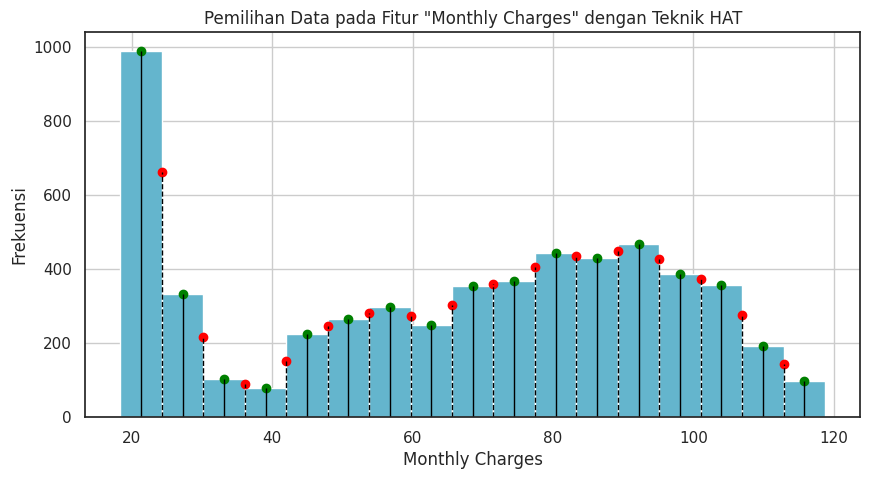

In [ ]:
counts_mc = np.histogram(df_aug_viz['MonthlyCharges'],bins='doane')
n_mc = counts_mc[0]
bin_mc = counts_mc[1]
tmp_average_mc = []
n_mc_ = []

for i in range(len(n_mc)):
  n_mc_.append(np.average(np.array(n_mc[i:i+2])))

for i in range(len(bin_mc)):
  tmp_average_mc.append(np.average(np.array(bin_mc[i:i+2])))

tmp_average_mc = np.delete(tmp_average_mc,17)
n_mc_ = np.delete(n_mc_,16)

plt.figure(figsize=(10,5))
plt.title('Pemilihan Data pada Fitur "Monthly Charges" dengan Teknik HAT')
plt.xlabel('Monthly Charges')
plt.ylabel('Frekuensi')
plt.hist(df_aug_viz['MonthlyCharges'],bins='doane',color='c')
plt.vlines(x=tmp_average_mc, ymin=0, ymax=n_mc, color='black', linestyle='solid', linewidth=1)
plt.vlines(x=bin_mc[1:17], ymin=0, ymax=n_mc_, color='black', linestyle='dashed', linewidth=1)
plt.scatter(tmp_average_mc, n_mc , color="green")
plt.scatter(bin_mc[1:17], n_mc_ , color="red")
plt.grid()
plt.savefig('Pemilihan data Monthlycharge.png',dpi=300)
plt.show()

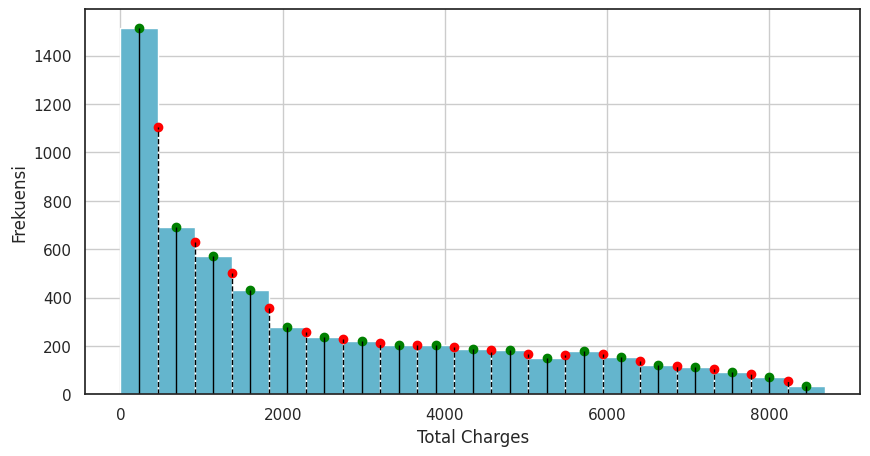

In [ ]:
counts_tc = np.histogram(df_aug_viz['TotalCharges'],bins='doane')
n_tc = counts_tc[0]
bin_tc = counts_tc[1]
tmp_average_tc = []
n_tc_ = []

for i in range(len(n_tc)):
  n_tc_.append(np.average(np.array(n_tc[i:i+2])))

for i in range(len(bin_tc)):
  tmp_average_tc.append(np.average(np.array(bin_tc[i:i+2])))

tmp_average_tc = np.delete(tmp_average_tc,19)
n_tc_ = np.delete(n_tc_,18)

plt.figure(figsize=(10,5))
plt.xlabel('Total Charges')
plt.ylabel('Frekuensi')
plt.hist(df_aug_viz['TotalCharges'],bins='doane',color='c')
plt.vlines(x=tmp_average_tc, ymin=0, ymax=n_tc, color='black', linestyle='solid', linewidth=1)
plt.vlines(x=bin_tc[1:19], ymin=0, ymax=n_tc_, color='black', linestyle='dashed', linewidth=1)
plt.scatter(tmp_average_tc, n_tc , color="green")
plt.scatter(bin_tc[1:19], n_tc_ , color="red")
plt.grid()
plt.savefig('Pemilihan data Totalcharge.png',dpi=300)
plt.show()

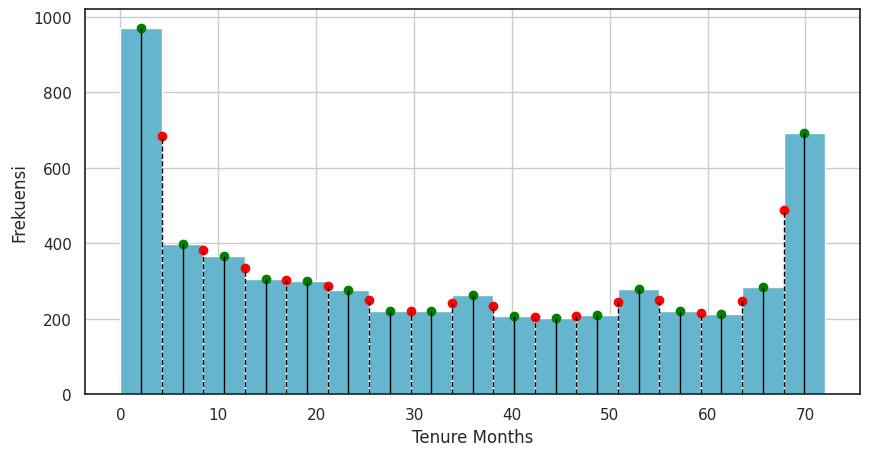

In [ ]:
counts_tn = np.histogram(df_aug_viz['TenureMonths'],bins='doane')
n_tn = counts_tn[0]
bin_tn = counts_tn[1]
tmp_average_tn = []
n_tn_ = []

for i in range(len(n_tn)):
  n_tn_.append(np.average(np.array(n_tn[i:i+2])))

for i in range(len(bin_tn)):
  tmp_average_tn.append(np.average(np.array(bin_tn[i:i+2])))

tmp_average_tn = np.delete(tmp_average_tn,17)
n_tn_ = np.delete(n_tn_,16)

plt.figure(figsize=(10,5))
plt.xlabel('Tenure Months')
plt.ylabel('Frekuensi')
plt.hist(df_aug_viz['TenureMonths'],bins='doane',color='c')
plt.vlines(x=tmp_average_tn, ymin=0, ymax=n_tn, color='black', linestyle='solid', linewidth=1)
plt.vlines(x=bin_tn[1:17], ymin=0, ymax=n_tn_, color='black', linestyle='dashed', linewidth=1)
plt.scatter(tmp_average_tn, n_tn , color="green")
plt.scatter(bin_tn[1:17], n_tn_ , color="red")
plt.grid()
plt.savefig('Pemilihan data TenureMonths.png',dpi=300)
plt.show()

In [ ]:
df_aug

SeniorCitizen  Partner  Dependents  InternetService  OnlineSecurity  \
4626              0        0           0                0               0   
4192              0        1           1                1               2   
5457              0        1           1                0               2   
4717              0        1           0                0               0   
4673              0        1           1                0               0   
...             ...      ...         ...              ...             ...   
6507              0        1           0                1               0   
1646              0        0           0                0               0   
1222              1        0           0                1               2   
3870              0        1           0                2               1   
6017              0        0           0                2               1   

      OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
4626             0                 2            0            2   
4192             0                 0            0            0   
5457             2                 0            2            0   
4717             2                 2            0            2   
4673             0                 0            0            0   
...            ...               ...          ...          ...   
6507             2                 2            2            2   
1646             0                 0            0            0   
1222             2                 0            0            2   
3870             1                 1            1            1   
6017             1                 1            1            1   

      StreamingMovies  Contract  PaperlessBilling  PaymentMethod  \
4626                2         0                 0              2   
4192                0         0                 0              3   
5457                0         2                 0              3   
4717                2         2                 1              1   
4673                0         0                 0              2   
...               ...       ...               ...            ...   
6507                2         2                 0              2   
1646                0         0                 0              0   
1222                2         0                 1              3   
3870                1         1                 0              1   
6017                1         0                 0              3   

      MonthlyCharges  TenureMonths  TotalCharges  ChurnValue  
4626        0.306926      0.486111      0.195934           0  
4192        0.565022      0.208333      0.132594           0  
5457        0.220727      0.180556      0.067975           0  
4717        0.549078      0.361111      0.219429           0  
4673        0.260588      0.013889      0.005130           0  
...              ...           ...           ...         ...  
6507        0.905331      0.986111      0.887493           0  
1646        0.275536      0.027778      0.009252           1  
1222        0.841056      0.347222      0.306305           1  
3870        0.019930      0.333333      0.055591           0  
6017        0.022422      0.083333      0.012585           0  

[5634 rows x 17 columns]

In [ ]:
cs = ['d','d','d','d','d','d','d','d','d','d','d','d','d','d','c','c','d']

In [ ]:
'''
Authors: Balachander S, Yogesh Chandra Singh Samant, Prahalad Srinivas C G, B Varshin Hariharan
'''
import time

def histogram_sampler(data, no_new_data, data_feat, preserve):

    if (data_feat == 'c'):
        start_time = time.time()
        print('Existing data:', len(data))
        print('New data to be produced:', no_new_data)

        '''Function parameters'''

        '''
        X_new = New data for each iteration
        len_X_new = length of the newly generated data
        iter_count = no. of iterations
        data_gen = Augmented data (original data + newly generated data)
        '''
        X_new = []
        len_X_new = len(X_new)
        iter_count = 0
        data_gen = data

        while (len_X_new < 0.7*no_new_data):
            iter_count+=1
            print('-----\niter_count=',iter_count)

            '''
            Histogram: Generating the histogram , choosing the mid-value of the bins, and normalizing frequency
            'fd'- Freedman–Diaconis rule is employed to choose the bin size, as it depends on the spread of the data, without any presumption
            '''

            if(iter_count == 1):
                Y,X_interval=np.histogram(data_gen,bins='doane')
                n_bins = len(Y)

            else:
                Y,X_interval=np.histogram(data_gen,bins=n_bins)

            X = ((X_interval[0:-1] + X_interval[1:])/2)
            Y = Y/max(Y)

            bin_val = list(np.round(X,8))
            weight = list(Y)
            hist = dict(zip(bin_val,weight))

            for xi in bin_val[0:-1]:

                '''
                Values: choosing the values for undergoing validity check
                '''

                bin_width = ((max(bin_val) - min(bin_val)) / int(len(bin_val)-1))
                xm = xi + (bin_width/2)
                x1 = xi
                y1 = hist[xi]

                res = None
                temp = iter(hist)
                for key in temp:
                    if(key == xi):
                        res = next(temp,None)

                y2 = hist[res]
                ym = ((y1+y2)/2)

                '''
                Validity check: checking if the specified value can be considered
                '''

                '''if(no_new_data <= len(data)):
                    ym = ym*(np.random.rand()<=ym)
                    y1 = y1*(np.random.rand()<=y1)
                '''
                #else:
                ym = ym*(abs(np.random.normal(0,0.5))<=ym)
                y1 = y1*(abs(np.random.normal(0,0.5))<=y1)

                '''
                Appending: appending the valid values
                '''

                if (ym!=0):
                    X_new.append(np.round(xm,8))
                    #X_new.append(np.round(xm+0.1*xm,8))
                    #X_new.append(np.round(xm-0.1*xm,8))
                if (y1!=0):
                    X_new.append(np.round(x1,8))
                    #X_new.append(np.round(x1+0.1*xm,8))
                    #X_new.append(np.round(x1-0.1*xm,8))

            '''
            Stopping: bins * 2, length check
            '''

            data_gen = data_gen + X_new
            n_bins = n_bins*2
            len_X_new+= len(X_new)
            print(len_X_new)
            X_new = []
            print("--- %s seconds ---" % (time.time() - start_time))


        print(len(data_gen)-len(data),no_new_data)

        if(len(data_gen)-len(data) >= no_new_data):
            data_gen = data_gen[:len(data)] + list(np.random.choice(data_gen[len(data):], no_new_data, replace = False))
            print('\nNew data generated:', len(data_gen[len(data):]), '\nNew data:', len(data_gen), '\n')
            #sns.distplot(data_gen)
            if(preserve == False):
                data_gen = data_gen[len(data):]
            return data_gen

        else:
            print('to discrete...', no_new_data - (len(data_gen)-len(data)))
            samples = histogram_sampler(data_gen, no_new_data - (len(data_gen)-len(data)), 'd', preserve = True)
            if(preserve == False):
                samples = samples[len(data):]
            return samples



    elif(data_feat == 'd'):
        X_new=[]
        data_gen=[]
        disc_data= list(set(data))

        for i in disc_data:
            x=data.count(i)
            X_new.append(round(x*(no_new_data) / len(data)))
        #print(x_new,sum(x_new))

        for j in range(0,len(X_new)):
            for i in range(X_new[j]):
                data_gen.append(disc_data[j])

        if(len(data_gen)==0):
            data_gen = data + data_gen

        print(no_new_data, sum(X_new))
        if(no_new_data > sum(X_new)):
            data_gen = data + data_gen
            data_gen = list(data_gen + list(np.random.choice(data_gen,int(no_new_data-sum(X_new)),replace = False)))

        data_gen = list(np.random.choice(data_gen,int(no_new_data),replace = False))

        if(preserve == True):
            data_gen = data + data_gen

        #sns.distplot(data_gen)
        print('\nNew data generated:', len(data_gen[len(data):]), '\nNew data:', len(data_gen), '\n')
        return data_gen

    else:
        print('NA')

def label_split(df_class, diff, label_name, cd, label_column, preserve):
    cdi = 0
    df_ = pd.DataFrame(columns=[])
    del df_class[label_column]
    for (columnName, columnData) in df_class.iteritems():
        print(columnName)
        feat_type = cd[cdi]
        df_[columnName] = histogram_sampler(list(columnData.values), diff, feat_type, preserve)
        cdi+=1
    df_[label_column] = label_name
    print(df_)

    return df_

def class_balance(data, label_column, cd, augment = False, preserve = True):
    split_list=[]
    #label_column = 'species'
    for label, df_label in data.groupby(label_column):
        split_list.append(df_label)

    maxLength = max(len(x) for x in split_list)

    if(augment == False):
        augmented_list=[]
        for i in range(0,len(split_list)):

            label_name = list(set(split_list[i][label_column]))[0]
            diff = maxLength - len(split_list[i])
            augmented_list.append(label_split(split_list[i], diff, label_name, cd, label_column, preserve))
        finaldf = pd.DataFrame(columns=[])

    elif(type(augment) == dict):
        augmented_list=[]
        for i in range(0,len(split_list)):

            label_name = list(set(split_list[i][label_column]))[0]
            diff = augment[label_name]
            augmented_list.append(label_split(split_list[i], diff, label_name, cd, label_column, preserve))
        finaldf = pd.DataFrame(columns=[])

    elif(type(augment) == int):

        label_count = dict(Counter(list(df[label_column])))
        count_key = list(label_count.keys())
        count_val = list(label_count.values())

        for i in range(0,len(count_val)):
            count_val[i] = round(count_val[i] * augment  /sum(list(label_count.values())))


        while(sum(count_val) != augment):
            if(sum(count_val) > augment):
                rand_indx = int(np.random.rand() * len(count_val))
                if(count_val[rand_indx] > 0):
                    count_val[rand_indx]-= 1

            else:
                rand_indx = int(np.random.rand() * len(count_val))
                count_val[rand_indx]+= 1

        new_count = dict(zip(count_key, count_val))

        augmented_list=[]
        for i in range(0,len(split_list)):

            label_name = list(set(split_list[i][label_column]))[0]
            diff = new_count[label_name]
            augmented_list.append(label_split(split_list[i], diff, label_name, cd, label_column, preserve))
        finaldf = pd.DataFrame(columns=[])


        #finaldf = class_balance(data, label_column, cd, augment = new_count, preserve = preserve)


    for i in range(0,len(split_list)):
        finaldf = pd.concat([finaldf,augmented_list[i]],axis=0)

    return finaldf

In [ ]:
start_time = time.time()

print(cs)
a_df = class_balance(data=df_aug,label_column='ChurnValue',cd=cs, augment = False, preserve = True)
s_hat = time.time() - start_time
print("\n\n\n>>>>>>>>> %s seconds " % s_hat)
a_df

['d', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'c', 'c', 'd']
SeniorCitizen
0 0

New data generated: 0 
New data: 4139 

Partner
0 0

New data generated: 0 
New data: 4139 

Dependents
0 0

New data generated: 0 
New data: 4139 

InternetService
0 0

New data generated: 0 
New data: 4139 

OnlineSecurity
0 0

New data generated: 0 
New data: 4139 

OnlineBackup
0 0

New data generated: 0 
New data: 4139 

DeviceProtection
0 0

New data generated: 0 
New data: 4139 

TechSupport
0 0

New data generated: 0 
New data: 4139 

StreamingTV
0 0

New data generated: 0 
New data: 4139 

StreamingMovies
0 0

New data generated: 0 
New data: 4139 

Contract
0 0

New data generated: 0 
New data: 4139 

PaperlessBilling
0 0

New data generated: 0 
New data: 4139 

PaymentMethod
0 0

New data generated: 0 
New data: 4139 

MonthlyCharges
0 0

New data generated: 0 
New data: 4139 

TenureMonths
Existing data: 4139
New data to be produced: 0
0 0

New data generated: 0 
New dat

KeyboardInterrupt: ignored

In [ ]:
a_df

In [ ]:
# 615.8795168399811
a_df.reset_index(drop=True)

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Grafik Histogram Fitur "Tenure Months" Dengan Teknik HAT')
sns.histplot(a_df['TenureMonths'],kde=True, bins='doane')
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Grafik Histogram Fitur "Total Charges" Dengan Teknik HAT')
sns.histplot(a_df['TotalCharges'],kde=True, bins='doane')
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Grafik Histogram Fitur "MonthlyCharges" Dengan Teknik HAT')
sns.histplot(a_df['MonthlyCharges'],kde=True, bins='doane')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
plt.title('Plot Pelanggan yang Churn atau Tidak Churn \n Setelah Augmentasi dengan HAT')
for c in [0,1]: #df_over.ChurnValue.unique():
  ax.scatter(a_df.MonthlyCharges[a_df.ChurnValue==c],a_df.TenureMonths[a_df.ChurnValue==c],a_df.TotalCharges[a_df.ChurnValue==c], label=c)
ax.set_xlabel('Monthly Charges')
ax.set_ylabel('Tenure Months')
ax.set_zlabel('Total Charges')
ax.legend()
plt.savefig('Plot Pelanggan yang Churn atau Tidak Churn Setelah Augmentasi dengan HAT.jpg',dpi=300)

In [ ]:
#a_df.to_csv('a_df.csv',index_label=False)

In [ ]:
counter = Counter(a_df['ChurnValue'])
print(counter)

Counter({0: 4139, 1: 4139})


In [ ]:
a_df = pd.read_csv('/content/a_df.csv')

In [ ]:
x_aug = a_df.drop('ChurnValue',axis=1)
y_aug = a_df['ChurnValue']

## CVAE

### New Dataloader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
data = zip(X_train, y_train)

def load_and_standardize_data(data):
  X_train_vae, X_test_vae, y_train_vae, y_test_vae = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
  X_train_vae = X_train_vae.values.astype('float32')
  X_test_vae = X_test_vae.values.astype('float32')
  y_train_vae = y_train_vae.values
  y_test_vae = y_test_vae.values
  return X_train_vae, X_test_vae, y_train_vae, y_test_vae

In [ ]:
data

In [ ]:
x_train_vae, x_test_vae, y_train_vae, y_test_vae = load_and_standardize_data(data)

In [ ]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, path, train=True):
        self.x_train_vae, self.x_test_vae, self.y_train_vae, self.y_test_vae = load_and_standardize_data(data)
        if train:
            self.x = torch.tensor(self.x_train_vae)
            self.len=self.x.shape[0]
            self.y = torch.tensor(self.y_train_vae)
            self.len=self.y.shape[0]
        else:
            self.x = torch.tensor(self.x_test_vae)
            self.len=self.x.shape[0]
            self.y = torch.tensor(self.y_test_vae)
            self.len=self.y.shape[0]

        del self.x_train_vae
        del self.x_test_vae
        del self.y_train_vae
        del self.y_test_vae

    def __getitem__(self,index):
        return self.x[index]
        return self.y[index]

    def __len__(self):
        return self.len

In [ ]:
size = 1386

traindata_set=DataBuilder(data, train=True)
testdata_set=DataBuilder(data, train=False)

trainloader=DataLoader(list(zip(traindata_set.x,traindata_set.y)),batch_size=size)
testloader=DataLoader(list(zip(testdata_set.x,testdata_set.y)),batch_size=size)

In [ ]:
for data, label in testloader:
  print((label))

In [ ]:
x_train_vae.shape

### Model

In [ ]:
N_EPOCHS = 1024           # times to run the model on complete data
INPUT_DIM = 16          # size of each input
H2 = 12
HIDDEN_DIM = 50        # hidden dimension
LATENT_DIM = 3         # latent vector dimension
N_CLASSES = 2          # number of classes in the data
lr = 1e-3               # learning rate

In [ ]:
def idx2onehot(idx, n=N_CLASSES):

    assert idx.shape[1] == 1
    assert torch.max(idx).item() < n

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx.data, 1)

    return onehot


In [ ]:
class Encoder(nn.Module): #Q(z|x, c)
    ''' This the encoder part of VAE
    '''
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        '''
        Args:
            input_dim: A integer indicating the size of input .
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.linear = nn.Linear(input_dim + n_classes, hidden_dim)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim + n_classes]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]

        # latent parameters
        mean = self.mu(hidden)
        # mean is of shape [batch_size, latent_dim]
        log_var = self.var(hidden)
        # log_var is of shape [batch_size, latent_dim]

        return mean, log_var


class Decoder(nn.Module): # P(x|z, c)
    ''' This the decoder part of VAE
    '''
    def __init__(self, latent_dim, hidden_dim, output_dim, n_classes):
        '''
        Args:
            latent_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the size of output
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.latent_to_hidden = nn.Linear(latent_dim + n_classes, hidden_dim)
        self.hidden_to_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim + num_classes]
        x = F.relu(self.latent_to_hidden(x))
        # x is of shape [batch_size, hidden_dim]
        generated_x = F.sigmoid(self.hidden_to_out(x))
        # x is of shape [batch_size, output_dim]

        return generated_x


class CVAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.
    '''
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        '''
        Args:
            input_dim: A integer indicating the size of input.
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, n_classes)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, n_classes)

    def forward(self, x, y):

        x = torch.cat((x, y), dim=1)

        # encode
        z_mu, z_var = self.encoder(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        z = torch.cat((x_sample, y), dim=1)

        # decode
        generated_x = self.decoder(z)

        return generated_x, z_mu, z_var


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, H2 ,latent_dim, n_classes):

        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(input_dim + n_classes, hidden_dim)
        self.lin_bn1 = nn.BatchNorm1d(num_features=hidden_dim)
        self.linear2=nn.Linear(hidden_dim,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        # Sampling vector
        self.fc3 = nn.Linear(latent_dim + n_classes, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)

        # Decoder
        self.linear4 = nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5 = nn.Linear(H2,hidden_dim)
        self.lin_bn5 = nn.BatchNorm1d(num_features=hidden_dim)
        self.linear6 = nn.Linear(hidden_dim,input_dim)
        self.lin_bn6 = nn.BatchNorm1d(num_features=input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)

        return r1, r2

    def reparameterize(self, z_mu, z_var):
        if self.training:
            std = z_var.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(z_mu)
        else:
            return z_mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.sigmoid(self.lin_bn6(self.linear6(lin5)))

    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        z_mu, z_var = self.encode(x)
        x_sample = self.reparameterize(z_mu, z_var)
        z = torch.cat((x_sample, y), dim=1)
        generated_x = self.decode(z)
        return generated_x, z_mu, z_var

In [ ]:
def calculate_loss(x, reconstructed_x, mean, log_var):
    # reconstruction loss
    RCL = F.binary_cross_entropy(reconstructed_x, x, reduction='mean')#, size_average=False)
    # kl divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return RCL + KLD

In [ ]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="mean")

    def forward(self, x, reconstructed_x, mean, log_var):
        loss_MSE = self.mse_loss(reconstructed_x, x)
        loss_KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

        return loss_MSE + loss_KLD

In [ ]:
train_losses = []
test_losses = []
model = CVAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, N_CLASSES)
#model = Autoencoder(INPUT_DIM, HIDDEN_DIM, H2, LATENT_DIM, N_CLASSES)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_mse = customLoss()

In [ ]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, (x, y) in enumerate(trainloader):
        x = x.to(device)

        # convert y into one-hot encoding
        y = idx2onehot(y.view(-1, 1))
        y = y.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        reconstructed_x, z_mu, z_var = model(x, y)

        # loss
        #loss = calculate_loss(x, reconstructed_x, z_mu, z_var)
        loss = loss_mse(x, reconstructed_x, z_mu, z_var)

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()


    return train_loss

In [ ]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, y) in enumerate(testloader):
            # reshape the data
            #x = x.view(-1, 1 * 14)
            x = x.to(device)

            # convert y into one-hot encoding
            y = idx2onehot(y.view(-1, 1))
            y = y.to(device)

            # forward pass
            reconstructed_x, z_mu, z_var = model(x, y)

            # loss
            #loss = calculate_loss(x, reconstructed_x, z_mu, z_var)
            loss = loss_mse(x, reconstructed_x, z_mu, z_var)
            test_loss += loss.item()

    return test_loss

In [ ]:
summary(model,[(16,),(2,)])

In [ ]:
print(model)

In [ ]:
start_time = time.time()

for e in range(N_EPOCHS):

    train_loss = train()
    test_loss = test()

    if e % 100 == 0:
      train_loss /= len(trainloader)
      test_loss /= len(testloader)
      print(f'Epoch {e}, Avg Train Loss: {abs(train_loss):.2f}, Avg Test Loss: {abs(test_loss):.2f}')
      train_losses.append(train_loss / len(trainloader))
      test_losses.append(test_loss/ len(testloader))

s_vae_train = time.time() - start_time
print("\n\n\n>>>>>>>>> %s seconds " % s_vae_train)

In [ ]:
#train_losses.clear()
#test_losses.clear()

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('Nilai Loss pada Training CVAE')
plt.xlabel('Epoch (x100)')
plt.ylabel('Loss')
plt.legend(["Training Loss", "Test Loss"], loc ="upper left")
plt.savefig('Nilai Loss pada Training CVAE.jpg',dpi=300)
plt.show()

In [ ]:
with torch.no_grad():
    for batch_idx, (x,y) in enumerate(testloader):
        x = x.to(device)
        y = idx2onehot(y.view(-1, 1))
        y = y.to(device)
        optimizer.zero_grad()
        reconstructed_x, z_mu, z_var = model(x,y)

In [ ]:
sigma = torch.exp(z_var/2)
n_balance = y_train.value_counts()[0] - y_train.value_counts()[1]
q = torch.distributions.Normal(z_mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([n_balance])).to(device)
z

In [ ]:
y = torch.randint(1,2,(n_balance,))
y = y.view(-1,1)
y_ = idx2onehot(y).to(device, dtype=z.dtype)
y_

In [ ]:
with torch.no_grad():
    y_ = y_.to(device)
    z = torch.cat((z, y_), dim=1)
    pred = model.decoder(z).cpu().numpy()

Plot latent space dengan data latih

In [ ]:
data_train = torch.tensor(x_train_vae)
ydata_train = torch.tensor(y_train_vae)
ydata_train = ydata_train.view(-1,1)
y_lt = idx2onehot(ydata_train).to(device,data_train.dtype)

In [ ]:
with torch.no_grad():
    y_lt = y_lt.to(device)
    x_lt = torch.cat((data_train, y_lt), dim=1)
    z_mu_lt, z_var_lt = model.encoder(x_lt)

In [ ]:
std_lt= torch.exp(z_var_lt / 2)
eps_lt = torch.randn_like(std_lt)
x_sample_lt = eps_lt.mul(std_lt).add_(z_mu_lt).cpu().numpy()
x_sample_lt

In [ ]:
laten_data = pd.DataFrame({'z0':x_sample_lt[:,0],'z1':x_sample_lt[:,1],'z2':x_sample_lt[:,2],'ChurnValue':y_train_vae})
laten_data

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
plt.title('Plot Latent Space dengan Kelas Data')
for c in [0,1]: #df_over.ChurnValue.unique():
  ax.scatter(laten_data.z0[laten_data.ChurnValue==c], laten_data.z1[laten_data.ChurnValue==c], laten_data.z2[laten_data.ChurnValue==c], label=c)
ax.set_xlabel('z0')
ax.set_ylabel('z1')
ax.set_zlabel('z2')
ax.legend()
plt.savefig('Plot Latent Space dengan Kelas Data.jpg',dpi=300)

### Create fake data from Autoencoder

In [ ]:
columns_ = ['SeniorCitizen', 'Partner', 'Dependents','TenureMonths','InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

In [ ]:
df_fake = pd.DataFrame(pred, columns = columns_)
df_fake

In [ ]:
bin_sc = np.histogram_bin_edges(df_fake['SeniorCitizen'],bins=2)
bin_pr = np.histogram_bin_edges(df_fake['Partner'],bins=2)
bin_de = np.histogram_bin_edges(df_fake['Dependents'],bins=2)
bin_is = np.histogram_bin_edges(df_fake['InternetService'],bins=3)
bin_os = np.histogram_bin_edges(df_fake['OnlineSecurity'],bins=3)
bin_ob = np.histogram_bin_edges(df_fake['OnlineBackup'],bins=3)
bin_dp = np.histogram_bin_edges(df_fake['DeviceProtection'],bins=3)
bin_ts = np.histogram_bin_edges(df_fake['TechSupport'],bins=3)
bin_tv = np.histogram_bin_edges(df_fake['StreamingTV'],bins=3)
bin_mv = np.histogram_bin_edges(df_fake['StreamingMovies'],bins=3)
bin_ct = np.histogram_bin_edges(df_fake['Contract'],bins=3)
bin_pb = np.histogram_bin_edges(df_fake['PaperlessBilling'],bins=2)
bin_pm = np.histogram_bin_edges(df_fake['PaymentMethod'],bins=4)

In [ ]:
sns.histplot(df_fake['PaperlessBilling'],bins=2)

In [ ]:
df_fake['SeniorCitizen'] = pd.cut(x=df_fake['SeniorCitizen'], bins=bin_sc,labels=[1,0])
df_fake['Partner'] = pd.cut(x=df_fake['Partner'], bins=bin_pr,labels=[0,1])
df_fake['Dependents'] = pd.cut(x=df_fake['Dependents'], bins=bin_de,labels=[0,1])
df_fake['InternetService'] = pd.cut(x=df_fake['InternetService'], bins=bin_is,labels=[1,0,2])
df_fake['OnlineSecurity'] = pd.cut(x=df_fake['OnlineSecurity'], bins=bin_os,labels=[0,2,1])
df_fake['OnlineBackup'] = pd.cut(x=df_fake['OnlineBackup'], bins=bin_ob,labels=[0,2,1])
df_fake['DeviceProtection'] = pd.cut(x=df_fake['DeviceProtection'], bins=bin_dp,labels=[0,2,1])
df_fake['TechSupport'] = pd.cut(x=df_fake['TechSupport'], bins=bin_ts,labels=[0,2,1])
df_fake['StreamingTV'] = pd.cut(x=df_fake['StreamingTV'], bins=bin_tv,labels=[0,2,1])
df_fake['StreamingMovies'] = pd.cut(x=df_fake['StreamingMovies'], bins=bin_mv,labels=[0,2,1])
df_fake['PaperlessBilling'] = pd.cut(x=df_fake['PaperlessBilling'], bins=bin_pb,labels=[0,1])
df_fake['Contract'] = pd.cut(x=df_fake['Contract'], bins=bin_ct,labels=[0,2,1])
df_fake['PaymentMethod'] = pd.cut(x=df_fake['PaymentMethod'], bins=bin_pm,labels=[0,2,3,1])

In [ ]:
for l in columns_:
  df_fake[l].fillna(df_fake[l].mode()[0],inplace=True)

In [ ]:
#df_fake[categoricals_data] = df_fake[categoricals_data].apply(lambda x: d_le[x.name].inverse_transform(x))
#df_fake[numericals_data] = np.round_(mms.inverse_transform(np.array(df_fake[numericals_data].values.reshape(-1,df_fake[numericals_data].shape[1]))),decimals=2)

In [ ]:
#data_fake = pd.concat([df_fake[categoricals_data],df_fake[numericals_data]],join='outer',axis=1)
#data_fake['ChurnValue'] = y.detach().cpu().numpy().reshape(-1,)
#data_fake
df_fake['ChurnValue'] = y.detach().cpu().numpy().reshape(-1,)

In [ ]:
y.shape

In [ ]:
plt.figure()
plt.title('Grafik Histogram Hasil CVAE \n Pada Fitur "Monthly Charges"')
sns.histplot(df_fake['MonthlyCharges'],kde=True)
plt.savefig('Grafik Histogram Hasil CVAE \n Pada Fitur "Monthly Charges.jpg',dpi=300)
plt.show()

In [ ]:
plt.figure()
plt.title('Grafik Histogram Hasil CVAE \n Pada Fitur "Total Charges"')
sns.histplot(df_fake['TotalCharges'],kde=True)
plt.savefig('Grafik Histogram Hasil CVAE \n Pada Fitur "Total Charges".jpg',dpi=300)
plt.show()

In [ ]:
plt.figure()
plt.title('Grafik Histogram Hasil CVAE \n Pada Fitur "Tenure Months"')
sns.histplot(df_fake['TenureMonths'],kde=True)
plt.savefig('Grafik Histogram Hasil CVAE \n Pada Fitur "Tenure Months".jpg',dpi=300)
plt.show()

### Class balance using vae augmentation

In [ ]:
x_vae = pd.concat([X_train, df_fake.drop(columns='ChurnValue')],
                  ignore_index = True)
y_vae = pd.concat([y_train, df_fake['ChurnValue']],
                  ignore_index = True)

In [ ]:
y_vae.value_counts()

In [ ]:
df_cvae = pd.concat([x_vae, y_vae], join = 'outer', axis = 1)
df_cvae.to_csv('df_cvae.csv',index_label=False)
df_cvae

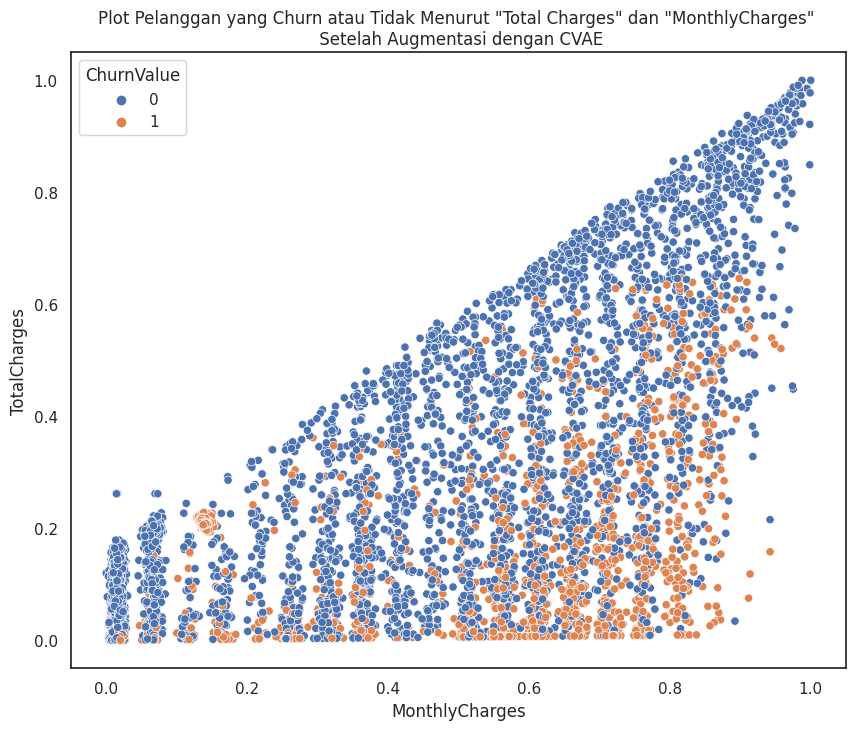

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Plot Pelanggan yang Churn atau Tidak Menurut "Total Charges" dan "MonthlyCharges" \n Setelah Augmentasi dengan CVAE')
sns.scatterplot(x='MonthlyCharges',y='TotalCharges',data=df_cvae,hue='ChurnValue')
plt.savefig('Plot Pelanggan yang Churn atau Tidak Menurut "Total Charges" dan "MonthlyCharges" CVAE.jpg',dpi=300)
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
plt.title('Plot Pelanggan yang Churn atau Tidak Churn Setelah Augmentasi dengan CVAE')
for c in [0,1]: #df_cvae.ChurnValue.unique():
  ax.scatter(df_cvae.MonthlyCharges[df_cvae.ChurnValue==c],df_cvae.TenureMonths[df_cvae.ChurnValue==c],df_cvae.TotalCharges[df_cvae.ChurnValue==c], label=c)
ax.set_xlabel('Monthly Charges')
ax.set_ylabel('Tenure Months')
ax.set_zlabel('Total Charges')
ax.legend()
plt.savefig('Plot Pelanggan yang Churn atau Tidak Churn Setelah Augmentasi dengan CVAE.jpg',dpi=300)

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Grafik Histogram Fitur "MonthlyCharges" Dengan Teknik CVAE')
sns.histplot(df_cvae['MonthlyCharges'],kde=True,bins='doane')
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Grafik Histogram Fitur "TotalCharges" Dengan Teknik CVAE')
sns.histplot(df_cvae['TotalCharges'],kde=True,bins='doane')
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Grafik Histogram Fitur "TenureMonths" Dengan Teknik CVAE')
sns.histplot(df_cvae['TenureMonths'],kde=True,bins='doane')
plt.show()

In [ ]:
df_cvae = pd.read_csv('/content/df_cvae.csv')

In [ ]:
x_cvae = df_cvae.drop(columns='ChurnValue')
y_cvae = df_cvae['ChurnValue']

## Analsis metode Augmentasi

### Chi2

Mengevaluasi korelasi (*p-value*) antara fitur dengan target

In [ ]:
# X_train Data (Original yang sudah dilakukan feature selection)
col_uji_ori = [uji for uji in categoricals_uji if uji not in ['ChurnValue','Gender', 'Phone Service', 'MultipleLines']]
x_uji_chi2_ori = X_train[col_uji_ori]
y_uji_chi2_ori = y_train

chi2_scores_ori= chi2(x_uji_chi2_ori,y_uji_chi2_ori)
chi2_ori = pd.DataFrame({'chi2_Ori':chi2_scores_ori[1]},index=x_uji_chi2_ori.columns)
chi2_ori.sort_values(by='chi2_Ori',ascending=True)

chi2_Ori
Contract          5.554436e-212
OnlineSecurity    4.637280e-105
TechSupport        2.798119e-95
Dependents         4.184335e-57
OnlineBackup       7.228020e-54
DeviceProtection   7.396014e-44
SeniorCitizen      1.413046e-23
PaperlessBilling   5.363404e-20
Partner            2.467306e-19
PaymentMethod      8.774250e-15
StreamingMovies    2.486492e-05
StreamingTV        5.015207e-05
InternetService    1.898289e-03

In [ ]:
# SMOTE Data
col_uji_smote = [uji for uji in categoricals_uji if uji not in ['ChurnValue','Gender', 'Phone Service', 'MultipleLines']]
x_uji_chi2_smote = df_over[col_uji_smote]
y_uji_chi2_smote = df_over['ChurnValue']

chi2_scores_smote = chi2(x_uji_chi2_smote,y_uji_chi2_smote)
chi2_smote = pd.DataFrame({'chi2_SMOTE':chi2_scores_smote[1]},index=x_uji_chi2_smote.columns)
chi2_smote.sort_values(by='chi2_SMOTE',ascending=True)

chi2_SMOTE
OnlineSecurity     0.000000e+00
Contract           0.000000e+00
TechSupport       5.174867e-272
Dependents        1.993263e-189
OnlineBackup      1.609683e-135
DeviceProtection  3.932643e-103
Partner            1.161976e-49
PaperlessBilling   8.330330e-42
PaymentMethod      1.017890e-37
SeniorCitizen      1.840078e-25
StreamingMovies    9.706999e-09
StreamingTV        2.841826e-08
InternetService    3.900965e-05

In [ ]:
# HAT
col_uji_hat = [uji for uji in categoricals_uji if uji not in ['ChurnValue','Gender', 'Phone Service', 'MultipleLines']]
x_uji_chi2_hat = a_df[col_uji_hat]
y_uji_chi2_hat = a_df['ChurnValue']

chi2_scores_hat = chi2(x_uji_chi2_hat,y_uji_chi2_hat)
chi2_hat = pd.DataFrame({'chi2_HAT':chi2_scores_hat[1]},index=x_uji_chi2_hat.columns)
chi2_hat.sort_values(by='chi2_HAT',ascending=True)

chi2_HAT
Contract           0.000000e+00
OnlineSecurity    2.488317e-247
TechSupport       1.927588e-225
Dependents        4.957634e-147
OnlineBackup      6.697628e-119
DeviceProtection   3.595830e-95
Partner            1.994924e-40
SeniorCitizen      4.500972e-38
PaperlessBilling   7.699411e-35
PaymentMethod      1.871978e-26
StreamingMovies    1.800804e-09
StreamingTV        7.297694e-09
InternetService    7.886563e-06

In [ ]:
# CVAE
col_uji_cvae = [uji for uji in categoricals_uji if uji not in ['ChurnValue','Gender', 'Phone Service', 'MultipleLines']]
x_uji_chi2_cvae = a_df[col_uji_cvae]
y_uji_chi2_cvae = a_df['ChurnValue']

chi2_scores_cvae = chi2(x_uji_chi2_cvae,y_uji_chi2_cvae)
chi2_cvae = pd.DataFrame({'chi2_CVAE':chi2_scores_cvae[1]},index=x_uji_chi2_cvae.columns)
chi2_cvae.sort_values(by='chi2_CVAE',ascending=True)

chi2_CVAE
Contract           0.000000e+00
OnlineSecurity    2.488317e-247
TechSupport       1.927588e-225
Dependents        4.957634e-147
OnlineBackup      6.697628e-119
DeviceProtection   3.595830e-95
Partner            1.994924e-40
SeniorCitizen      4.500972e-38
PaperlessBilling   7.699411e-35
PaymentMethod      1.871978e-26
StreamingMovies    1.800804e-09
StreamingTV        7.297694e-09
InternetService    7.886563e-06

In [ ]:
df_chi2 = pd.concat([chi2_ori,chi2_smote,chi2_hat,chi2_cvae],join='outer',axis=1)
df_chi2.to_csv('df_chi2.csv',index_label=False)
df_chi2

chi2_Ori     chi2_SMOTE       chi2_HAT      chi2_CVAE
SeniorCitizen      1.413046e-23   1.840078e-25   4.500972e-38   4.500972e-38
Partner            2.467306e-19   1.161976e-49   1.994924e-40   1.994924e-40
Dependents         4.184335e-57  1.993263e-189  4.957634e-147  4.957634e-147
InternetService    1.898289e-03   3.900965e-05   7.886563e-06   7.886563e-06
OnlineSecurity    4.637280e-105   0.000000e+00  2.488317e-247  2.488317e-247
OnlineBackup       7.228020e-54  1.609683e-135  6.697628e-119  6.697628e-119
DeviceProtection   7.396014e-44  3.932643e-103   3.595830e-95   3.595830e-95
TechSupport        2.798119e-95  5.174867e-272  1.927588e-225  1.927588e-225
StreamingTV        5.015207e-05   2.841826e-08   7.297694e-09   7.297694e-09
StreamingMovies    2.486492e-05   9.706999e-09   1.800804e-09   1.800804e-09
Contract          5.554436e-212   0.000000e+00   0.000000e+00   0.000000e+00
PaperlessBilling   5.363404e-20   8.330330e-42   7.699411e-35   7.699411e-35
PaymentMethod      8.774250e-15   1.017890e-37   1.871978e-26   1.871978e-26

In [ ]:
df_chi2.describe().T.sort_values(by=['std','mean'],ascending=[True,True])

count          mean       std            min            25%  \
chi2_HAT     13.0  6.073586e-07  0.000002   0.000000e+00  4.957634e-147   
chi2_CVAE    13.0  6.073586e-07  0.000002   0.000000e+00  4.957634e-147   
chi2_SMOTE   13.0  3.003675e-06  0.000011   0.000000e+00  1.993263e-189   
chi2_Ori     13.0  1.517928e-04  0.000525  5.554436e-212   4.184335e-57   

                     50%           75%       max  
chi2_HAT    1.994924e-40  1.871978e-26  0.000008  
chi2_CVAE   1.994924e-40  1.871978e-26  0.000008  
chi2_SMOTE  1.161976e-49  1.840078e-25  0.000039  
chi2_Ori    1.413046e-23  8.774250e-15  0.001898

### GLM

In [ ]:
# Uji korelasi dengan General Linear Model X_train
df_ori = pd.concat([X_train,y_train],join='outer',axis=1)
df_ori = sm.add_constant(df_ori)
model_uji_ori = sm.GLM.from_formula("ChurnValue ~ TotalCharges + MonthlyCharges + TenureMonths", family=sm.families.Binomial(), data=df_ori)
result_uji_ori = model_uji_ori.fit()
print(result_uji_ori.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             ChurnValue   No. Observations:                 5544
Model:                            GLM   Df Residuals:                     5540
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2354.1
Date:                Mon, 29 May 2023   Deviance:                       4708.2
Time:                        04:25:58   Pearson chi2:                 5.35e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2464
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.2537      0.102    -12.

In [ ]:
result_uji_ori.

In [ ]:
# Uji korelasi dengan data SMOTE
df_over = sm.add_constant(df_over)
model_uji_over = sm.GLM.from_formula("ChurnValue ~ TotalCharges + MonthlyCharges + TenureMonths", family=sm.families.Binomial(), data=df_over)
result_uji_over = model_uji_ori.fit()
print(result_uji_over.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             ChurnValue   No. Observations:                 5544
Model:                            GLM   Df Residuals:                     5540
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2354.1
Date:                Mon, 29 May 2023   Deviance:                       4708.2
Time:                        04:29:21   Pearson chi2:                 5.35e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2464
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.2537      0.102    -12.

In [ ]:
# Uji korelasi dengan data HAT
a_df = sm.add_constant(a_df)
model_uji_hat = sm.GLM.from_formula("ChurnValue ~ TotalCharges + MonthlyCharges + TenureMonths", family=sm.families.Binomial(), data=a_df)
result_uji_hat = model_uji_hat.fit()
print(result_uji_hat.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             ChurnValue   No. Observations:                 8278
Model:                            GLM   Df Residuals:                     8274
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4288.2
Date:                Mon, 29 May 2023   Deviance:                       8576.4
Time:                        04:30:22   Pearson chi2:                 7.99e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2955
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0864      0.054      1.

In [ ]:
# Uji korelasi dengan data CVAE
df_cvae = sm.add_constant(df_cvae)
model_uji_cvae = sm.GLM.from_formula("ChurnValue ~ TotalCharges + MonthlyCharges + TenureMonths", family=sm.families.Binomial(), data=df_cvae)
result_uji_cvae = model_uji_cvae.fit()
print(result_uji_cvae.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             ChurnValue   No. Observations:                 8278
Model:                            GLM   Df Residuals:                     8274
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4264.4
Date:                Mon, 29 May 2023   Deviance:                       8528.9
Time:                        04:31:15   Pearson chi2:                 9.31e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2995
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.7340      0.106    -25.

### Grafik

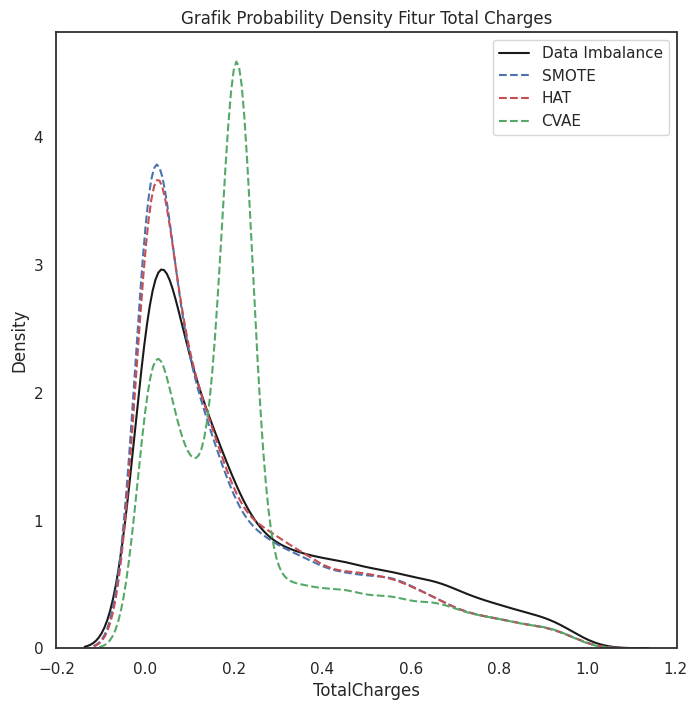

<Figure size 640x480 with 0 Axes>

In [ ]:
# Total Charges
data_imbalance = X_train['TotalCharges']
data_SMOTE = df_over['TotalCharges']
data_HAT = a_df['TotalCharges']
data_CVAE = df_cvae['TotalCharges']

plt.figure(figsize=(8,8))
fig = sns.kdeplot(data_imbalance, shade=False, color="k",label='Data Imbalance')
fig = sns.kdeplot(data_SMOTE, shade=False, color="b",linestyle='--',label='SMOTE')
fig = sns.kdeplot(data_HAT, shade=False, color="r",linestyle='--',label='HAT')
fig = sns.kdeplot(data_CVAE, shade=False, color="g",linestyle='--',label='CVAE')
plt.title('Grafik Probability Density Fitur Total Charges')
plt.legend()
plt.show()
plt.savefig('Grafik Probability Density Total Charges.jpg',dpi=300)

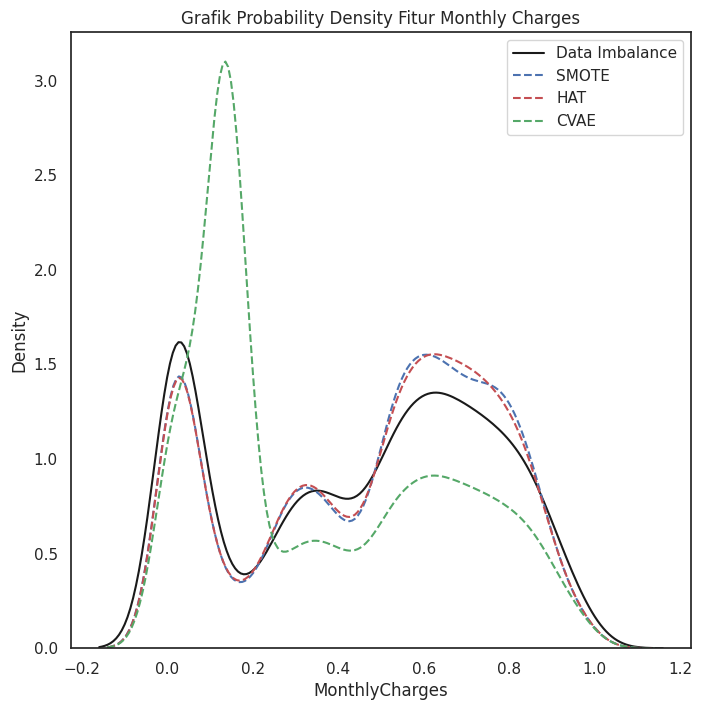

<Figure size 640x480 with 0 Axes>

In [ ]:
# Monthly Charges
data_imbalance_mc = X_train['MonthlyCharges']
data_SMOTE_mc = df_over['MonthlyCharges']
data_HAT_mc = a_df['MonthlyCharges']
data_CVAE_mc = df_cvae['MonthlyCharges']

plt.figure(figsize=(8,8))
fig = sns.kdeplot(data_imbalance_mc, shade=False, color="k",label='Data Imbalance')
fig = sns.kdeplot(data_SMOTE_mc, shade=False, color="b",linestyle='--',label='SMOTE')
fig = sns.kdeplot(data_HAT_mc, shade=False, color="r",linestyle='--',label='HAT')
fig = sns.kdeplot(data_CVAE_mc, shade=False, color="g",linestyle='--',label='CVAE')
plt.title('Grafik Probability Density Fitur Monthly Charges')
plt.legend()
plt.show()
plt.savefig('Grafik Probability Density Monthly Charges.jpg',dpi=300)

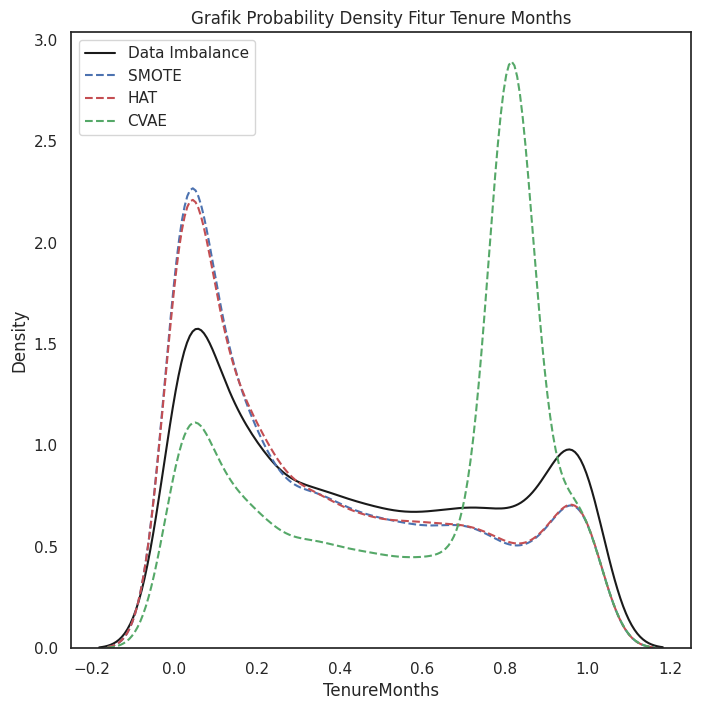

<Figure size 640x480 with 0 Axes>

In [ ]:
# Monthly Charges
data_imbalance_tm = X_train['TenureMonths']
data_SMOTE_tm = df_over['TenureMonths']
data_HAT_tm = a_df['TenureMonths']
data_CVAE_tm= df_cvae['TenureMonths']

plt.figure(figsize=(8,8))
fig = sns.kdeplot(data_imbalance_tm, shade=False, color="k",label='Data Imbalance')
fig = sns.kdeplot(data_SMOTE_tm, shade=False, color="b",linestyle='--',label='SMOTE')
fig = sns.kdeplot(data_HAT_tm, shade=False, color="r",linestyle='--',label='HAT')
fig = sns.kdeplot(data_CVAE_tm, shade=False, color="g",linestyle='--',label='CVAE')
plt.title('Grafik Probability Density Fitur Tenure Months')
plt.legend()
plt.show()
plt.savefig('Grafik Probability Density Tenure Months.jpg',dpi=300)

# Pelatihan Data

## Data Tidak Seimbang

In [ ]:
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [ ]:
#scoring_opt = ['recall']
index_train = []
index_test =[]

In [ ]:
for train_index, test_index in sss.split(X_train, y_train):
    print("Train:", train_index, "Test:", test_index)
    imb_xtrain, imb_xtest = X_train.iloc[train_index], X_train.iloc[test_index]
    imb_ytrain, imb_ytest = y_train.iloc[train_index], y_train.iloc[test_index]
    index_train.append(train_index)
    index_test.append(test_index)

Train: [1107 1108 1109 ... 5541 5542 5543] Test: [   0    1    2 ... 1106 1111 1118]
Train: [   0    1    2 ... 5541 5542 5543] Test: [1107 1108 1109 ... 2221 2223 2224]
Train: [   0    1    2 ... 5541 5542 5543] Test: [2200 2203 2206 ... 3342 3344 3345]
Train: [   0    1    2 ... 5541 5542 5543] Test: [3275 3276 3294 ... 4436 4437 4439]
Train: [   0    1    2 ... 4436 4437 4439] Test: [4425 4431 4433 ... 5541 5542 5543]


In [ ]:
train_unique_label, train_counts_label = np.unique(imb_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(imb_ytest, return_counts=True)

print(np.unique(imb_ytrain, return_counts=True))
print(np.unique(imb_ytest, return_counts=True))

(array([0, 1]), array([3312, 1124]))
(array([0, 1]), array([827, 281]))


In [ ]:
print('Label Distributions: \n')
print(train_counts_label/ len(imb_ytrain))
print(test_counts_label/ len(imb_ytest))

Label Distributions: 

[0.74661858 0.25338142]
[0.74638989 0.25361011]


In [ ]:
def split_train(model,X_train,y_train):
  global clf
  acc = []
  recall = []
  f1 = []
  pred_acc = []
  pred_recall = []
  pred_f1 = []
  result = {'accuracy':[],'recall':[], 'f1-score':[], 'pred':[]}
  predict = {'pred_accuracy':[], 'pred_recall':[], 'pred_f1':[], 'pred_class':[]}
  for train_index, test_index in zip(index_train, index_test):
    imb_xtrain, imb_xtest = X_train.iloc[train_index], X_train.iloc[test_index]
    imb_ytrain, imb_ytest = y_train.iloc[train_index], y_train.iloc[test_index]
    clf = classifier.fit(imb_xtrain, imb_ytrain)
    pred = clf.predict(imb_xtest)
    acc.append(accuracy_score(pred, imb_ytest))
    recall.append(recall_score(pred, imb_ytest))
    f1.append(f1_score(pred, imb_ytest))
    result['accuracy'] = acc
    result['recall'] = recall
    result['f1-score'] = f1
    result['class'] = pred

  tmp = clf.predict(X_test)
  pred_acc.append(accuracy_score(y_test, tmp))
  pred_recall.append(recall_score(y_test, tmp))
  pred_f1.append(f1_score(y_test, tmp))
  predict['pred_accuracy'] = pred_acc
  predict['pred_recall'] = pred_recall
  predict['pred_f1'] = pred_f1
  predict['pred_class'] = tmp
  return result, predict

In [ ]:
acc_imb = []
recall_imb = []
f1_imb = []
class_imb = []

clf_imb = []
models_imb = ["SVM","Logistic Regression", "AdaBoost","Gradient Boosting","Xgboost"]
scores_imb = []
predict_imb = []

clf_imb.append(SVC())
clf_imb.append(LogisticRegression())
clf_imb.append(AdaBoostClassifier())
clf_imb.append(GradientBoostingClassifier(max_features='sqrt'))
clf_imb.append(XGBClassifier(objective= 'binary:logistic', nthread=4, seed=42))

for classifier,model in zip(clf_imb, models_imb):
  print('='*len(model))
  print(model)
  print('='*len(model))
  result, predict = split_train(classifier,X_train,y_train)
  print('Training \t')
  print(result)
  scores_imb.append(result)
  print('Predict \t')
  print(predict)
  predict_imb.append(predict)


===
SVM
===
Training 	
{'accuracy': [0.8133453561767358, 0.8106402164111812, 0.8232642019837692, 0.8205590622182146, 0.8023465703971119], 'recall': [0.6728971962616822, 0.6714975845410628, 0.6905829596412556, 0.6666666666666666, 0.628099173553719], 'f1-score': [0.5818181818181818, 0.569672131147541, 0.611111111111111, 0.6223908918406071, 0.5812619502868068], 'pred': [], 'class': array([0, 1, 0, ..., 0, 1, 0])}
Predict 	
{'pred_accuracy': [0.8095238095238095], 'pred_recall': [0.5356125356125356], 'pred_f1': [0.5875], 'pred_class': array([0, 1, 0, ..., 1, 0, 0])}
Logistic Regression
Training 	
{'accuracy': [0.8115419296663661, 0.8124436429215509, 0.8205590622182146, 0.8205590622182146, 0.8068592057761733], 'recall': [0.652542372881356, 0.6553191489361702, 0.6708333333333333, 0.6485507246376812, 0.6227106227106227], 'f1-score': [0.5957446808510638, 0.5968992248062015, 0.6180422264875239, 0.6427289048473968, 0.6137184115523466], 'pred': [], 'class': array([1, 1, 0, ..., 0, 1, 0])}
Predict 

In [ ]:
index = ['Fold-1', 'Fold-2', 'Fold-3', 'Fold-4', 'Fold-5']
stat = ['Counts', 'Sum', 'Average', 'Variance']
acc_imb = list(zip(scores_imb[0]['accuracy'], scores_imb[1]['accuracy'], scores_imb[2]['accuracy'], scores_imb[3]['accuracy'], scores_imb[4]['accuracy']))
recall_imb = list(zip(scores_imb[0]['recall'], scores_imb[1]['recall'], scores_imb[2]['recall'], scores_imb[3]['recall'], scores_imb[4]['recall']))
f1_imb = list(zip(scores_imb[0]['f1-score'], scores_imb[1]['f1-score'], scores_imb[2]['f1-score'], scores_imb[3]['f1-score'], scores_imb[4]['f1-score']))
count = [5, 5, 5, 5]

### F1

In [ ]:
df_f1_imb = pd.DataFrame(f1_imb, index=index, columns=models_imb)
df_f1_imb.index.name = 'Fold'
df_f1_imb.round(3)

SVM  Logistic Regression  AdaBoost  Gradient Boosting  Xgboost
Fold                                                                    
Fold-1  0.582                0.596     0.604              0.582    0.573
Fold-2  0.570                0.597     0.643              0.637    0.621
Fold-3  0.611                0.618     0.634              0.639    0.594
Fold-4  0.622                0.643     0.638              0.637    0.562
Fold-5  0.581                0.614     0.622              0.626    0.573

In [ ]:
#df_f1_imb.to_excel('f1_imb_res.xlsx')

In [ ]:
df_f1_imb.describe().T.sort_values(by=['mean'],ascending=[False])

count      mean       std       min       25%       50%  \
AdaBoost               5.0  0.627893  0.015456  0.603922  0.621762  0.633517   
Gradient Boosting      5.0  0.624301  0.024090  0.582178  0.626118  0.637066   
Logistic Regression    5.0  0.613427  0.019143  0.595745  0.596899  0.613718   
SVM                    5.0  0.593251  0.022352  0.569672  0.581262  0.581818   
Xgboost                5.0  0.584711  0.023622  0.562264  0.572565  0.572973   

                          75%       max  
AdaBoost             0.637681  0.642586  
Gradient Boosting    0.637201  0.638941  
Logistic Regression  0.618042  0.642729  
SVM                  0.611111  0.622391  
Xgboost              0.594286  0.621469

In [ ]:
df_f1_imb.describe().T.sort_values(by=['mean'],ascending=[False])#.to_excel('top5_result_imb.xlsx')

count      mean       std       min       25%       50%  \
AdaBoost               5.0  0.627893  0.015456  0.603922  0.621762  0.633517   
Gradient Boosting      5.0  0.624301  0.024090  0.582178  0.626118  0.637066   
Logistic Regression    5.0  0.613427  0.019143  0.595745  0.596899  0.613718   
SVM                    5.0  0.593251  0.022352  0.569672  0.581262  0.581818   
Xgboost                5.0  0.584711  0.023622  0.562264  0.572565  0.572973   

                          75%       max  
AdaBoost             0.637681  0.642586  
Gradient Boosting    0.637201  0.638941  
Logistic Regression  0.618042  0.642729  
SVM                  0.611111  0.622391  
Xgboost              0.594286  0.621469

### Recall

In [ ]:
df_recall_imb = pd.DataFrame(recall_imb, index=index, columns=models_imb)
df_recall_imb.index.name = 'Fold'
df_recall_imb.round(3)

SVM  Logistic Regression  AdaBoost  Gradient Boosting  Xgboost
Fold                                                                    
Fold-1  0.673                0.653     0.672              0.656    0.649
Fold-2  0.671                0.655     0.690              0.696    0.660
Fold-3  0.691                0.671     0.656              0.681    0.639
Fold-4  0.667                0.649     0.649              0.660    0.598
Fold-5  0.628                0.623     0.604              0.629    0.580

In [ ]:
df_recall_imb.to_excel('recall_imb_res.xlsx')

In [ ]:
df_recall_imb.describe().T.sort_values(by=['mean'],ascending=[False])

count      mean       std       min       25%       50%  \
SVM                    5.0  0.665949  0.023016  0.628099  0.666667  0.671498   
Gradient Boosting      5.0  0.664741  0.025510  0.629496  0.656250  0.660305   
AdaBoost               5.0  0.654449  0.032196  0.604027  0.649446  0.656489   
Logistic Regression    5.0  0.649991  0.017433  0.622711  0.648551  0.652542   
Xgboost                5.0  0.625336  0.034264  0.580292  0.598394  0.639344   

                          75%       max  
SVM                  0.672897  0.690583  
Gradient Boosting    0.681452  0.696203  
AdaBoost             0.672489  0.689796  
Logistic Regression  0.655319  0.670833  
Xgboost              0.648649  0.660000

In [ ]:
df_recall_imb.describe().T.sort_values(by=['mean'],ascending=[False])#.to_excel('top5_result_imb_recall.xlsx')

count      mean       std       min       25%       50%  \
SVM                    5.0  0.665949  0.023016  0.628099  0.666667  0.671498   
Gradient Boosting      5.0  0.664741  0.025510  0.629496  0.656250  0.660305   
AdaBoost               5.0  0.654449  0.032196  0.604027  0.649446  0.656489   
Logistic Regression    5.0  0.649991  0.017433  0.622711  0.648551  0.652542   
Xgboost                5.0  0.625336  0.034264  0.580292  0.598394  0.639344   

                          75%       max  
SVM                  0.672897  0.690583  
Gradient Boosting    0.681452  0.696203  
AdaBoost             0.672489  0.689796  
Logistic Regression  0.655319  0.670833  
Xgboost              0.648649  0.660000

### Prediksi

In [ ]:
predict_imb

[{'pred_accuracy': [0.8095238095238095],
  'pred_recall': [0.5356125356125356],
  'pred_f1': [0.5875],
  'pred_class': array([0, 1, 0, ..., 1, 0, 0])},
 {'pred_accuracy': [0.8196248196248196],
  'pred_recall': [0.6125356125356125],
  'pred_f1': [0.6323529411764706],
  'pred_class': array([0, 1, 0, ..., 1, 0, 0])},
 {'pred_accuracy': [0.8217893217893217],
  'pred_recall': [0.6609686609686609],
  'pred_f1': [0.6526019690576652],
  'pred_class': array([0, 1, 1, ..., 1, 0, 0])},
 {'pred_accuracy': [0.8174603174603174],
  'pred_recall': [0.6153846153846154],
  'pred_f1': [0.6306569343065693],
  'pred_class': array([0, 1, 0, ..., 1, 0, 0])},
 {'pred_accuracy': [0.7994227994227994],
  'pred_recall': [0.584045584045584],
  'pred_f1': [0.5959302325581395],
  'pred_class': array([0, 1, 0, ..., 1, 0, 0])}]

In [ ]:
predict_acc = [predict_imb[0]['pred_accuracy'][0], predict_imb[1]['pred_accuracy'][0], predict_imb[2]['pred_accuracy'][0], predict_imb[3]['pred_accuracy'][0] ,predict_imb[4]['pred_accuracy'][0]]
predict_recall = [predict_imb[0]['pred_recall'][0], predict_imb[1]['pred_recall'][0], predict_imb[2]['pred_recall'][0], predict_imb[3]['pred_recall'][0], predict_imb[4]['pred_recall'][0]]
predict_f1 =  [predict_imb[0]['pred_f1'][0], predict_imb[1]['pred_f1'][0], predict_imb[2]['pred_f1'][0], predict_imb[3]['pred_f1'][0], predict_imb[4]['pred_f1'][0]]
predict_class = [predict_imb[0]['pred_class'], predict_imb[1]['pred_class'], predict_imb[2]['pred_class'], predict_imb[3]['pred_class'], predict_imb[4]['pred_class']]

In [ ]:
imb_pred_result_model = {'test accuracy':predict_acc, 'recall': predict_recall, 'f1-score':predict_f1}
df_pred_res_imb = pd.DataFrame(imb_pred_result_model, index=models_imb)
df_pred_res_imb.index.name = 'Model'
df_pred_res_imb.sort_values(by=['f1-score'],ascending=[False])

test accuracy    recall  f1-score
Model                                                 
AdaBoost                  0.821789  0.660969  0.652602
Logistic Regression       0.819625  0.612536  0.632353
Gradient Boosting         0.817460  0.615385  0.630657
Xgboost                   0.799423  0.584046  0.595930
SVM                       0.809524  0.535613  0.587500

In [ ]:
df_pred_res_imb.sort_values(by=['recall'],ascending=[False])#.to_excel('top5_result_predict_imb_recall.xlsx')

test accuracy    recall  f1-score
Model                                                 
AdaBoost                  0.821789  0.660969  0.652602
Gradient Boosting         0.817460  0.615385  0.630657
Logistic Regression       0.819625  0.612536  0.632353
Xgboost                   0.799423  0.584046  0.595930
SVM                       0.809524  0.535613  0.587500

In [ ]:
#df_pred_res_imb.to_excel('top5_result_predict_imb.xlsx')

===
SVM
===


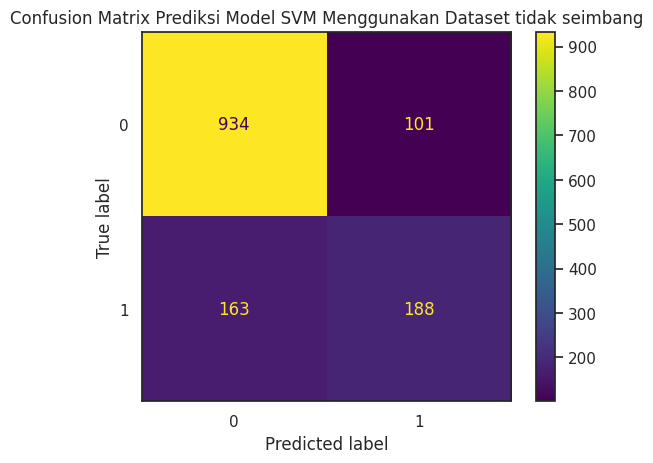

Logistic Regression


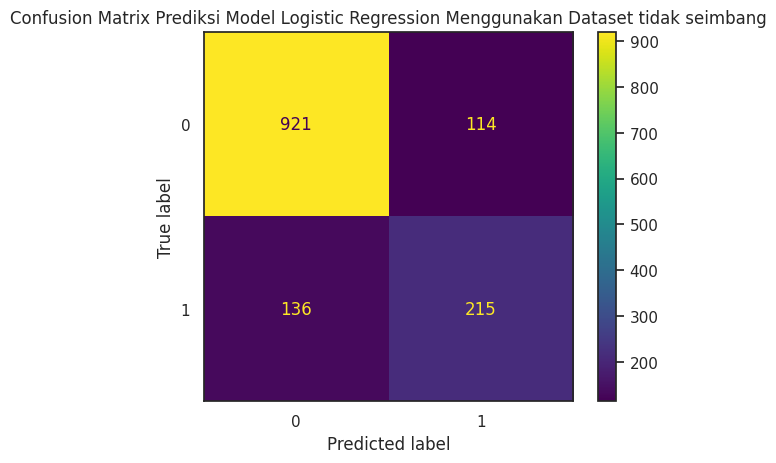

AdaBoost


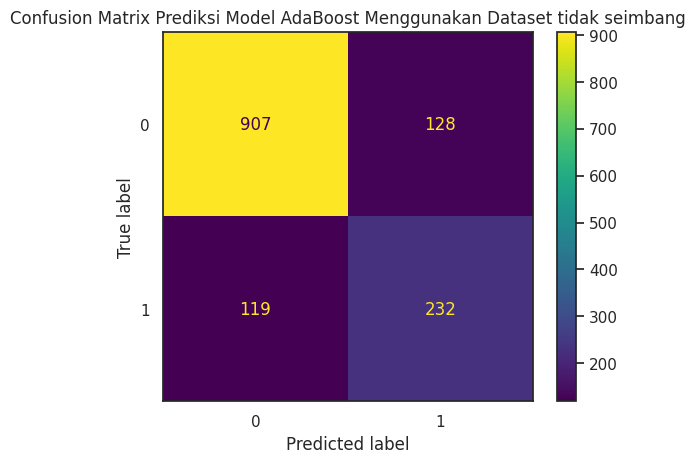

Gradient Boosting


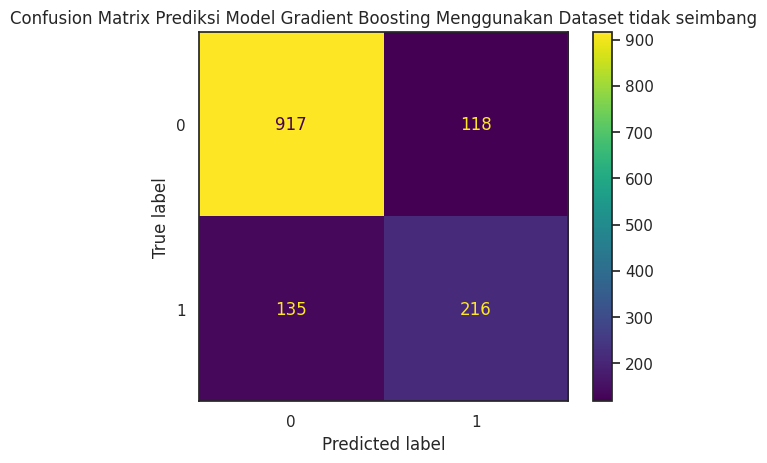

Xgboost


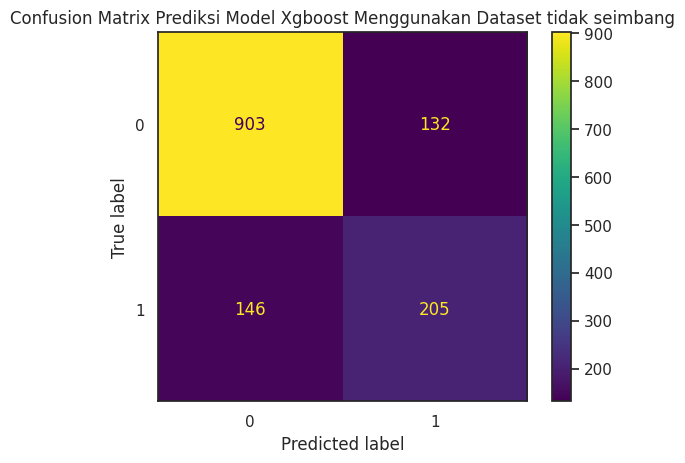

In [ ]:
for classifier,model, p in zip(clf_imb, models_imb, predict_class):
  pred_model_imb = []
  print('='*len(model))
  print(model)
  print('='*len(model))
  #pred_imb = cross_val_predict(classifier, X_test, y_test, cv=sss)
  #pred_model_imb.append(pred_imb)
  cm = confusion_matrix(y_test, p)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
  disp.plot()
  plt.title('Confusion Matrix Prediksi Model '+ model +' Menggunakan Dataset tidak seimbang')
  plt.savefig('Confusion Matrix Prediksi Model '+ model +' Menggunakan Dataset tidak seimbang.jpg',dpi=300)
  plt.show()
  #print(cm)

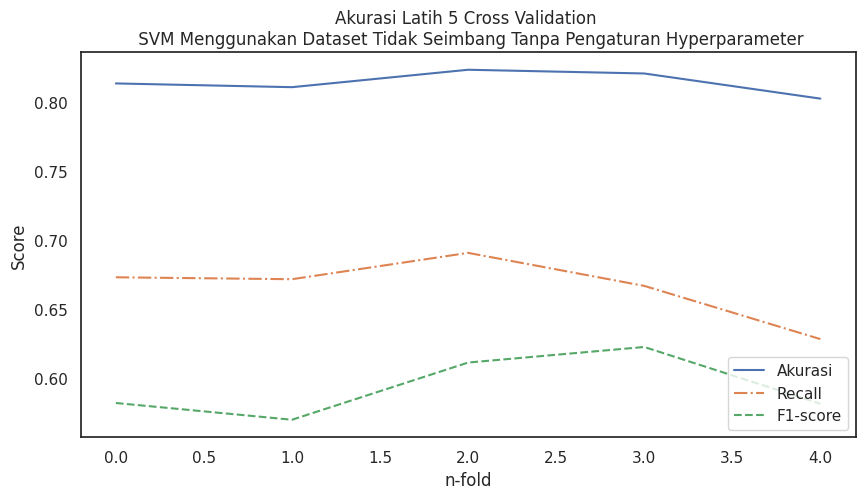

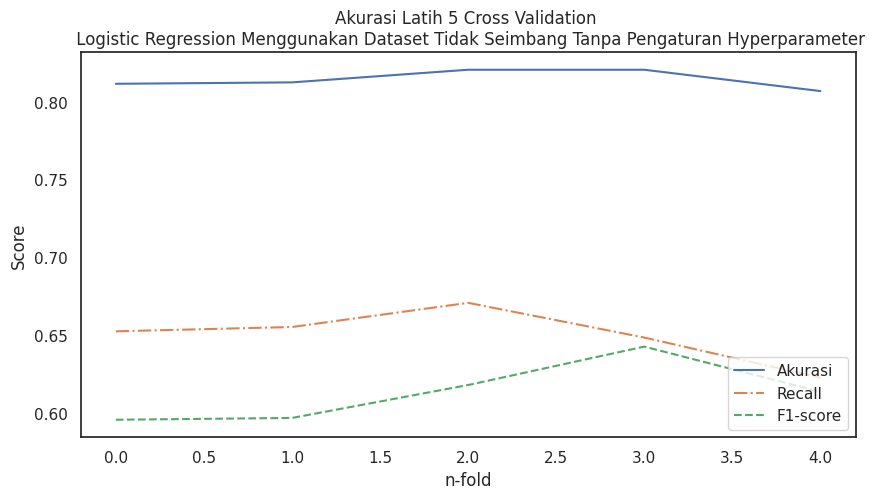

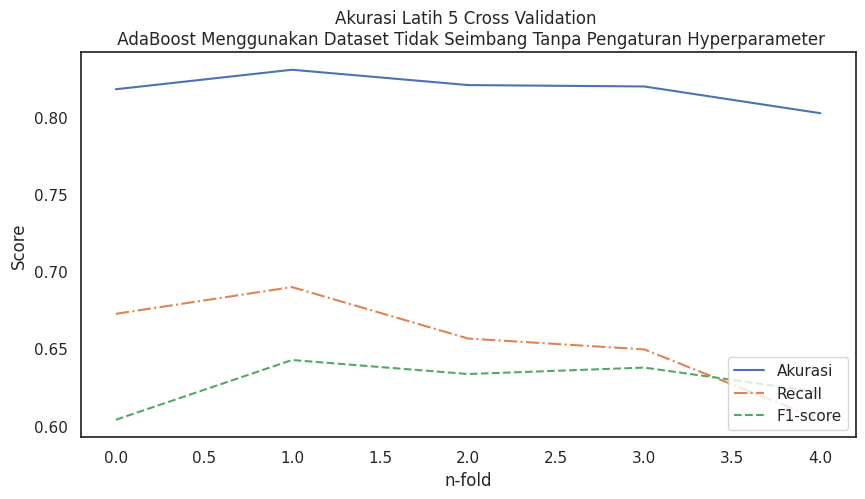

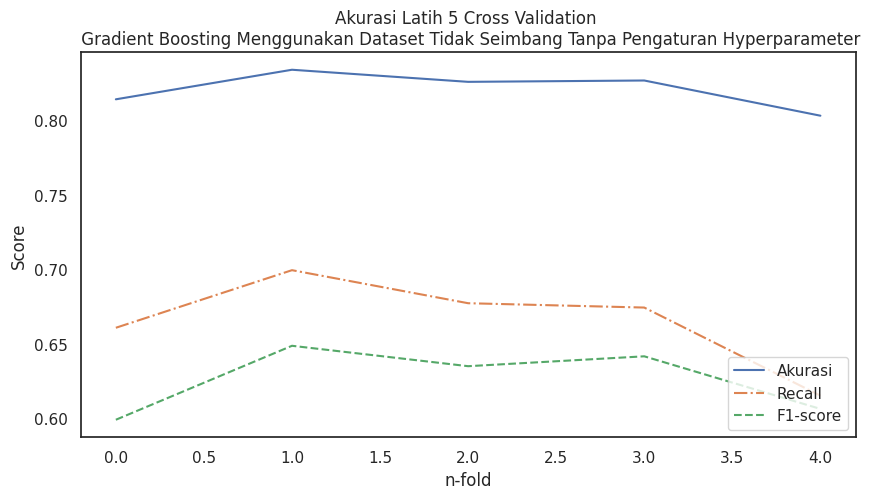

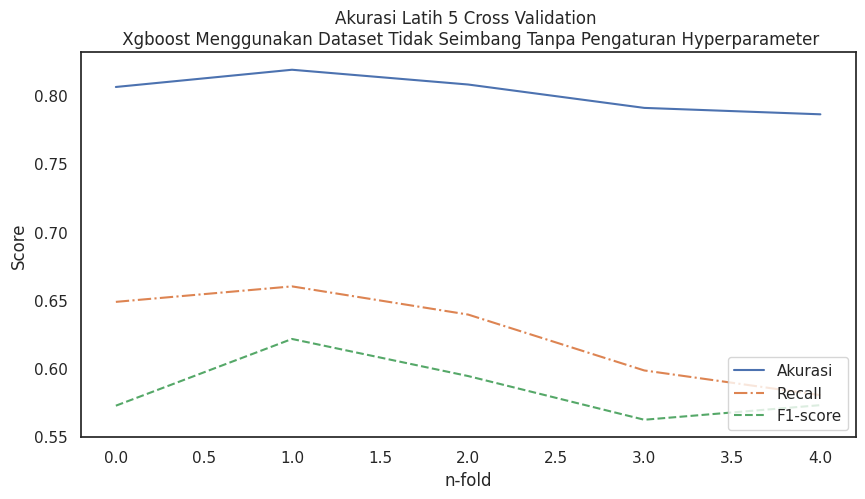

In [ ]:
for i,model_ in enumerate(models_imb):
  plt.figure(figsize=(10,5))
  plt.plot(scores_imb[i]['accuracy'])
  plt.plot(scores_imb[i]['recall'], linestyle='-.')
  plt.plot(scores_imb[i]['f1-score'], linestyle='--')
  plt.title('Akurasi Latih 5 Cross Validation \n '+ model_ +' Menggunakan Dataset Tidak Seimbang Tanpa Pengaturan Hyperparameter')
  plt.xlabel('n-fold')
  plt.ylabel('Score')
  plt.legend(["Akurasi","Recall","F1-score"], loc ="lower right")
  plt.savefig('Akurasi Latih 5 Cross Validation \n '+ model_ +' Menggunakan Dataset Tidak Seimbang Tanpa Pengaturan Hyperparameter.jpg',dpi=300)
  plt.show()

## Data seimbang

In [ ]:
for train_index, test_index in sss.split(x_aug, y_aug):
    print("Train:", train_index, "Test:", test_index)
    aug_xtrain, aug_xtest = x_aug.iloc[train_index], x_aug.iloc[test_index]
    aug_ytrain, aug_ytest = y_aug.iloc[train_index], y_aug.iloc[test_index]

Train: [ 828  829  830 ... 8275 8276 8277] Test: [   0    1    2 ... 4964 4965 4966]
Train: [   0    1    2 ... 8275 8276 8277] Test: [ 828  829  830 ... 5792 5793 5794]
Train: [   0    1    2 ... 8275 8276 8277] Test: [1656 1657 1658 ... 6620 6621 6622]
Train: [   0    1    2 ... 8275 8276 8277] Test: [2484 2485 2486 ... 7447 7448 7449]
Train: [   0    1    2 ... 7447 7448 7449] Test: [3312 3313 3314 ... 8275 8276 8277]


In [ ]:
print(np.unique(aug_ytrain, return_counts=True))
print(np.unique(aug_ytest, return_counts=True))

(array([0, 1]), array([3312, 3311]))
(array([0, 1]), array([827, 828]))


### Menggunakan Data SMOTE

In [ ]:
train_acc_over = []
train_recall_over = []
train_f1_over = []
xg_over = AdaBoostClassifier() #XGBClassifier(objective= 'binary:logistic', nthread=4, seed=42)
for train_index, test_index in sss.split(x_over, y_over):
    x_train_fold_over, x_test_fold_over = x_over.iloc[train_index], x_over.iloc[test_index]
    y_train_fold_over, y_test_fold_over = y_over.iloc[train_index], y_over.iloc[test_index]
    xg_over.fit(x_train_fold_over, y_train_fold_over)
    xg_over_pred = xg_over.predict(x_test_fold_over)
    train_acc_over.append(accuracy_score(y_test_fold_over, xg_over_pred))
    train_recall_over.append(recall_score(y_test_fold_over, xg_over_pred))
    train_f1_over.append(f1_score(y_test_fold_over, xg_over_pred))

In [ ]:
#train_f1_over.clear()
#train_recall_over.clear()
#train_f1_over.clear()

In [ ]:
index = ['Fold-1', 'Fold-2', 'Fold-3', 'Fold-4', 'Fold-5']
df_f1_smote = pd.DataFrame(train_f1_over, index=index, columns=['Adaboost SMOTE'])
df_f1_smote.index.name = 'Fold'
df_f1_smote.describe().T

count      mean       std       min       25%       50%  \
Adaboost SMOTE    5.0  0.828665  0.018093  0.799761  0.826465  0.829646   

                     75%       max  
Adaboost SMOTE  0.841037  0.846416

In [ ]:
#df_f1_smote.to_excel('f1_smote_res.xlsx')

In [ ]:
test_f1_smote = []
test_acc_smote = []
test_recall_smote = []
xg_pred_over = xg_over.predict(X_test.to_numpy())
test_acc_smote.append(accuracy_score(y_test, xg_pred_over))
test_recall_smote.append(recall_score(y_test, xg_pred_over))
test_f1_smote.append(f1_score(y_test,xg_pred_over))

In [ ]:
print(f1_score(y_test, xg_pred_over))

0.645879732739421


In [ ]:
smote_pred_result_model = {'test accuracy':test_acc_smote, 'recall': test_recall_smote, 'f1-score':test_f1_smote}
df_pred_res_smote = pd.DataFrame(data=smote_pred_result_model, index=['Adaboost SMOTE'])
df_pred_res_smote.index.name = 'Model'
df_pred_res_smote

test accuracy    recall  f1-score
Model                                            
Adaboost SMOTE       0.770563  0.826211   0.64588

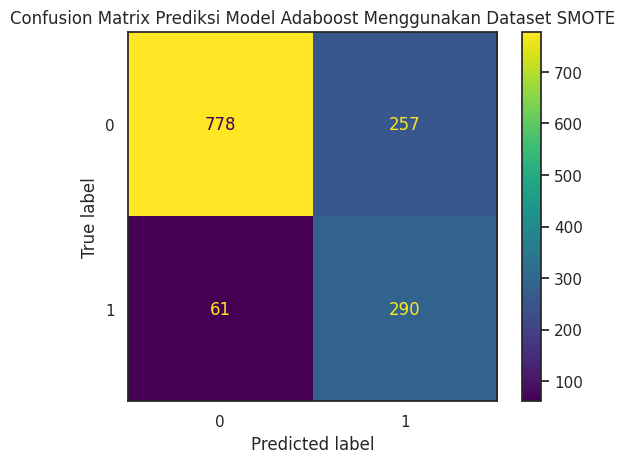

In [ ]:
cm = confusion_matrix(y_test,xg_pred_over)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.title('Confusion Matrix Prediksi Model Adaboost Menggunakan Dataset SMOTE')
plt.savefig('Confusion Matrix Prediksi Model Adaboost Menggunakan Dataset SMOTE.jpg',dpi=300)
plt.show()

In [ ]:
#df_pred_res_smote.to_excel('result_predict_smote.xlsx')

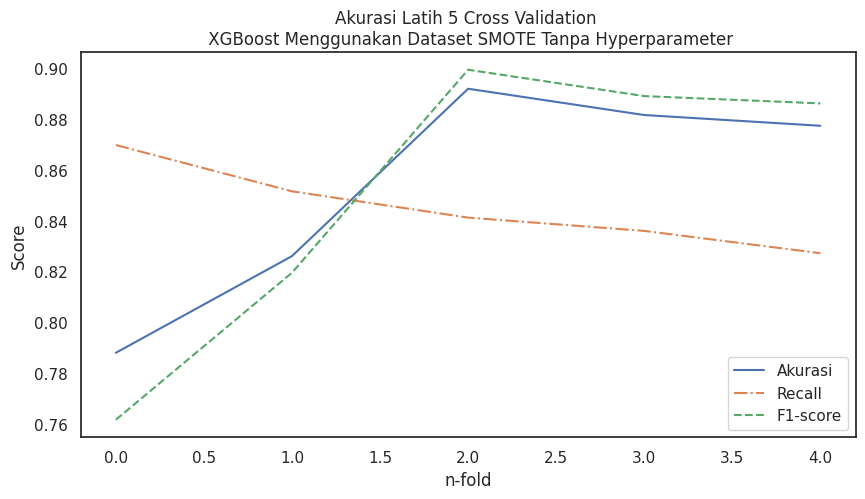

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_acc_over)
plt.plot(train_recall_over, linestyle='-.')
plt.plot(train_f1_over, linestyle='--')
plt.title('Akurasi Latih 5 Cross Validation \n XGBoost Menggunakan Dataset SMOTE Tanpa Hyperparameter')
plt.xlabel('n-fold')
plt.ylabel('Score')
plt.legend(["Akurasi","Recall","F1-score"], loc ="lower right")
plt.savefig('Akurasi Latih 5 Cross Validation \n XGBoost Menggunakan Dataset SMOTE Tanpa Hyperparameter.jpg',dpi=300)
plt.show()

### Menggunakan Data HAT

In [ ]:
train_acc_aug = []
train_recall_aug = []
train_f1_aug = []
xg_aug = AdaBoostClassifier() #XGBClassifier(objective= 'binary:logistic', nthread=4, seed=42)
for train_index, test_index in sss.split(x_aug, y_aug):
    x_train_fold_aug, x_test_fold_aug = x_aug.iloc[train_index], x_aug.iloc[test_index]
    y_train_fold_aug, y_test_fold_aug = y_aug.iloc[train_index], y_aug.iloc[test_index]
    xg_aug.fit(x_train_fold_aug, y_train_fold_aug)
    xg_aug_pred = xg_aug.predict(x_test_fold_aug)
    train_acc_aug.append(accuracy_score(y_test_fold_aug, xg_aug_pred))
    train_recall_aug.append(recall_score(y_test_fold_aug, xg_aug_pred))
    train_f1_aug.append(f1_score(y_test_fold_aug, xg_aug_pred, ))

In [ ]:
df_f1_aug = pd.DataFrame(train_f1_aug, index=index, columns=['Adaboost HAT'])
df_f1_aug.index.name = 'Fold'
df_f1_aug

Adaboost HAT
Fold                
Fold-1      0.806954
Fold-2      0.817153
Fold-3      0.827305
Fold-4      0.832291
Fold-5      0.800459

In [ ]:
#df_f1_aug.to_excel('f1_aug_res.xlsx')

In [ ]:
df_f1_aug.describe().T#.to_excel('result_aug.xlsx')

count      mean       std       min       25%       50%  \
Adaboost HAT    5.0  0.816832  0.013364  0.800459  0.806954  0.817153   

                   75%       max  
Adaboost HAT  0.827305  0.832291

In [ ]:
test_f1_aug = []
test_acc_aug = []
test_recall_aug = []
xg_pred_aug = xg_aug.predict(X_test.to_numpy())
test_acc_aug.append(accuracy_score( y_test, xg_pred_aug))
test_recall_aug.append(recall_score(y_test, xg_pred_aug))
test_f1_aug.append(f1_score(y_test, xg_pred_aug))

In [ ]:
aug_pred_result_model = {'test accuracy':test_acc_aug, 'recall': test_recall_aug, 'f1-score':test_f1_aug}
df_pred_res_aug = pd.DataFrame(data=aug_pred_result_model, index=['Adaboost HAT'])
df_pred_res_aug.index.name = 'Model'
df_pred_res_aug

test accuracy    recall  f1-score
Model                                          
Adaboost HAT       0.786436  0.769231  0.645933

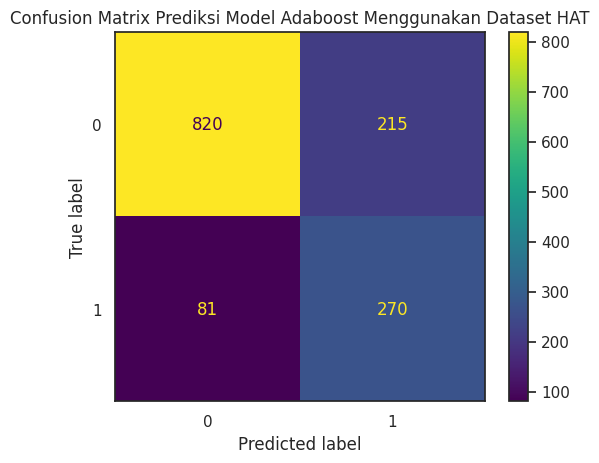

In [ ]:
cm = confusion_matrix(y_test,xg_pred_aug)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.title('Confusion Matrix Prediksi Model Adaboost Menggunakan Dataset HAT')
plt.savefig('Confusion Matrix Prediksi Model Adaboost Menggunakan Dataset HAT.jpg',dpi=300)
plt.show()

In [ ]:
#df_pred_res_aug.to_excel('result_predict_aug.xlsx')

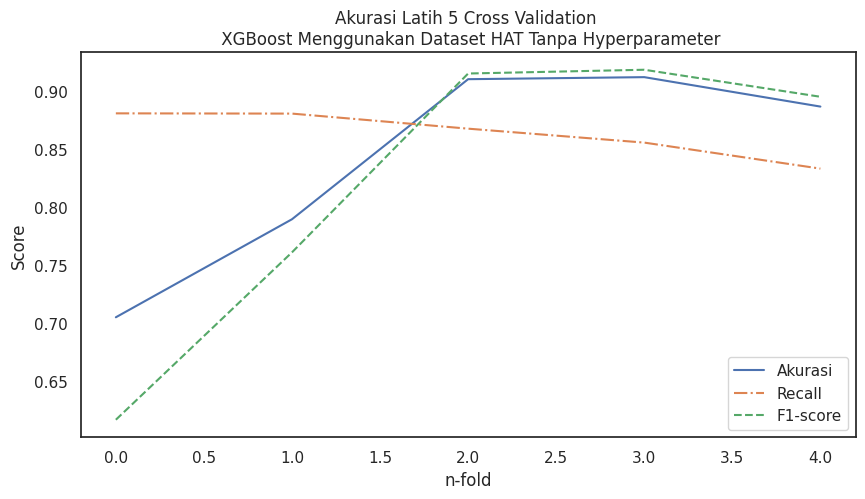

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_acc_aug)
plt.plot(train_recall_aug, linestyle='-.')
plt.plot(train_f1_aug, linestyle='--')
plt.title('Akurasi Latih 5 Cross Validation \n XGBoost Menggunakan Dataset HAT Tanpa Hyperparameter')
plt.xlabel('n-fold')
plt.ylabel('Score')
plt.legend(["Akurasi","Recall","F1-score"], loc ="lower right")
plt.savefig('Akurasi Latih 5 Cross Validation \n XGBoost Menggunakan Dataset HAT Tanpa Hyperparameter.jpg',dpi=300)
plt.show()

### Menggunakan Data CVAE

In [ ]:
train_acc_cvae = []
train_recall_cvae = []
train_f1_cvae = []
xg_cvae = AdaBoostClassifier() #XGBClassifier(objective= 'binary:logistic', nthread=4, seed=42)
for train_index, test_index in sss.split(x_cvae, y_cvae):
    x_train_fold_cvae, x_test_fold_cvae = x_cvae.iloc[train_index], x_cvae.iloc[test_index]
    y_train_fold_cvae, y_test_fold_cvae = y_cvae.iloc[train_index], y_cvae.iloc[test_index]
    xg_cvae.fit(x_train_fold_cvae, y_train_fold_cvae)
    xg_cvae_pred = xg_cvae.predict(x_test_fold_cvae)
    train_acc_cvae.append(accuracy_score(y_test_fold_cvae, xg_cvae_pred))
    train_recall_cvae.append(recall_score(y_test_fold_cvae, xg_cvae_pred))
    train_f1_cvae.append(f1_score(y_test_fold_cvae, xg_cvae_pred))

In [ ]:
#train_f1_cvae.clear()
#train_recall_cvae.clear()
#train_f1_cvae.clear()

In [ ]:
df_f1_cvae = pd.DataFrame(train_f1_cvae, index=index, columns=['Adaboost CVAE'])
df_f1_cvae.index.name = 'Fold'
df_f1_cvae

Adaboost CVAE
Fold                 
Fold-1       0.496084
Fold-2       0.744153
Fold-3       0.943590
Fold-4       0.939239
Fold-5       0.927731

In [ ]:
#df_f1_aug.to_excel('f1_aug_res.xlsx')

In [ ]:
df_f1_cvae.describe().T#.to_excel('result_cvae.xlsx')

count      mean       std       min       25%       50%  \
Adaboost CVAE    5.0  0.810159  0.194479  0.496084  0.744153  0.927731   

                    75%      max  
Adaboost CVAE  0.939239  0.94359

In [ ]:
test_f1_cvae = []
test_acc_cvae = []
test_recall_cvae = []
xg_pred_cvae = xg_cvae.predict(X_test.to_numpy())
test_acc_cvae.append(accuracy_score(y_test, xg_pred_cvae))
test_recall_cvae.append(recall_score(y_test, xg_pred_cvae))
test_f1_cvae.append(f1_score(y_test, xg_pred_cvae))

In [ ]:
cvae_pred_result_model = {'test accuracy':test_acc_cvae, 'recall': test_recall_cvae, 'f1-score':test_f1_cvae}
df_pred_res_cvae = pd.DataFrame(data=cvae_pred_result_model, index=['Adaboost CVAE'])
df_pred_res_cvae.index.name = 'Model'
df_pred_res_cvae

test accuracy    recall  f1-score
Model                                           
Adaboost CVAE       0.772006  0.404558  0.473333

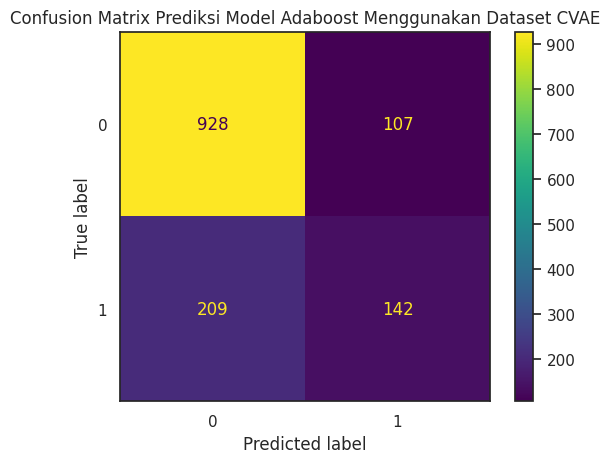

In [ ]:
cm = confusion_matrix(y_test,xg_pred_cvae)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.title('Confusion Matrix Prediksi Model Adaboost Menggunakan Dataset CVAE')
plt.savefig('Confusion Matrix Prediksi Model Adaboost Menggunakan Dataset CVAE.jpg',dpi=300)
plt.show()

In [ ]:
#df_pred_res_aug.to_excel('result_predict_aug.xlsx')

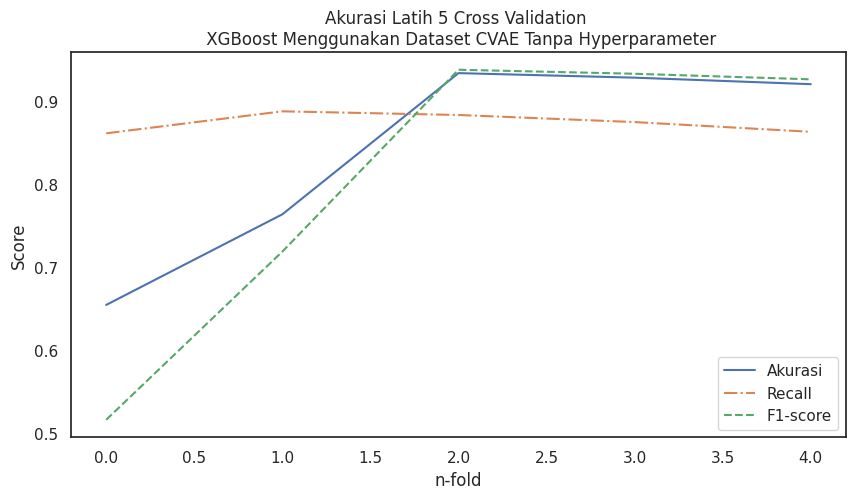

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_acc_cvae)
plt.plot(train_recall_cvae, linestyle='-.')
plt.plot(train_f1_cvae, linestyle='--')
plt.title('Akurasi Latih 5 Cross Validation \n XGBoost Menggunakan Dataset CVAE Tanpa Hyperparameter')
plt.xlabel('n-fold')
plt.ylabel('Score')
plt.legend(["Akurasi","Recall","F1-score"], loc ="lower right")
plt.savefig('Akurasi Latih 5 Cross Validation \n XGBoost Menggunakan Dataset CVAE Tanpa Hyperparameter.jpg',dpi=300)
plt.show()

### Hasil training dengan Data Augmentasi

In [ ]:
# Training F1-score
aug_res = pd.concat([df_f1_smote, df_f1_aug, df_f1_cvae],join='outer',axis=1)
aug_res
#all_res.describe().T

Adaboost SMOTE  Adaboost HAT  Adaboost CVAE
Fold                                               
Fold-1        0.799761      0.806954       0.496084
Fold-2        0.826465      0.817153       0.744153
Fold-3        0.846416      0.827305       0.943590
Fold-4        0.841037      0.832291       0.939239
Fold-5        0.829646      0.800459       0.927731

In [ ]:
aug_res.describe().T.sort_values(by=['mean'],ascending=False)

count      mean       std       min       25%       50%  \
Adaboost SMOTE    5.0  0.828665  0.018093  0.799761  0.826465  0.829646   
Adaboost HAT      5.0  0.816832  0.013364  0.800459  0.806954  0.817153   
Adaboost CVAE     5.0  0.810159  0.194479  0.496084  0.744153  0.927731   

                     75%       max  
Adaboost SMOTE  0.841037  0.846416  
Adaboost HAT    0.827305  0.832291  
Adaboost CVAE   0.939239  0.943590

In [ ]:
aug_pred_res = pd.concat([df_pred_res_smote, df_pred_res_aug, df_pred_res_cvae]).sort_values(by='f1-score',ascending=False)
aug_pred_res

test accuracy    recall  f1-score
Model                                            
Adaboost HAT         0.786436  0.769231  0.645933
Adaboost SMOTE       0.770563  0.826211  0.645880
Adaboost CVAE        0.772006  0.404558  0.473333

In [ ]:
aug_pred_res.sort_values(by='recall',ascending=False)

test accuracy    recall  f1-score
Model                                            
Adaboost SMOTE       0.770563  0.826211  0.645880
Adaboost HAT         0.786436  0.769231  0.645933
Adaboost CVAE        0.772006  0.404558  0.473333

In [ ]:
aug_pred_res.sort_values(by='f1-score',ascending=False).to_excel('aug_pred_res.xlsx')

### Bayesian Optimization

In [ ]:
scoring_opt = ['f1']
space = [
          Real(0.23, 0.35, name="learning_rate"),
          Integer(41, 61, name="n_estimators"),
        ]

scores_bayesian = []
curr_model_hyper_params = ['learning_rate','n_estimators']

def return_model_assessment(args, x_data, y_data):
    global scores_bayesian, curr_model_hyper_params
    params = {curr_model_hyper_params[i]: args[i] for i, j in enumerate(curr_model_hyper_params)}
    model = AdaBoostClassifier()
    model.set_params(**params)

    score = cross_validate(model, x_data, y_data, cv=sss, scoring=scoring_opt)
    scores_bayesian.append(score)
    return 1 - score['test_f1'].mean()

In [ ]:
n_calls = 20 # number of times you want to train your model
objective_function = partial(return_model_assessment, x_data = x_over, y_data = y_over)
result = gp_minimize(objective_function, space, acq_func="EI", base_estimator=None, n_calls=n_calls, n_random_starts=n_calls-1, random_state=42)

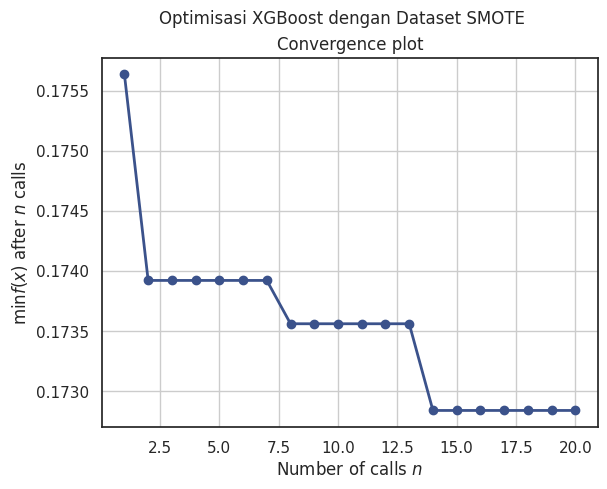

In [ ]:
plt.suptitle('Optimisasi XGBoost dengan Dataset SMOTE', fontsize=12)
plot_convergence(result)
plt.show()

In [ ]:
it_lr = []
it_n = []

In [ ]:
#it_lr.clear()
#it_max.clear()
#it_gamma.clear()

In [ ]:
result.fun

0.17284093947484025

In [ ]:
it_res = list(result.func_vals)
for i in result.x_iters:
  it_lr.append(i[0])
  it_n.append(i[1])

In [ ]:
it = {'learning rate':it_lr, 'n_estimator':it_n, 'hasil obj':it_res }
df_iter = pd.DataFrame(data=it)
df_iter.round(decimals=4)

learning rate  n_estimator  hasil obj
0          0.3256           45     0.1756
1          0.3236           53     0.1739
2          0.2835           43     0.1749
3          0.2851           48     0.1749
4          0.2471           54     0.1753
5          0.2368           55     0.1764
6          0.3426           41     0.1741
7          0.3491           53     0.1736
8          0.3034           41     0.1754
9          0.2328           51     0.1758
10         0.2780           42     0.1737
11         0.3469           46     0.1742
12         0.2409           53     0.1762
13         0.2759           61     0.1728
14         0.2860           58     0.1742
15         0.3116           50     0.1750
16         0.2316           60     0.1755
17         0.2976           49     0.1746
18         0.2319           46     0.1761
19         0.2626           41     0.1765

In [ ]:
round(result.fun,4)

0.1728

In [ ]:
result.x

[0.27589543895205954, 61]

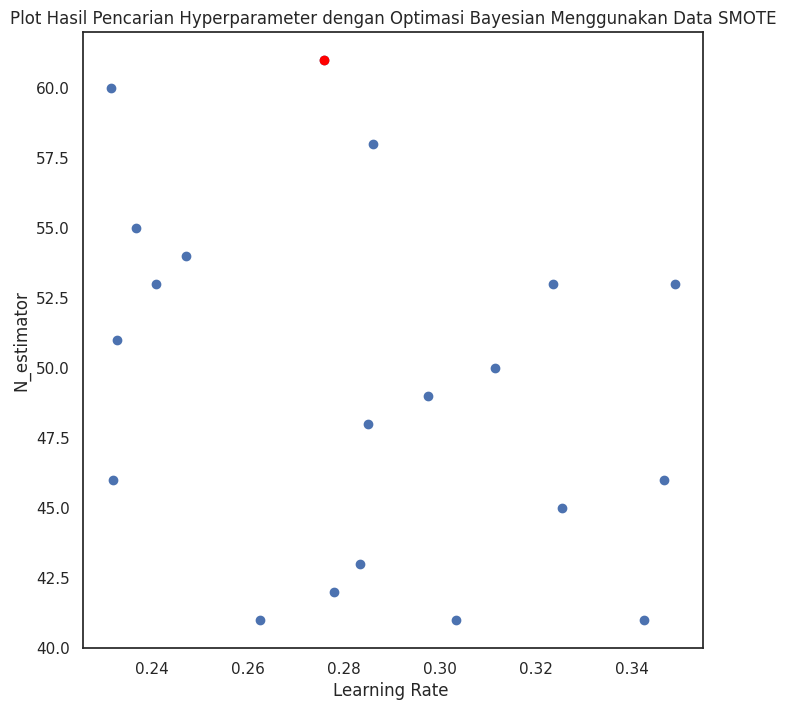

<Figure size 640x480 with 0 Axes>

In [ ]:

plt.figure(figsize=(8, 8))
plt.title('Plot Hasil Pencarian Hyperparameter dengan Optimasi Bayesian Menggunakan Data SMOTE')
plt.scatter(it_lr, it_n)
plt.scatter(result.x[0], result.x[1], color="red")
plt.xlabel('Learning Rate ')
plt.ylabel('N_estimator')
plt.show()
plt.savefig('Plot Hasil Pencarian Hyperparameter dengan Optimasi Bayesian Menggunakan Data SMOTE.jpg',dpi=300)

<Figure size 1000x1000 with 0 Axes>

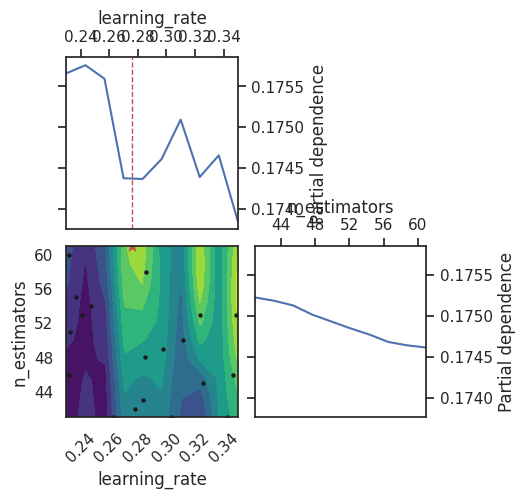

In [ ]:
plt.figure(figsize=(10,10))
plot_objective(result, n_points=10)
plt.show()

Training dengan hyperparameter

In [ ]:
xg_bo = AdaBoostClassifier(learning_rate = result.x[0], n_estimators = result.x[1])

In [ ]:
train_acc_bo = []
train_recall_bo = []
train_f1_bo = []

for train_index, test_index in sss.split(x_over, y_over):
    x_train_fold, x_test_fold = x_over.iloc[train_index], x_over.iloc[test_index]
    y_train_fold, y_test_fold = y_over.iloc[train_index], y_over.iloc[test_index]
    xg_bo.fit(x_train_fold, y_train_fold)
    xg_bo_pred = xg_bo.predict(x_test_fold)
    train_acc_bo.append(accuracy_score(y_test_fold, xg_bo_pred))
    train_recall_bo.append(recall_score(y_test_fold, xg_bo_pred))
    train_f1_bo.append(f1_score(y_test_fold, xg_bo_pred))

In [ ]:
#train_acc_bo.clear()
#train_recall_bo.clear()
#train_f1_bo.clear()

In [ ]:
df_f1_bo = pd.DataFrame(train_f1_bo, index=index, columns=['Adaboost SMOTE BO'])
df_f1_bo.index.name = 'Fold'
df_f1_bo

Adaboost SMOTE BO
Fold                     
Fold-1           0.800468
Fold-2           0.822506
Fold-3           0.847419
Fold-4           0.839866
Fold-5           0.825537

In [ ]:
#df_f1_bo.to_excel('f1_bo_res.xlsx')

In [ ]:
df_f1_bo.describe().T#.to_excel('f1_bo_res_top.xlsx')

count      mean       std       min       25%       50%  \
Adaboost SMOTE BO    5.0  0.827159  0.018087  0.800468  0.822506  0.825537   

                        75%       max  
Adaboost SMOTE BO  0.839866  0.847419

In [ ]:
test_f1_bo = []
test_acc_bo = []
test_recall_bo = []
xg_pred_bo = xg_bo.predict(X_test.to_numpy())
test_acc_bo.append(accuracy_score(y_test, xg_pred_bo))
test_recall_bo.append(recall_score( y_test, xg_pred_bo))
test_f1_bo.append(f1_score(y_test, xg_pred_bo))

In [ ]:
bo_pred_result_model = {'test accuracy':test_acc_bo, 'recall': test_recall_bo, 'f1-score':test_f1_bo}
df_pred_res_bo = pd.DataFrame(data=bo_pred_result_model, index=['Adaboost SMOTE BO'])
df_pred_res_bo.index.name = 'Model'
df_pred_res_bo

test accuracy    recall  f1-score
Model                                               
Adaboost SMOTE BO       0.767677  0.849003  0.649237

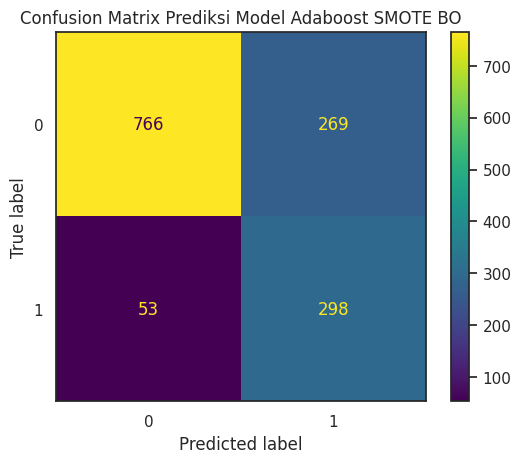

In [ ]:
cm = confusion_matrix(y_test,xg_pred_bo)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.title('Confusion Matrix Prediksi Model Adaboost SMOTE BO')
plt.savefig('Confusion Matrix Prediksi Model Adaboost SMOTE BO.jpg',dpi=300)
plt.show()

In [ ]:
#df_pred_res_bo.to_excel('result_predict_bo.xlsx')

### Hasil Semua Model

In [ ]:
all_res = pd.concat([df_f1_imb,aug_res,df_f1_bo],join='outer',axis=1)
all_res

SVM  Logistic Regression  AdaBoost  Gradient Boosting   Xgboost  \
Fold                                                                           
Fold-1  0.581818             0.595745  0.603922           0.582178  0.572565   
Fold-2  0.569672             0.596899  0.642586           0.637066  0.621469   
Fold-3  0.611111             0.618042  0.633517           0.638941  0.594286   
Fold-4  0.622391             0.642729  0.637681           0.637201  0.562264   
Fold-5  0.581262             0.613718  0.621762           0.626118  0.572973   

        Adaboost SMOTE  Adaboost HAT  Adaboost CVAE  Adaboost SMOTE BO  
Fold                                                                    
Fold-1        0.799761      0.806954       0.496084           0.800468  
Fold-2        0.826465      0.817153       0.744153           0.822506  
Fold-3        0.846416      0.827305       0.943590           0.847419  
Fold-4        0.841037      0.832291       0.939239           0.839866  
Fold-5        0.829646      0.800459       0.927731           0.825537

In [ ]:
all_res.to_excel('all_res.xlsx')

In [ ]:
all_res.describe().T.sort_values(by=['mean'],ascending=[False])#.to_excel('all_res_describe.xlsx')

count      mean       std       min       25%       50%  \
Adaboost SMOTE         5.0  0.828665  0.018093  0.799761  0.826465  0.829646   
Adaboost SMOTE BO      5.0  0.827159  0.018087  0.800468  0.822506  0.825537   
Adaboost HAT           5.0  0.816832  0.013364  0.800459  0.806954  0.817153   
Adaboost CVAE          5.0  0.810159  0.194479  0.496084  0.744153  0.927731   
AdaBoost               5.0  0.627893  0.015456  0.603922  0.621762  0.633517   
Gradient Boosting      5.0  0.624301  0.024090  0.582178  0.626118  0.637066   
Logistic Regression    5.0  0.613427  0.019143  0.595745  0.596899  0.613718   
SVM                    5.0  0.593251  0.022352  0.569672  0.581262  0.581818   
Xgboost                5.0  0.584711  0.023622  0.562264  0.572565  0.572973   

                          75%       max  
Adaboost SMOTE       0.841037  0.846416  
Adaboost SMOTE BO    0.839866  0.847419  
Adaboost HAT         0.827305  0.832291  
Adaboost CVAE        0.939239  0.943590  
AdaBoost             0.637681  0.642586  
Gradient Boosting    0.637201  0.638941  
Logistic Regression  0.618042  0.642729  
SVM                  0.611111  0.622391  
Xgboost              0.594286  0.621469

In [ ]:
all_res.describe().T.sort_values(by=['mean'],ascending=[False]).to_excel('all_res_train.xlsx')

In [ ]:
all_pred_res = pd.concat([df_pred_res_imb, aug_pred_res, df_pred_res_bo])

In [ ]:
all_pred_res.sort_values(by=['f1-score'],ascending=[False])

test accuracy    recall  f1-score
Model                                                 
AdaBoost                  0.821789  0.660969  0.652602
Adaboost SMOTE BO         0.767677  0.849003  0.649237
Adaboost HAT              0.786436  0.769231  0.645933
Adaboost SMOTE            0.770563  0.826211  0.645880
Logistic Regression       0.819625  0.612536  0.632353
Gradient Boosting         0.817460  0.615385  0.630657
Xgboost                   0.799423  0.584046  0.595930
SVM                       0.809524  0.535613  0.587500
Adaboost CVAE             0.772006  0.404558  0.473333

In [ ]:
all_pred_res.sort_values(by=['f1-score'],ascending=[False]).to_excel('all_pred_res.xlsx')

In [ ]:
all_pred_res.sort_values(by=['recall'],ascending=[False])

test accuracy    recall  f1-score
Model                                                 
Adaboost SMOTE BO         0.767677  0.849003  0.649237
Adaboost SMOTE            0.770563  0.826211  0.645880
Adaboost HAT              0.786436  0.769231  0.645933
AdaBoost                  0.821789  0.660969  0.652602
Gradient Boosting         0.817460  0.615385  0.630657
Logistic Regression       0.819625  0.612536  0.632353
Xgboost                   0.799423  0.584046  0.595930
SVM                       0.809524  0.535613  0.587500
Adaboost CVAE             0.772006  0.404558  0.473333